The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

The images for camera calibration are stored in the folder called `camera_cal`.  The images in `test_images` are for testing your pipeline on single frames.  If you want to extract more test images from the videos, you can simply use an image writing method like `cv2.imwrite()`, i.e., you can read the video in frame by frame as usual, and for frames you want to save for later you can write to an image file.  

To help the reviewer examine your work, please save examples of the output from each stage of your pipeline in the folder called `output_images`, and include a description in your writeup for the project of what each image shows.    The video called `project_video.mp4` is the video your pipeline should work well on.  

The `challenge_video.mp4` video is an extra (and optional) challenge for you if you want to test your pipeline under somewhat trickier conditions.  The `harder_challenge.mp4` video is another optional challenge and is brutal!

If you're feeling ambitious (again, totally optional though), don't stop there!  We encourage you to go out and take video of your own, calibrate your camera and show us how you would implement this project from scratch!

In [47]:
import numpy as np
import cv2
import os

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

## 1. Camera calibration using the calibration images

In [2]:
# For plotting
#fig, axes = plt.subplots(nrows=1, ncols=len(os.listdir("camera_cal/")))
#fig.subplots_adjust(hspace=0.5)

def gather_calibration_points():
    """Get the object points and image points needed for calibration of the camera"""
    # Arrays to store object and image points for all images
    objpoints = [] # 3D points (on which we want to transform)
    imgpoints = [] # 2d chessboard corners

    # for the 9x6 chessboard, make a grid of object points
    objp = np.zeros((9*6,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2) 

    for i,file in enumerate(os.listdir("camera_cal/")):
        img = mpimg.imread("camera_cal/{}".format(file))
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        h,w = gray.shape
        
        # Find the chess board corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
        
        # If found, add them to the list
        if ret:
            objpoints.append(objp)
            
            # Optional: To increase accuracy, use subpixels
            # search margin of 11 x 11, no zerozone, criteria = ( type, max_iter = 20 , epsilon = 0.001 )
            corners2 = cv2.cornerSubPix(gray, corners, (11,11), (-1,-1), (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 20, 0.001))
            
            imgpoints.append(corners2)
            
            # plot an example
            #img_cor = cv2.drawChessboardCorners(img, (9,6), corners2, ret)
            #axes[i].imshow(img_cor)
    return objpoints, imgpoints

## 2. Undistort image

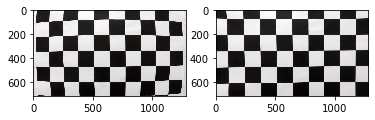

In [45]:
"""Undistorts the image using calibration of the camera"""
objpoints, imgpoints = gather_calibration_points()

# Compute the camera calibration matrix, distortion coefficients, rotation and translation vectors
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, (720,1280), None, None)

# Test
img = mpimg.imread("camera_cal/{}".format('calibration1.jpg'))
undist = cv2.undistort(img, mtx, dist, None, mtx)

fig, axes = plt.subplots(1, 2)
#plt.imsave("output_images/undist_calibration2.jpg",undist)
axes[0].imshow(img)
axes[1].imshow(undist)
plt.savefig("output_images/undist_output.png")

## 3. Apply different thresholding to create binary image

In [4]:
# A function that thresholds the S-channel of HLS
def hls_select(img, thresh=(0, 255)):
    # Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    
    # Apply a threshold to the S channel
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    
    # Return a binary image of threshold result
    return binary_output

In [5]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    abs_sobel_x = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    # 3) Take the absolute value of the x and y gradients
    abs_sobel_y = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    dir = np.arctan2(abs_sobel_y, abs_sobel_x)
    # 5) Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(dir)
    binary_output[(dir >= thresh[0]) & (dir <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output

In [6]:
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately 
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=sobel_kernel)
    # 3) Calculate the magnitude 
    gradmag = np.sqrt(sobel_x**2 + sobel_y**2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*gradmag/np.max(gradmag))
    # 5) Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output

In [7]:
def abs_sobel_thresh(img, orient='x',sobel_kernel=3, thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

In [48]:
def combine_binary_outputs(img):
    """Calculates and combines the binary outputs from different thresholding techniques"""
    # Calculate all the binaries 
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(20, 100))
    grady = abs_sobel_thresh(img, orient='y', sobel_kernel=3, thresh=(20, 100))
    mag_binary = mag_thresh(img, sobel_kernel=7, mag_thresh=(30, 100))
    dir_binary = dir_threshold(img, sobel_kernel=15, thresh=(0.6, 1.5))
    hls_binary = hls_select(img, thresh=(90, 255))

    # Combine all the binaries
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) | (grady == 1) | (mag_binary == 1)) & ((dir_binary == 1) | (hls_binary == 1))] = 1

    # axes[i,0].imshow(gradx, cmap='gray')
    # axes[i,0].set_title('gradx')
    # axes[i,1].imshow(grady, cmap='gray')
    # axes[i,1].set_title('grady')
    # axes[i,2].imshow(mag_binary, cmap='gray')
    # axes[i,2].set_title('mag_binary')
    # axes[i,3].imshow(dir_binary, cmap='gray')
    # axes[i,3].set_title('dir_binary')
    # axes[i,4].imshow(hls_binary, cmap='gray')
    # axes[i,4].set_title('hls_binary')
    # axes[i,5].imshow(combined, cmap='gray')
    # axes[i,5].set_title('combined')
    return combined

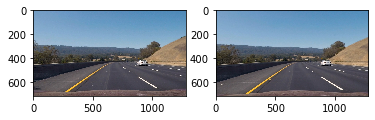

In [46]:
# Test
fig, axes = plt.subplots(1, 2)

# for i,file in enumerate(os.listdir("test_images/")):
file = "test3.jpg"
img = mpimg.imread("test_images/{}".format(file))
img_original = img.copy()

# Undistort images
img = cv2.undistort(img, mtx, dist, None, mtx)

combined = combine_binary_outputs(img)

plt.imshow(combined)
#plt.savefig("output_images/binary_output.png")

## 4. Perspective trasform to top-view


Manually select points on a straight road image

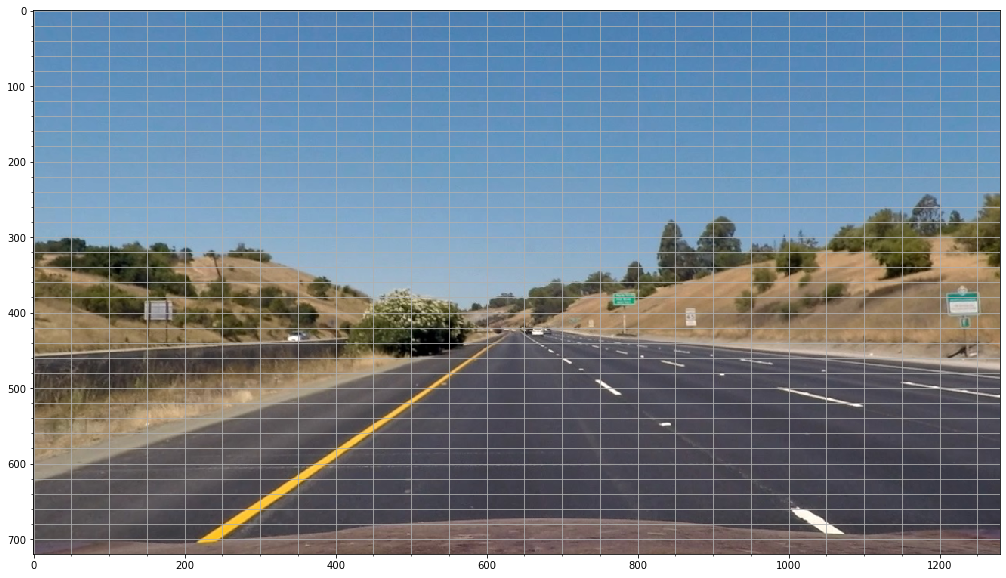

In [65]:
img=mpimg.imread("test_images/straight_lines1.jpg")
img= cv2.undistort(img, mtx, dist, None, mtx)

#img = cv2.polylines(img, np.int32([[[200, 720], [575, 460], [700, 460], [1100, 720]]]), True, color=(255,0,0), thickness=3)

plt.figure(figsize=(20,10))
plt.imshow(img)
plt.grid(True, 'both')
plt.minorticks_on()

#plt.savefig("output_images/src.png")

 Look at a straight lines image and determine 4 points to project into top view.
 
 Manual picking of 4 points (720, 200), (460, 575), (460, 700), (720, 1100)
 
 Remember that retar cv2 flips height and width.

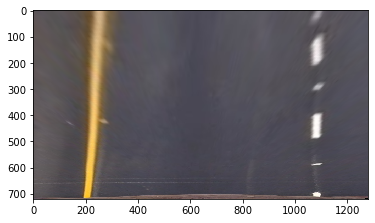

In [66]:
def getM():
    src = np.float32([[200, 720], [575, 460], [700, 460], [1100, 720]])

    # define 4 destination points dst = np.float32([[,],[,],[,],[,]])
    # LEt's have a margin of 200 in x and a margin of 100 on the top such that we assume the lane length to be 30m
    h = 720; w = 1280
    dst = np.float32([[200,h],
                    [200,100],
                    [w-200,100],
                    [w-200,h]])
    # use cv2.getPerspectiveTransform() to get M, the transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    return M
M = getM()
# use cv2.warpPerspective() to warp the image to a top-down view
warped = cv2.warpPerspective(img, M, img.shape[1::-1], flags=cv2.INTER_LINEAR)
# warped = cv2.polylines(warped, np.int32([[[200,h],
#                     [200,100],
#                     [w-200,100],
#                     [w-200,h]]]), True, color=(255,0,0), thickness=3)
plt.imshow(warped)
plt.imsave("output_images/birdeye_straight_lines1.jpg",warped)

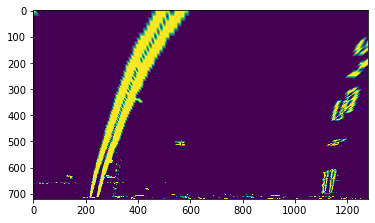

In [12]:
# Warp the binary image into top-down view, using the same parameters as above
h = 720; w = 1280
binary_warped = cv2.warpPerspective(combined, M, (w,h), flags=cv2.INTER_LINEAR)

plt.imshow(binary_warped)
plt.imsave("output_images/topview_binary_test3.jpg",binary_warped)

## 5. Detect lane pixels and fit a quadratic polynomial

In [13]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped,binary_warped,binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


255.0


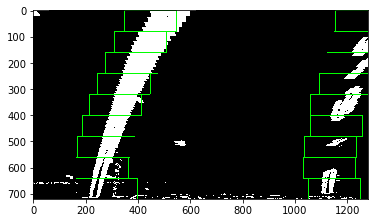

In [14]:
leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
print(out_img.max())
plt.imshow(out_img)

In [15]:
def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, w)
    plt.ylim(h, 0)

    return out_img, left_fit, right_fit, left_fitx, right_fitx, ploty, leftx, lefty, rightx, righty

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


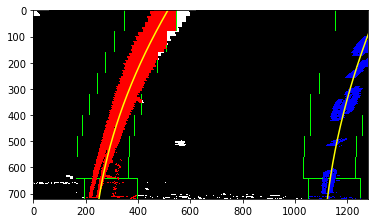

In [16]:
out_img, left_fit, right_fit, left_fitx, right_fitx, ploty, leftx, lefty, rightx, righty = fit_polynomial(binary_warped)
plt.imshow(out_img)
plt.imsave("output_images/detectedlanes_test3.jpg",out_img/255)

In [17]:
def fit_poly(img_shape, leftx, lefty, rightx, righty):
    ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = np.polyval(left_fit,ploty)
    right_fitx = np.polyval(right_fit,ploty)
    
    return left_fitx, right_fitx, ploty, left_fit, right_fit

def search_around_poly(binary_warped, left_fit, right_fit):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty, left_fit, right_fit = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return result, left_fit, right_fit, left_fitx, right_fitx, ploty, leftx, lefty, rightx, righty

## 6. Calculate the radius of the curvature in real world co-ordinates

Radius of Curvature
The radius of curvature at any point $x$ of the function $x=f(y)$ is given as follows:

$$
\LARGE R_{curve} = \frac{[1 + (\frac{dx}{dy})^2]^{3/2}}{|\frac{d^2x}{dy^2}|}
$$
 
​	 

In the case of the second order polynomial $f(y)=Ay^2+By+C$, the first and second derivatives are:

$$
\large f'(y) = \frac{dx}{dy} = 2Ay+ B
$$

$$
\large f''(y) = \frac{d^2x}{dy^2} = 2Af
$$

So, our equation for radius of curvature becomes:

$$
\LARGE R_{curve} = \frac{(1 + (2Ay + B)^2)^{3/2}}{\left|2A \right|}
$$
​
The $x,y$ are supposed to be in real world coordinates, instead of pixel coordinates. So, we multiply with a scaling factor.

Assuming that the lane is about 30 meters long and 3.7 meters wide, the scaling factor is in vertical direction is 30/height and in horizontal direction is 3.7/(width-2*margin).

In [18]:
y_eval = h # Evaluate curvature at the bottom of the image
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/(w-400) # meters per pixel in x dimension # 200 margin on left and right of the lane

left_curverad = ((1 + (2*left_fit[0]*y_eval*ym_per_pix + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval*ym_per_pix + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    

Vehicle position with respect to center:

Assuming the camera is mounted at the center of the car, such that the lane center is the midpoint at the bottom of the image between the two detected lines, the offset of the lane center from the center of the image (converted from pixels to meters) is the distance from the center of the lane to the center of the image.

In [19]:
# The offset of the lane center from the center of the image (converted from pixels to meters) is the distance from the center of the lane
lane_center = (left_fitx[-1] + right_fitx[-1])/2 # the lane center is the midpoint at the bottom of the image between the two lines
offset = (w/2 - lane_center)*xm_per_pix
leftorright = "left" if offset < 0 else "right"

## 7. Warp the detected lane boundaries back onto the original image.

In [20]:
# Create an image to draw the lines on
color_warp = np.zeros_like(img).astype(np.uint8)

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

## 8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

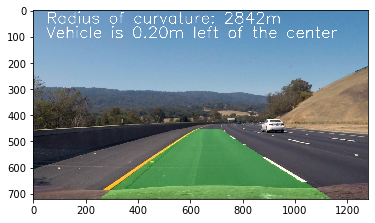

In [21]:
# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

Minv = np.linalg.pinv(M)

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (w,h)) 
# Combine the result with the original image
result = cv2.addWeighted(img_original, 1, newwarp, 0.3, 0)

cv2.putText(result, "Radius of curvature: {:.0f}m ".format((left_curverad+right_curverad)/2), (50,50), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255),2 ,cv2.LINE_AA)
cv2.putText(result, "Vehicle is {:.2f}m {} of the center".format(np.abs(offset), leftorright), (50,105), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255),2 ,cv2.LINE_AA)

plt.imshow(result)
plt.imsave("output_images/result_test3.jpg", result)

## Combining everything to run on the video

In [22]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        # polynomial coefficients of the last n fits
        self.recent_fits = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None  


In [23]:
class VideoAttributes():
    def __init__(self):
        self. firstframe = True
        self.mtx = None
        self.dist = None
        self.M = None
        self.ym_per_pix = 30/720 # meters per pixel in y dimension
        w = 1280
        self.xm_per_pix = 3.7/(w-400) # meters per pixel in x dimension # 200 margin on left and right of the lane



In [39]:
def process_img(img):
    """The whole pipeline"""
    global videoattr
    global leftLane
    global rightLane
    h,w = img.shape[0], img.shape[1]

    y_eval = h
    ym_per_pix = videoattr.ym_per_pix
    xm_per_pix = videoattr.xm_per_pix
    # The output should be a color image (3 channel) for processing video below
    img_original = img.copy()
    
    # If running first time, calibrate camera
    if videoattr.firstframe:
        objpoints, imgpoints = gather_calibration_points()
        ret, videoattr.mtx, videoattr.dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, (w,h), None, None)
        videoattr.M = getM()
        y_eval = h # Evaluate curvature at the bottom of the image
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/(w-400) # meters per pixel in x dimension # 200 margin on left and right of the lane

    # Undistort image
    img = cv2.undistort(img, mtx, dist, None, mtx)

    # Edge detection 
    combined = combine_binary_outputs(img)

    # Perspective transform
    binary_warped = cv2.warpPerspective(combined, videoattr.M, (w,h), flags=cv2.INTER_LINEAR)

    # Fit polynomial
    if videoattr.firstframe:
        out_img, leftLane.current_fit, rightLane.current_fit, left_fitx, right_fitx, ploty, leftx, lefty, rightx, righty = fit_polynomial(binary_warped)
    else:
        # If lane was not detected previously. detect it again
        if (len(leftLane.current_fit) != 3) | (len(rightLane.current_fit) != 3):
            out_img, leftLane.current_fit, rightLane.current_fit, left_fitx, right_fitx, ploty, leftx, lefty, rightx, righty = fit_polynomial(binary_warped)
        else:
            # Else, use previous frame's lane data to search in it's neighborhood
            out_img, leftLane.current_fit, rightLane.current_fit, left_fitx, right_fitx, ploty, leftx, lefty, rightx, righty = search_around_poly(binary_warped, leftLane.current_fit, rightLane.current_fit)
            
    leftLane.allx, leftLane.ally, rightLane.allx, rightLane.ally = leftx, lefty, rightx, righty
    
    # Sanity check
    # Check if lanes are seperated approx by 3.7 meters
    #if ((np.abs(left_fitx[-1] - right_fitx[-1])*xm_per_pix > 3) and np.abs(left_fitx[-1] - right_fitx[-1])*xm_per_pix < 4) and not videoattr.firstframe:
    # Check if Line was detected or not
    if len(leftLane.current_fit) == 3:
        leftLane.detected = True
        if not videoattr.firstframe:
            leftLane.diffs = leftLane.recent_fits[-1] - leftLane.current_fit #difference in fit coefficients between last and new fits
        else:
            leftLane.bestx, leftLane.best_fit = left_fitx, leftLane.current_fit
        leftLane.recent_xfitted.append(left_fitx)   # fitx of the last 30 fits
        leftLane.recent_fits.append(leftLane.current_fit) # polynomial coefficients of the last n fits
        if len(leftLane.recent_fits) > 30: # Maintain a list of 30 latest fits
            del leftLane.recent_xfitted[0]
            del leftLane.recent_fits[0]
    else:
        leftLane.detected = False
        
    if len(rightLane.current_fit) == 3:
        rightLane.detected = True
        if not videoattr.firstframe:
            rightLane.diffs = rightLane.recent_fits[-1] - rightLane.current_fit #difference in fit coefficients between last and new fits
        else:
            rightLane.bestx, rightLane.best_fit = right_fitx, rightLane.current_fit
        rightLane.recent_xfitted.append(right_fitx)   # fitx of the last 30 fits
        rightLane.recent_fits.append(rightLane.current_fit) # polynomial coefficients of the last n fits
        if len(rightLane.recent_fits) > 30: # Maintain a list of 30 latest fits
            del rightLane.recent_xfitted[0]
            del rightLane.recent_fits[0]
    else:
        rightLane.detected = False
    
    #if (len(leftLane.recent_fits)==0) or (len( rightLane.recent_fits)==0):
    #    return img_original
    #print("pass")
    if not videoattr.firstframe:
        leftLane.bestx = sum(leftLane.recent_xfitted)/len(leftLane.recent_xfitted)
        rightLane.bestx = sum(rightLane.recent_xfitted)/len(rightLane.recent_xfitted)
        leftLane.best_fit = sum(leftLane.recent_fits)/len(leftLane.recent_fits)
        rightLane.best_fit = sum(rightLane.recent_fits)/len(rightLane.recent_fits)

    try:
        # Finding the Rdius of curvature of the best fit
        leftLane.radius_of_curvature = ((1 + (2*leftLane.best_fit[0]*y_eval*ym_per_pix + leftLane.best_fit[1])**2)**1.5) / np.absolute(2*leftLane.best_fit[0])
        rightLane.radius_of_curvature = ((1 + (2*rightLane.best_fit[0]*y_eval*ym_per_pix + rightLane.best_fit[1])**2)**1.5) / np.absolute(2*rightLane.best_fit[0])

        # The offset of the lane center from the center of the image (converted from pixels to meters) is the distance from the center of the lane
        lane_center = (leftLane.best_fit[-1] + rightLane.best_fit[-1])/2 # the lane center is the midpoint at the bottom of the image between the two lines
        offset = (w/2 - lane_center)*xm_per_pix
        leftorright = "left" if offset < 0 else "right"
        #distance in meters of vehicle center from the line
        leftLane.line_base_pos = w/2 - leftLane.best_fit[-1] 
        rightLane.line_base_pos = w/2 - rightLane.best_fit[-1] 
    except TypeError:
        print( "no fit found" )
    color_warp = np.zeros_like(img_original).astype(np.uint8)
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    Minv = np.linalg.pinv(videoattr.M)    # pseudo inverse

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (w,h)) 
    # Combine the result with the original image
    result = cv2.addWeighted(img_original, 1, newwarp, 0.3, 0)

    try:
        cv2.putText(result, "Radius of curvature: {:.0f}m ".format((leftLane.radius_of_curvature+rightLane.radius_of_curvature)/2), (50,50), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255),2 ,cv2.LINE_AA)
        cv2.putText(result, "Vehicle is {:.2f}m {} of the center".format(np.abs(offset), leftorright), (50,105), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255),2 ,cv2.LINE_AA)
    except TypeError:
        print("unable to put text")
    videoattr.firstframe = False
    return result

In [25]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

                                                                                                                       
                                                                                                                    


                                                                                                              



                                                                                                           

t:   0%|                                                               | 1/1260 [09:16<194:46:38, 556.95s/it, now=None]


t:   0%|                                                               | 1/1260 [06:22<133:40:14, 382.22s/it, now=None]



t:   0%|                                                                | 1/1260 [04:15<89:25:21, 255.70s/it, now=None]

                                                                                                                       
                                                    

True
[-3.30506055e-04  4.43154454e-01  1.39793852e+02] [-4.15884193e-04  5.69269959e-01  9.75197131e+02]
Moviepy - Building video result1.mp4.
Moviepy - Writing video result1.mp4








t:   0%|                                                                    | 2/1260 [00:00<02:51,  7.35it/s, now=None]

False
[-3.28753613e-04  4.40926743e-01  1.39895422e+02] [-4.96220286e-04  6.39120090e-01  9.62054409e+02]







t:   0%|▏                                                                   | 3/1260 [00:00<03:40,  5.70it/s, now=None]

False
[-3.40701859e-04  4.51846613e-01  1.37684494e+02] [-4.85134356e-04  6.38473655e-01  9.57879229e+02]







t:   0%|▏                                                                   | 4/1260 [00:00<04:10,  5.01it/s, now=None]

False
[-3.49254787e-04  4.59711937e-01  1.36431518e+02] [-4.32028591e-04  6.03613695e-01  9.59227830e+02]







t:   0%|▎                                                                   | 5/1260 [00:01<04:38,  4.51it/s, now=None]

False
[-3.59054673e-04  4.69164996e-01  1.34748908e+02] [-3.78674359e-04  5.68208445e-01  9.60737569e+02]







t:   0%|▎                                                                   | 6/1260 [00:01<04:54,  4.26it/s, now=None]

False
[-3.66752046e-04  4.77338925e-01  1.33028947e+02] [-3.45382062e-04  5.45656499e-01  9.61843871e+02]







t:   1%|▍                                                                   | 7/1260 [00:01<05:04,  4.11it/s, now=None]

False
[-3.74923813e-04  4.86437832e-01  1.31074631e+02] [-3.24679848e-04  5.33479636e-01  9.61148060e+02]







t:   1%|▍                                                                   | 8/1260 [00:01<05:11,  4.01it/s, now=None]

False
[-3.75636753e-04  4.89875455e-01  1.29736398e+02] [-3.08883441e-04  5.24415022e-01  9.60832836e+02]







t:   1%|▍                                                                   | 9/1260 [00:02<05:32,  3.76it/s, now=None]

False
[-3.76596075e-04  4.93718349e-01  1.28376545e+02] [-3.03869404e-04  5.24905341e-01  9.58415118e+02]







t:   1%|▌                                                                  | 10/1260 [00:02<05:31,  3.77it/s, now=None]

False
[-3.75654063e-04  4.96364344e-01  1.26822220e+02] [-3.05987396e-04  5.28201860e-01  9.56791002e+02]







t:   1%|▌                                                                  | 11/1260 [00:02<05:31,  3.77it/s, now=None]

False
[-3.71679857e-04  4.96712518e-01  1.25421774e+02] [-3.15733530e-04  5.36867312e-01  9.54510227e+02]







t:   1%|▋                                                                  | 12/1260 [00:02<05:37,  3.70it/s, now=None]

False
[-3.67577547e-04  4.96922301e-01  1.24068609e+02] [-3.31980270e-04  5.51621347e-01  9.50719504e+02]







t:   1%|▋                                                                  | 13/1260 [00:03<05:35,  3.72it/s, now=None]

False
[-3.64257112e-04  4.98336748e-01  1.21862835e+02] [-3.45447012e-04  5.61262104e-01  9.49565478e+02]







t:   1%|▋                                                                  | 14/1260 [00:03<05:30,  3.78it/s, now=None]

False
[-3.58514423e-04  4.97380274e-01  1.20187019e+02] [-3.58472317e-04  5.72271501e-01  9.47346854e+02]







t:   1%|▊                                                                  | 15/1260 [00:03<05:28,  3.79it/s, now=None]

False
[-3.51373476e-04  4.94569035e-01  1.19087691e+02] [-3.66067699e-04  5.79435128e-01  9.45552063e+02]







t:   1%|▊                                                                  | 16/1260 [00:04<05:28,  3.79it/s, now=None]

False
[-3.45360732e-04  4.91759686e-01  1.18444699e+02] [-3.56695459e-04  5.75475146e-01  9.44066937e+02]







t:   1%|▉                                                                  | 17/1260 [00:04<05:28,  3.79it/s, now=None]

False
[-3.40794091e-04  4.89782124e-01  1.17904644e+02] [-3.43800374e-04  5.69107252e-01  9.42408671e+02]







t:   1%|▉                                                                  | 18/1260 [00:04<05:27,  3.80it/s, now=None]

False
[-3.38768700e-04  4.89635443e-01  1.17095802e+02] [-3.34473174e-04  5.65446992e-01  9.40399462e+02]







t:   2%|█                                                                  | 19/1260 [00:04<05:40,  3.64it/s, now=None]

False
[-3.38674804e-04  4.90771102e-01  1.16184312e+02] [-3.28043284e-04  5.63957410e-01  9.38037453e+02]







t:   2%|█                                                                  | 20/1260 [00:05<05:44,  3.60it/s, now=None]

False
[-3.37362927e-04  4.91074402e-01  1.15239032e+02] [-3.22424472e-04  5.61505673e-01  9.36721592e+02]







t:   2%|█                                                                  | 21/1260 [00:05<05:46,  3.58it/s, now=None]

False
[-3.35607487e-04  4.91022364e-01  1.14241278e+02] [-3.18345021e-04  5.59516802e-01  9.35797962e+02]







t:   2%|█▏                                                                 | 22/1260 [00:05<05:49,  3.54it/s, now=None]

False
[-3.32938683e-04  4.90118829e-01  1.13326486e+02] [-3.18403773e-04  5.59482384e-01  9.35298196e+02]







t:   2%|█▏                                                                 | 23/1260 [00:05<05:53,  3.50it/s, now=None]

False
[-3.31103921e-04  4.89887792e-01  1.12184293e+02] [-3.19009087e-04  5.58752232e-01  9.35500160e+02]







t:   2%|█▎                                                                 | 24/1260 [00:06<05:47,  3.55it/s, now=None]

False
[-3.29649571e-04  4.89843538e-01  1.10946654e+02] [-3.21551693e-04  5.58650504e-01  9.36063119e+02]







t:   2%|█▎                                                                 | 25/1260 [00:06<05:42,  3.60it/s, now=None]

False
[-3.29211321e-04  4.89881082e-01  1.10019277e+02] [-3.25624452e-04  5.60375702e-01  9.36027080e+02]







t:   2%|█▍                                                                 | 26/1260 [00:06<05:32,  3.72it/s, now=None]

False
[-3.30577086e-04  4.91018770e-01  1.09092881e+02] [-3.36142363e-04  5.68266605e-01  9.34628056e+02]







t:   2%|█▍                                                                 | 27/1260 [00:07<05:25,  3.79it/s, now=None]

False
[-3.30709987e-04  4.91029864e-01  1.08325298e+02] [-3.47937542e-04  5.76315819e-01  9.33711758e+02]







t:   2%|█▍                                                                 | 28/1260 [00:07<05:33,  3.69it/s, now=None]

False
[-3.31860158e-04  4.91665070e-01  1.07535572e+02] [-3.57732304e-04  5.83187160e-01  9.32946845e+02]







t:   2%|█▌                                                                 | 29/1260 [00:07<05:36,  3.66it/s, now=None]

False
[-3.32393284e-04  4.91839467e-01  1.06753566e+02] [-3.65262121e-04  5.87700409e-01  9.33047206e+02]







t:   2%|█▌                                                                 | 30/1260 [00:07<05:45,  3.56it/s, now=None]

False
[-3.32953476e-04  4.91700973e-01  1.06252748e+02] [-3.66417642e-04  5.87936351e-01  9.33410792e+02]







t:   2%|█▋                                                                 | 31/1260 [00:08<05:46,  3.54it/s, now=None]

False
[-3.35112565e-04  4.94310065e-01  1.04601831e+02] [-3.59461371e-04  5.84058141e-01  9.32771358e+02]







t:   3%|█▋                                                                 | 32/1260 [00:08<05:52,  3.49it/s, now=None]

False
[-3.38415481e-04  4.97741567e-01  1.03022970e+02] [-3.46536630e-04  5.75556077e-01  9.32742506e+02]







t:   3%|█▊                                                                 | 33/1260 [00:08<05:42,  3.59it/s, now=None]

False
[-3.42649551e-04  5.01626473e-01  1.01577220e+02] [-3.40872539e-04  5.73175778e-01  9.31556740e+02]







t:   3%|█▊                                                                 | 34/1260 [00:08<05:31,  3.70it/s, now=None]

False
[-3.46035556e-04  5.04868051e-01  1.00137692e+02] [-3.41222145e-04  5.74360608e-01  9.30534838e+02]







t:   3%|█▊                                                                 | 35/1260 [00:09<05:35,  3.65it/s, now=None]

False
[-3.49099479e-04  5.07781109e-01  9.88053548e+01] [-3.47240907e-04  5.80012664e-01  9.28861706e+02]







t:   3%|█▉                                                                 | 36/1260 [00:09<05:38,  3.62it/s, now=None]

False
[-3.52077872e-04  5.10673918e-01  9.75186512e+01] [-3.56665842e-04  5.88563408e-01  9.26626107e+02]







t:   3%|█▉                                                                 | 37/1260 [00:09<05:42,  3.57it/s, now=None]

False
[-3.56014218e-04  5.14310493e-01  9.61586054e+01] [-3.72272566e-04  6.02277835e-01  9.23399835e+02]







t:   3%|██                                                                 | 38/1260 [00:10<05:54,  3.45it/s, now=None]

False
[-3.62234258e-04  5.19567123e-01  9.46634647e+01] [-3.87399769e-04  6.15806508e-01  9.19998544e+02]







t:   3%|██                                                                 | 39/1260 [00:10<05:53,  3.46it/s, now=None]

False
[-3.68971598e-04  5.25088924e-01  9.31792631e+01] [-3.96918915e-04  6.24860666e-01  9.17353315e+02]







t:   3%|██▏                                                                | 40/1260 [00:10<05:43,  3.55it/s, now=None]

False
[-3.76773293e-04  5.31307432e-01  9.17669689e+01] [-3.98432422e-04  6.29028160e-01  9.14767836e+02]







t:   3%|██▏                                                                | 41/1260 [00:10<05:36,  3.62it/s, now=None]

False
[-3.85136334e-04  5.37959426e-01  9.03340259e+01] [-3.96584255e-04  6.30420759e-01  9.12793042e+02]







t:   3%|██▏                                                                | 42/1260 [00:11<05:34,  3.64it/s, now=None]

False
[-3.92653582e-04  5.43857073e-01  8.90491252e+01] [-3.88831851e-04  6.26715634e-01  9.11850439e+02]







t:   3%|██▎                                                                | 43/1260 [00:11<05:34,  3.64it/s, now=None]

False
[-4.00378831e-04  5.49683578e-01  8.80562773e+01] [-3.82082511e-04  6.24661586e-01  9.10122372e+02]







t:   3%|██▎                                                                | 44/1260 [00:11<05:39,  3.58it/s, now=None]

False
[-4.08665300e-04  5.56078635e-01  8.69630980e+01] [-3.75286624e-04  6.21586890e-01  9.09127951e+02]







t:   4%|██▍                                                                | 45/1260 [00:12<05:32,  3.66it/s, now=None]

False
[-4.17259653e-04  5.62976950e-01  8.56791884e+01] [-3.69664961e-04  6.18552451e-01  9.08582261e+02]







t:   4%|██▍                                                                | 46/1260 [00:12<05:25,  3.73it/s, now=None]

False
[-4.24840618e-04  5.69592049e-01  8.41818419e+01] [-3.74322605e-04  6.21934411e-01  9.08086719e+02]







t:   4%|██▍                                                                | 47/1260 [00:12<05:26,  3.71it/s, now=None]

False
[-4.31576769e-04  5.75580333e-01  8.27112840e+01] [-3.84261324e-04  6.28632400e-01  9.07590618e+02]







t:   4%|██▌                                                                | 48/1260 [00:12<05:23,  3.75it/s, now=None]

False
[-4.36426018e-04  5.80270278e-01  8.13542150e+01] [-3.95763767e-04  6.36057060e-01  9.07260082e+02]







t:   4%|██▌                                                                | 49/1260 [00:13<05:20,  3.78it/s, now=None]

False
[-4.40107534e-04  5.84328024e-01  7.99926348e+01] [-4.07171693e-04  6.43692731e-01  9.06828107e+02]







t:   4%|██▋                                                                | 50/1260 [00:13<05:18,  3.80it/s, now=None]

False
[-4.42831734e-04  5.87775585e-01  7.86750762e+01] [-4.18785564e-04  6.51827200e-01  9.06238517e+02]







t:   4%|██▋                                                                | 51/1260 [00:13<05:13,  3.85it/s, now=None]

False
[-4.44922226e-04  5.90752696e-01  7.75057708e+01] [-4.33673785e-04  6.63627991e-01  9.04593696e+02]







t:   4%|██▊                                                                | 52/1260 [00:13<05:12,  3.87it/s, now=None]

False
[-4.47921094e-04  5.94515108e-01  7.62803024e+01] [-4.45551741e-04  6.74127702e-01  9.02603939e+02]







t:   4%|██▊                                                                | 53/1260 [00:14<05:16,  3.81it/s, now=None]

False
[-4.48989806e-04  5.96485363e-01  7.55842769e+01] [-4.51845760e-04  6.81888768e-01  9.00176066e+02]







t:   4%|██▊                                                                | 54/1260 [00:14<05:16,  3.81it/s, now=None]

False
[-4.49670034e-04  5.98122781e-01  7.50714574e+01] [-4.51445429e-04  6.85479290e-01  8.97780229e+02]







t:   4%|██▉                                                                | 55/1260 [00:14<05:16,  3.80it/s, now=None]

False
[-4.50360894e-04  6.00165524e-01  7.43351880e+01] [-4.46301043e-04  6.85225248e-01  8.95980473e+02]







t:   4%|██▉                                                                | 56/1260 [00:14<05:17,  3.79it/s, now=None]

False
[-4.49211835e-04  6.00905680e-01  7.36833540e+01] [-4.35658659e-04  6.79568662e-01  8.95465892e+02]







t:   5%|███                                                                | 57/1260 [00:15<05:16,  3.80it/s, now=None]

False
[-4.49130137e-04  6.02487843e-01  7.29512452e+01] [-4.23628952e-04  6.73168407e-01  8.94840487e+02]







t:   5%|███                                                                | 58/1260 [00:15<05:15,  3.81it/s, now=None]

False
[-4.47942907e-04  6.03256473e-01  7.23557254e+01] [-4.12552814e-04  6.67531896e-01  8.93994830e+02]







t:   5%|███▏                                                               | 59/1260 [00:15<05:14,  3.82it/s, now=None]

False
[-4.47549563e-04  6.04530804e-01  7.17773267e+01] [-4.06127628e-04  6.65961757e-01  8.92064410e+02]







t:   5%|███▏                                                               | 60/1260 [00:16<05:14,  3.81it/s, now=None]

False
[-4.46229929e-04  6.04942957e-01  7.13962059e+01] [-4.06339216e-04  6.69799915e-01  8.89081398e+02]







t:   5%|███▏                                                               | 61/1260 [00:16<05:14,  3.81it/s, now=None]

False
[-4.43705211e-04  6.04222229e-01  7.12151277e+01] [-4.17102005e-04  6.82296717e-01  8.84603364e+02]







t:   5%|███▎                                                               | 62/1260 [00:16<05:12,  3.83it/s, now=None]

False
[-4.40038446e-04  6.02338686e-01  7.11786265e+01] [-4.26009709e-04  6.93125671e-01  8.80447072e+02]







t:   5%|███▎                                                               | 63/1260 [00:16<05:10,  3.85it/s, now=None]

False
[-4.34175594e-04  5.98600580e-01  7.13572588e+01] [-4.27153889e-04  6.97419778e-01  8.77526290e+02]







t:   5%|███▍                                                               | 64/1260 [00:17<05:20,  3.73it/s, now=None]

False
[-4.28415023e-04  5.94547337e-01  7.17179370e+01] [-4.28628907e-04  7.02133235e-01  8.74389825e+02]







t:   5%|███▍                                                               | 65/1260 [00:17<05:15,  3.78it/s, now=None]

False
[-4.23851167e-04  5.91268866e-01  7.19799642e+01] [-4.24848664e-04  7.02358721e-01  8.72034304e+02]







t:   5%|███▌                                                               | 66/1260 [00:17<05:15,  3.78it/s, now=None]

False
[-4.19604042e-04  5.88150921e-01  7.20968947e+01] [-4.17213787e-04  6.98798024e-01  8.70664571e+02]







t:   5%|███▌                                                               | 67/1260 [00:17<05:18,  3.74it/s, now=None]

False
[-4.14894242e-04  5.84160400e-01  7.24655925e+01] [-4.01758663e-04  6.88265865e-01  8.70715815e+02]







t:   5%|███▌                                                               | 68/1260 [00:18<05:16,  3.76it/s, now=None]

False
[-4.09545220e-04  5.79450022e-01  7.29562337e+01] [-3.90131252e-04  6.80092678e-01  8.70724111e+02]







t:   5%|███▋                                                               | 69/1260 [00:18<05:13,  3.80it/s, now=None]

False
[-4.02361201e-04  5.73066343e-01  7.36559201e+01] [-3.83539610e-04  6.74895309e-01  8.70746108e+02]







t:   6%|███▋                                                               | 70/1260 [00:18<05:16,  3.76it/s, now=None]

False
[-3.94612974e-04  5.65888509e-01  7.45988214e+01] [-3.85233078e-04  6.75751869e-01  8.70006569e+02]







t:   6%|███▊                                                               | 71/1260 [00:18<05:38,  3.51it/s, now=None]

False
[-3.86572030e-04  5.58382636e-01  7.55498108e+01] [-3.89581740e-04  6.77976902e-01  8.69268249e+02]







t:   6%|███▊                                                               | 72/1260 [00:19<05:31,  3.59it/s, now=None]

False
[-3.79896844e-04  5.51799650e-01  7.64138011e+01] [-3.99535859e-04  6.83924331e-01  8.68046965e+02]







t:   6%|███▉                                                               | 73/1260 [00:19<05:23,  3.67it/s, now=None]

False
[-3.71796002e-04  5.43865945e-01  7.75122298e+01] [-4.11762234e-04  6.91436449e-01  8.66587474e+02]







t:   6%|███▉                                                               | 74/1260 [00:19<05:21,  3.69it/s, now=None]

False
[-3.64650174e-04  5.36562077e-01  7.85038451e+01] [-4.23675570e-04  6.98633497e-01  8.65087635e+02]







t:   6%|███▉                                                               | 75/1260 [00:20<05:24,  3.65it/s, now=None]

False
[-3.58125302e-04  5.29590358e-01  7.95150669e+01] [-4.34682748e-04  7.06020612e-01  8.63157660e+02]







t:   6%|████                                                               | 76/1260 [00:20<05:23,  3.66it/s, now=None]

False
[-3.50187973e-04  5.21164074e-01  8.08028767e+01] [-4.41246356e-04  7.10313691e-01  8.61646306e+02]







t:   6%|████                                                               | 77/1260 [00:20<05:19,  3.70it/s, now=None]

False
[-3.43067929e-04  5.13386985e-01  8.19970860e+01] [-4.41045882e-04  7.10056548e-01  8.60600041e+02]







t:   6%|████▏                                                              | 78/1260 [00:20<05:29,  3.59it/s, now=None]

False
[-3.35949944e-04  5.05602921e-01  8.30876360e+01] [-4.38855668e-04  7.07598693e-01  8.60404778e+02]







t:   6%|████▏                                                              | 79/1260 [00:21<05:34,  3.53it/s, now=None]

False
[-3.27965152e-04  4.96870168e-01  8.43463348e+01] [-4.33065188e-04  7.01515865e-01  8.61227034e+02]







t:   6%|████▎                                                              | 80/1260 [00:21<05:26,  3.61it/s, now=None]

False
[-3.21877653e-04  4.89214861e-01  8.55817706e+01] [-4.23890581e-04  6.92896544e-01  8.62288297e+02]







t:   6%|████▎                                                              | 81/1260 [00:21<05:22,  3.66it/s, now=None]

False
[-3.17487886e-04  4.82481483e-01  8.67900670e+01] [-4.07460011e-04  6.77740969e-01  8.64641681e+02]







t:   7%|████▎                                                              | 82/1260 [00:21<05:27,  3.60it/s, now=None]

False
[-3.14157914e-04  4.76215976e-01  8.80721692e+01] [-3.91365126e-04  6.63234666e-01  8.66678496e+02]







t:   7%|████▍                                                              | 83/1260 [00:22<05:22,  3.65it/s, now=None]

False
[-3.12613298e-04  4.71452985e-01  8.89716017e+01] [-3.81062478e-04  6.52244154e-01  8.68784227e+02]







t:   7%|████▍                                                              | 84/1260 [00:22<05:19,  3.68it/s, now=None]

False
[-3.11019727e-04  4.66606109e-01  8.98785461e+01] [-3.76023052e-04  6.45274255e-01  8.70490846e+02]







t:   7%|████▌                                                              | 85/1260 [00:22<05:20,  3.67it/s, now=None]

False
[-3.09241319e-04  4.61860678e-01  9.05433143e+01] [-3.74170201e-04  6.39524834e-01  8.72881386e+02]







t:   7%|████▌                                                              | 86/1260 [00:23<05:17,  3.69it/s, now=None]

False
[-3.08750611e-04  4.58045706e-01  9.11406527e+01] [-3.74332449e-04  6.35580113e-01  8.74871595e+02]







t:   7%|████▋                                                              | 87/1260 [00:23<05:13,  3.74it/s, now=None]

False
[-3.09425216e-04  4.54968018e-01  9.17805395e+01] [-3.76111624e-04  6.33188475e-01  8.76436517e+02]







t:   7%|████▋                                                              | 88/1260 [00:23<05:14,  3.73it/s, now=None]

False
[-3.10245728e-04  4.51458918e-01  9.28902486e+01] [-3.83212290e-04  6.35947275e-01  8.76576804e+02]







t:   7%|████▋                                                              | 89/1260 [00:23<05:14,  3.72it/s, now=None]

False
[-3.12376399e-04  4.48855525e-01  9.41227470e+01] [-3.84969426e-04  6.35554144e-01  8.76635103e+02]







t:   7%|████▊                                                              | 90/1260 [00:24<05:14,  3.72it/s, now=None]

False
[-3.16319081e-04  4.48118191e-01  9.49680096e+01] [-3.81270011e-04  6.30663526e-01  8.77630680e+02]







t:   7%|████▊                                                              | 91/1260 [00:24<05:13,  3.72it/s, now=None]

False
[-3.20288454e-04  4.47545964e-01  9.58707495e+01] [-3.71517151e-04  6.21104242e-01  8.79352157e+02]







t:   7%|████▉                                                              | 92/1260 [00:24<05:18,  3.66it/s, now=None]

False
[-3.24471413e-04  4.47746829e-01  9.64167627e+01] [-3.64449303e-04  6.12562042e-01  8.81531756e+02]







t:   7%|████▉                                                              | 93/1260 [00:24<05:17,  3.67it/s, now=None]

False
[-3.28848715e-04  4.48410984e-01  9.67647234e+01] [-3.61613687e-04  6.06405315e-01  8.83842689e+02]







t:   7%|████▉                                                              | 94/1260 [00:25<05:11,  3.74it/s, now=None]

False
[-3.34364770e-04  4.50325144e-01  9.69689434e+01] [-3.61312667e-04  6.03142960e-01  8.85221614e+02]







t:   8%|█████                                                              | 95/1260 [00:25<05:17,  3.67it/s, now=None]

False
[-3.38108807e-04  4.51165995e-01  9.73021170e+01] [-3.66755440e-04  6.04355147e-01  8.86003637e+02]







t:   8%|█████                                                              | 96/1260 [00:25<05:24,  3.58it/s, now=None]

False
[-3.40533964e-04  4.51042209e-01  9.78315670e+01] [-3.73374215e-04  6.06365134e-01  8.86621988e+02]







t:   8%|█████▏                                                             | 97/1260 [00:26<05:22,  3.61it/s, now=None]

False
[-3.41488416e-04  4.50206228e-01  9.83154040e+01] [-3.83568092e-04  6.10864483e-01  8.86989832e+02]







t:   8%|█████▏                                                             | 98/1260 [00:26<05:14,  3.70it/s, now=None]

False
[-3.41678530e-04  4.48988716e-01  9.88434867e+01] [-3.92532336e-04  6.14524227e-01  8.87378475e+02]







t:   8%|█████▎                                                             | 99/1260 [00:26<05:08,  3.76it/s, now=None]

False
[-3.42718923e-04  4.48652702e-01  9.91811424e+01] [-4.01418415e-04  6.18118881e-01  8.87826601e+02]







t:   8%|█████▏                                                            | 100/1260 [00:26<05:04,  3.81it/s, now=None]

False
[-3.43780365e-04  4.48447109e-01  9.94543979e+01] [-4.08746671e-04  6.20556246e-01  8.88523410e+02]







t:   8%|█████▎                                                            | 101/1260 [00:27<05:07,  3.77it/s, now=None]

False
[-3.45175786e-04  4.48288457e-01  9.98472151e+01] [-4.13468781e-04  6.21742726e-01  8.89212279e+02]







t:   8%|█████▎                                                            | 102/1260 [00:27<05:05,  3.80it/s, now=None]

False
[-3.46533033e-04  4.48066194e-01  1.00301805e+02] [-4.11640884e-04  6.18907745e-01  8.90359556e+02]







t:   8%|█████▍                                                            | 103/1260 [00:27<05:02,  3.82it/s, now=None]

False
[-3.49862717e-04  4.49287750e-01  1.00697756e+02] [-4.01448293e-04  6.10392596e-01  8.92049815e+02]







t:   8%|█████▍                                                            | 104/1260 [00:27<04:59,  3.86it/s, now=None]

False
[-3.53067246e-04  4.50306582e-01  1.01218707e+02] [-3.88419024e-04  5.99824941e-01  8.94077108e+02]







t:   8%|█████▌                                                            | 105/1260 [00:28<05:00,  3.84it/s, now=None]

False
[-3.56653850e-04  4.51699894e-01  1.01714590e+02] [-3.75798062e-04  5.89220390e-01  8.96214793e+02]







t:   8%|█████▌                                                            | 106/1260 [00:28<04:57,  3.88it/s, now=None]

False
[-3.61671676e-04  4.54475142e-01  1.01963930e+02] [-3.65987951e-04  5.79970425e-01  8.98531233e+02]







t:   8%|█████▌                                                            | 107/1260 [00:28<04:56,  3.88it/s, now=None]

False
[-3.66552231e-04  4.57254863e-01  1.02160966e+02] [-3.59367269e-04  5.72636797e-01  9.00980938e+02]







t:   9%|█████▋                                                            | 108/1260 [00:28<04:55,  3.90it/s, now=None]

False
[-3.71570667e-04  4.60159887e-01  1.02481063e+02] [-3.51055341e-04  5.64638468e-01  9.03248938e+02]







t:   9%|█████▋                                                            | 109/1260 [00:29<04:59,  3.85it/s, now=None]

False
[-3.78532148e-04  4.64467125e-01  1.02865133e+02] [-3.44493366e-04  5.59058165e-01  9.04674883e+02]







t:   9%|█████▊                                                            | 110/1260 [00:29<04:55,  3.90it/s, now=None]

False
[-3.85084723e-04  4.68628803e-01  1.03366420e+02] [-3.44598084e-04  5.59033689e-01  9.05124113e+02]







t:   9%|█████▊                                                            | 111/1260 [00:29<04:55,  3.89it/s, now=None]

False
[-3.91148361e-04  4.72774320e-01  1.03812064e+02] [-3.53073804e-04  5.65401742e-01  9.04700418e+02]







t:   9%|█████▊                                                            | 112/1260 [00:29<04:53,  3.91it/s, now=None]

False
[-3.96748859e-04  4.77034651e-01  1.04114600e+02] [-3.66239833e-04  5.74914528e-01  9.04004266e+02]







t:   9%|█████▉                                                            | 113/1260 [00:30<04:53,  3.90it/s, now=None]

False
[-4.01342012e-04  4.80768587e-01  1.04399131e+02] [-3.80314850e-04  5.84368881e-01  9.03745076e+02]







t:   9%|█████▉                                                            | 114/1260 [00:30<04:50,  3.95it/s, now=None]

False
[-4.06445303e-04  4.84851131e-01  1.04783302e+02] [-3.95312999e-04  5.95520846e-01  9.02713190e+02]







t:   9%|██████                                                            | 115/1260 [00:30<04:56,  3.86it/s, now=None]

False
[-4.11648780e-04  4.88834759e-01  1.05450993e+02] [-4.09649384e-04  6.07629912e-01  9.00723885e+02]







t:   9%|██████                                                            | 116/1260 [00:30<04:58,  3.84it/s, now=None]

False
[-4.17070339e-04  4.93034019e-01  1.06188945e+02] [-4.14726088e-04  6.13342064e-01  8.99320818e+02]







t:   9%|██████▏                                                           | 117/1260 [00:31<05:00,  3.80it/s, now=None]

False
[-4.21179393e-04  4.96549356e-01  1.06935641e+02] [-4.13953637e-04  6.14834834e-01  8.98393590e+02]







t:   9%|██████▏                                                           | 118/1260 [00:31<04:58,  3.83it/s, now=None]

False
[-4.24704987e-04  5.00437317e-01  1.07124219e+02] [-4.08638195e-04  6.11415447e-01  8.99031308e+02]







t:   9%|██████▏                                                           | 119/1260 [00:31<04:54,  3.88it/s, now=None]

False
[-4.27179286e-04  5.03712596e-01  1.07193457e+02] [-4.04737191e-04  6.08352746e-01  9.00062888e+02]







t:  10%|██████▎                                                           | 120/1260 [00:31<04:54,  3.88it/s, now=None]

False
[-4.29328265e-04  5.06918115e-01  1.07094635e+02] [-4.07864445e-04  6.10470386e-01  9.00575879e+02]







t:  10%|██████▎                                                           | 121/1260 [00:32<04:56,  3.85it/s, now=None]

False
[-4.31580683e-04  5.10418078e-01  1.06792626e+02] [-4.15466110e-04  6.16120009e-01  9.00630092e+02]







t:  10%|██████▍                                                           | 122/1260 [00:32<04:53,  3.88it/s, now=None]

False
[-4.32932982e-04  5.13156896e-01  1.06626877e+02] [-4.28059147e-04  6.25915302e-01  8.99876087e+02]







t:  10%|██████▍                                                           | 123/1260 [00:32<04:50,  3.91it/s, now=None]

False
[-4.34084619e-04  5.15709236e-01  1.06553670e+02] [-4.44211087e-04  6.38804530e-01  8.98404545e+02]







t:  10%|██████▍                                                           | 124/1260 [00:33<04:54,  3.85it/s, now=None]

False
[-4.34831651e-04  5.17950606e-01  1.06475884e+02] [-4.58387848e-04  6.50631228e-01  8.96872542e+02]







t:  10%|██████▌                                                           | 125/1260 [00:33<04:56,  3.83it/s, now=None]

False
[-4.34847186e-04  5.19502378e-01  1.06485946e+02] [-4.66699714e-04  6.58345184e-01  8.95853892e+02]







t:  10%|██████▌                                                           | 126/1260 [00:33<04:52,  3.87it/s, now=None]

False
[-4.35611284e-04  5.21631685e-01  1.06452901e+02] [-4.70354769e-04  6.63745814e-01  8.94708202e+02]







t:  10%|██████▋                                                           | 127/1260 [00:33<04:47,  3.94it/s, now=None]

False
[-4.34929822e-04  5.22732965e-01  1.06452132e+02] [-4.70943140e-04  6.66458894e-01  8.94452344e+02]







t:  10%|██████▋                                                           | 128/1260 [00:34<04:50,  3.90it/s, now=None]

False
[-4.34636452e-04  5.24140841e-01  1.06422674e+02] [-4.64427908e-04  6.64422962e-01  8.94611097e+02]







t:  10%|██████▊                                                           | 129/1260 [00:34<04:48,  3.92it/s, now=None]

False
[-4.34837927e-04  5.25824308e-01  1.06435202e+02] [-4.54891558e-04  6.60014169e-01  8.95122131e+02]







t:  10%|██████▊                                                           | 130/1260 [00:34<04:47,  3.93it/s, now=None]

False
[-4.35883970e-04  5.28122716e-01  1.06406828e+02] [-4.44400639e-04  6.55400543e-01  8.95289865e+02]







t:  10%|██████▊                                                           | 131/1260 [00:34<04:52,  3.86it/s, now=None]

False
[-4.37234189e-04  5.30755200e-01  1.06298059e+02] [-4.34718258e-04  6.50884331e-01  8.95517791e+02]







t:  10%|██████▉                                                           | 132/1260 [00:35<04:55,  3.82it/s, now=None]

False
[-4.38117241e-04  5.33193130e-01  1.06143427e+02] [-4.32331913e-04  6.51780642e-01  8.94943656e+02]







t:  11%|██████▉                                                           | 133/1260 [00:35<04:56,  3.80it/s, now=None]

False
[-4.38313957e-04  5.35229782e-01  1.06009647e+02] [-4.39054617e-04  6.59412325e-01  8.93362901e+02]







t:  11%|███████                                                           | 134/1260 [00:35<04:53,  3.83it/s, now=None]

False
[-4.38294726e-04  5.37149820e-01  1.05881721e+02] [-4.49490488e-04  6.69411290e-01  8.91581192e+02]







t:  11%|███████                                                           | 135/1260 [00:35<04:51,  3.87it/s, now=None]

False
[-4.38173501e-04  5.39022502e-01  1.05787156e+02] [-4.63152565e-04  6.82380743e-01  8.89181980e+02]







t:  11%|███████                                                           | 136/1260 [00:36<05:03,  3.70it/s, now=None]

False
[-4.37660846e-04  5.40474887e-01  1.05866913e+02] [-4.77656538e-04  6.96541410e-01  8.86238795e+02]







t:  11%|███████▏                                                          | 137/1260 [00:36<05:02,  3.72it/s, now=None]

False
[-4.36007907e-04  5.40932201e-01  1.06145517e+02] [-4.92544592e-04  7.10935045e-01  8.83248960e+02]







t:  11%|███████▏                                                          | 138/1260 [00:36<04:58,  3.76it/s, now=None]

False
[-4.34439834e-04  5.41148857e-01  1.06566947e+02] [-5.06409877e-04  7.24449620e-01  8.80330448e+02]







t:  11%|███████▎                                                          | 139/1260 [00:36<04:54,  3.80it/s, now=None]

False
[-4.31776136e-04  5.40846946e-01  1.06716479e+02] [-5.18998192e-04  7.35802678e-01  8.78390688e+02]







t:  11%|███████▎                                                          | 140/1260 [00:37<04:53,  3.81it/s, now=None]

False
[-4.29378536e-04  5.40629423e-01  1.06788346e+02] [-5.24668361e-04  7.41703148e-01  8.77319635e+02]







t:  11%|███████▍                                                          | 141/1260 [00:37<04:53,  3.82it/s, now=None]

False
[-4.25526653e-04  5.39286136e-01  1.06896240e+02] [-5.24162678e-04  7.42580552e-01  8.77275875e+02]







t:  11%|███████▍                                                          | 142/1260 [00:37<04:47,  3.89it/s, now=None]

False
[-4.21052380e-04  5.37010834e-01  1.07251257e+02] [-5.13458317e-04  7.35513055e-01  8.78441810e+02]







t:  11%|███████▍                                                          | 143/1260 [00:37<04:44,  3.92it/s, now=None]

False
[-4.17283345e-04  5.34973254e-01  1.07752216e+02] [-5.00239747e-04  7.27518940e-01  8.79147474e+02]







t:  11%|███████▌                                                          | 144/1260 [00:38<04:45,  3.91it/s, now=None]

False
[-4.13543250e-04  5.32822787e-01  1.08278040e+02] [-4.85737000e-04  7.17789049e-01  8.80250508e+02]







t:  12%|███████▌                                                          | 145/1260 [00:38<04:42,  3.95it/s, now=None]

False
[-4.09443962e-04  5.30389311e-01  1.08792451e+02] [-4.73598384e-04  7.09333584e-01  8.81327555e+02]







t:  12%|███████▋                                                          | 146/1260 [00:38<04:43,  3.92it/s, now=None]

False
[-4.04278350e-04  5.27177432e-01  1.09290660e+02] [-4.72330633e-04  7.08304216e-01  8.81768901e+02]







t:  12%|███████▋                                                          | 147/1260 [00:38<04:45,  3.90it/s, now=None]

False
[-3.98392140e-04  5.23140446e-01  1.09987863e+02] [-4.78944383e-04  7.13187972e-01  8.81296910e+02]







t:  12%|███████▊                                                          | 148/1260 [00:39<04:46,  3.89it/s, now=None]

False
[-3.93302762e-04  5.19553956e-01  1.10681418e+02] [-4.85892469e-04  7.17941505e-01  8.80975636e+02]







t:  12%|███████▊                                                          | 149/1260 [00:39<04:44,  3.91it/s, now=None]

False
[-3.89192554e-04  5.16429461e-01  1.11569078e+02] [-4.95625470e-04  7.26436380e-01  8.79332453e+02]







t:  12%|███████▊                                                          | 150/1260 [00:39<04:43,  3.91it/s, now=None]

False
[-3.84945795e-04  5.13015914e-01  1.12578974e+02] [-5.00657069e-04  7.31104205e-01  8.78288368e+02]







t:  12%|███████▉                                                          | 151/1260 [00:40<04:48,  3.85it/s, now=None]

False
[-3.79199834e-04  5.08382071e-01  1.13597068e+02] [-5.01598814e-04  7.31374301e-01  8.78649490e+02]







t:  12%|███████▉                                                          | 152/1260 [00:40<04:46,  3.87it/s, now=None]

False
[-3.73024678e-04  5.03214829e-01  1.14718884e+02] [-4.95215000e-04  7.26219033e-01  8.79741708e+02]







t:  12%|████████                                                          | 153/1260 [00:40<04:46,  3.86it/s, now=None]

False
[-3.66875314e-04  4.98073509e-01  1.15715286e+02] [-4.82078505e-04  7.15511395e-01  8.81954263e+02]







t:  12%|████████                                                          | 154/1260 [00:40<04:44,  3.88it/s, now=None]

False
[-3.61637056e-04  4.93499276e-01  1.16615814e+02] [-4.65402039e-04  7.01843233e-01  8.84680237e+02]







t:  12%|████████                                                          | 155/1260 [00:41<04:45,  3.87it/s, now=None]

False
[-3.57358372e-04  4.89660475e-01  1.17253953e+02] [-4.51308209e-04  6.88875258e-01  8.87922851e+02]







t:  12%|████████▏                                                         | 156/1260 [00:41<04:45,  3.87it/s, now=None]

False
[-3.53493160e-04  4.86091793e-01  1.17719462e+02] [-4.40947295e-04  6.78005670e-01  8.91198653e+02]







t:  12%|████████▏                                                         | 157/1260 [00:41<04:44,  3.88it/s, now=None]

False
[-3.52370646e-04  4.84315500e-01  1.18055449e+02] [-4.31161248e-04  6.68419618e-01  8.93652564e+02]







t:  13%|████████▎                                                         | 158/1260 [00:41<04:40,  3.93it/s, now=None]

False
[-3.51630769e-04  4.82957140e-01  1.18184881e+02] [-4.26977875e-04  6.62899924e-01  8.95618037e+02]







t:  13%|████████▎                                                         | 159/1260 [00:42<04:39,  3.94it/s, now=None]

False
[-3.51782414e-04  4.82237180e-01  1.18298687e+02] [-4.27335763e-04  6.62267634e-01  8.96006824e+02]







t:  13%|████████▍                                                         | 160/1260 [00:42<04:42,  3.90it/s, now=None]

False
[-3.50899004e-04  4.81059059e-01  1.18180970e+02] [-4.32956426e-04  6.64349745e-01  8.96701470e+02]







t:  13%|████████▍                                                         | 161/1260 [00:42<04:45,  3.85it/s, now=None]

False
[-3.51551547e-04  4.81098277e-01  1.17875271e+02] [-4.41528034e-04  6.69773769e-01  8.96303132e+02]







t:  13%|████████▍                                                         | 162/1260 [00:42<04:42,  3.89it/s, now=None]

False
[-3.51069153e-04  4.80338602e-01  1.17536288e+02] [-4.48256241e-04  6.72729624e-01  8.96804519e+02]







t:  13%|████████▌                                                         | 163/1260 [00:43<04:49,  3.79it/s, now=None]

False
[-3.49675328e-04  4.78917257e-01  1.17135300e+02] [-4.49858875e-04  6.72020608e-01  8.97940966e+02]







t:  13%|████████▌                                                         | 164/1260 [00:43<04:51,  3.76it/s, now=None]

False
[-3.48989097e-04  4.78264840e-01  1.16441133e+02] [-4.48346192e-04  6.69350039e-01  8.99343215e+02]







t:  13%|████████▋                                                         | 165/1260 [00:43<04:48,  3.80it/s, now=None]

False
[-3.48652303e-04  4.77720325e-01  1.15747055e+02] [-4.39351969e-04  6.61474229e-01  9.01183391e+02]







t:  13%|████████▋                                                         | 166/1260 [00:43<04:45,  3.84it/s, now=None]

False
[-3.49330379e-04  4.77888411e-01  1.15009380e+02] [-4.25811914e-04  6.51349007e-01  9.02562774e+02]







t:  13%|████████▋                                                         | 167/1260 [00:44<04:47,  3.80it/s, now=None]

False
[-3.51068723e-04  4.79056092e-01  1.13995258e+02] [-4.12245924e-04  6.41321937e-01  9.03771779e+02]







t:  13%|████████▊                                                         | 168/1260 [00:44<04:50,  3.76it/s, now=None]

False
[-3.54137385e-04  4.81255854e-01  1.12878293e+02] [-4.01888850e-04  6.34676508e-01  9.03794089e+02]







t:  13%|████████▊                                                         | 169/1260 [00:44<04:47,  3.79it/s, now=None]

False
[-3.56734097e-04  4.83304799e-01  1.11696272e+02] [-3.95004276e-04  6.30361329e-01  9.03587013e+02]







t:  13%|████████▉                                                         | 170/1260 [00:45<04:56,  3.67it/s, now=None]

False
[-3.58827300e-04  4.85317748e-01  1.10353746e+02] [-3.92384352e-04  6.29010850e-01  9.03083200e+02]







t:  14%|████████▉                                                         | 171/1260 [00:45<04:58,  3.65it/s, now=None]

False
[-3.60679103e-04  4.87170069e-01  1.09001062e+02] [-3.93088067e-04  6.29963798e-01  9.02234502e+02]







t:  14%|█████████                                                         | 172/1260 [00:45<04:57,  3.66it/s, now=None]

False
[-3.61284914e-04  4.88328855e-01  1.07598274e+02] [-4.03076162e-04  6.37596513e-01  9.00530967e+02]







t:  14%|█████████                                                         | 173/1260 [00:45<05:02,  3.60it/s, now=None]

False
[-3.62404997e-04  4.89985278e-01  1.06069776e+02] [-4.19482764e-04  6.49750638e-01  8.98057181e+02]







t:  14%|█████████                                                         | 174/1260 [00:46<04:54,  3.69it/s, now=None]

False
[-3.64485746e-04  4.92586503e-01  1.04264068e+02] [-4.41840436e-04  6.66670952e-01  8.94851592e+02]







t:  14%|█████████▏                                                        | 175/1260 [00:46<04:53,  3.69it/s, now=None]

False
[-3.67679214e-04  4.95958990e-01  1.02436359e+02] [-4.59225460e-04  6.81445217e-01  8.91206589e+02]







t:  14%|█████████▏                                                        | 176/1260 [00:46<04:51,  3.72it/s, now=None]

False
[-3.71281259e-04  4.99611685e-01  1.00613769e+02] [-4.66111393e-04  6.89482708e-01  8.88053607e+02]







t:  14%|█████████▎                                                        | 177/1260 [00:46<04:48,  3.76it/s, now=None]

False
[-3.76354110e-04  5.04630573e-01  9.84331706e+01] [-4.66178685e-04  6.92954342e-01  8.85519908e+02]







t:  14%|█████████▎                                                        | 178/1260 [00:47<04:58,  3.63it/s, now=None]

False
[-3.80130513e-04  5.08688969e-01  9.62419623e+01] [-4.64430985e-04  6.94755463e-01  8.83556131e+02]







t:  14%|█████████▍                                                        | 179/1260 [00:47<04:54,  3.68it/s, now=None]

False
[-3.82600133e-04  5.11987918e-01  9.38529684e+01] [-4.59309388e-04  6.92025847e-01  8.83340732e+02]







t:  14%|█████████▍                                                        | 180/1260 [00:47<04:59,  3.60it/s, now=None]

False
[-3.84842978e-04  5.15015389e-01  9.14902384e+01] [-4.56531158e-04  6.91069874e-01  8.82959273e+02]







t:  14%|█████████▍                                                        | 181/1260 [00:48<04:59,  3.60it/s, now=None]

False
[-3.87800661e-04  5.18474897e-01  8.91653599e+01] [-4.55174827e-04  6.91218477e-01  8.82431266e+02]







t:  14%|█████████▌                                                        | 182/1260 [00:48<04:55,  3.65it/s, now=None]

False
[-3.93537914e-04  5.23876960e-01  8.67914344e+01] [-4.57970363e-04  6.95669002e-01  8.80703179e+02]







t:  15%|█████████▌                                                        | 183/1260 [00:48<04:48,  3.74it/s, now=None]

False
[-3.99015387e-04  5.29023541e-01  8.45038425e+01] [-4.66750866e-04  7.04821221e-01  8.78402160e+02]







t:  15%|█████████▋                                                        | 184/1260 [00:48<04:44,  3.78it/s, now=None]

False
[-4.05207619e-04  5.34561818e-01  8.22850360e+01] [-4.79041346e-04  7.16970032e-01  8.75519502e+02]







t:  15%|█████████▋                                                        | 185/1260 [00:49<04:39,  3.85it/s, now=None]

False
[-4.12809582e-04  5.40995846e-01  8.02079134e+01] [-4.95300526e-04  7.33997715e-01  8.70913940e+02]







t:  15%|█████████▋                                                        | 186/1260 [00:49<04:39,  3.85it/s, now=None]

False
[-4.21278540e-04  5.47975771e-01  7.82883151e+01] [-5.09214415e-04  7.50309678e-01  8.65871379e+02]







t:  15%|█████████▊                                                        | 187/1260 [00:49<04:38,  3.86it/s, now=None]

False
[-4.30757701e-04  5.55617355e-01  7.65826142e+01] [-5.16546046e-04  7.63475528e-01  8.60380464e+02]







t:  15%|█████████▊                                                        | 188/1260 [00:49<04:38,  3.86it/s, now=None]

False
[-4.38760124e-04  5.62130874e-01  7.51381027e+01] [-5.21101432e-04  7.74101157e-01  8.55417707e+02]







t:  15%|█████████▉                                                        | 189/1260 [00:50<04:41,  3.80it/s, now=None]

False
[-4.45953199e-04  5.68094445e-01  7.38071218e+01] [-5.22587741e-04  7.81924744e-01  8.51130837e+02]







t:  15%|█████████▉                                                        | 190/1260 [00:50<04:39,  3.82it/s, now=None]

False
[-4.53025220e-04  5.73925748e-01  7.26434707e+01] [-5.21972264e-04  7.88251877e-01  8.47036619e+02]







t:  15%|██████████                                                        | 191/1260 [00:50<04:39,  3.82it/s, now=None]

False
[-4.59249120e-04  5.79213581e-01  7.16223671e+01] [-5.21807960e-04  7.94409875e-01  8.43325440e+02]







t:  15%|██████████                                                        | 192/1260 [00:50<04:37,  3.84it/s, now=None]

False
[-4.67404965e-04  5.85857913e-01  7.06543272e+01] [-5.21441743e-04  8.01624650e-01  8.38782944e+02]







t:  15%|██████████                                                        | 193/1260 [00:51<04:38,  3.83it/s, now=None]

False
[-4.75190187e-04  5.92342780e-01  6.97460349e+01] [-5.22649484e-04  8.09191126e-01  8.34573549e+02]







t:  15%|██████████▏                                                       | 194/1260 [00:51<04:35,  3.86it/s, now=None]

False
[-4.82467628e-04  5.98351954e-01  6.91379382e+01] [-5.25902948e-04  8.19003442e-01  8.29526532e+02]







t:  15%|██████████▏                                                       | 195/1260 [00:51<04:33,  3.89it/s, now=None]

False
[-4.88454168e-04  6.03545050e-01  6.85877361e+01] [-5.35451266e-04  8.32376108e-01  8.24587739e+02]







t:  16%|██████████▎                                                       | 196/1260 [00:51<04:31,  3.91it/s, now=None]

False
[-4.94520379e-04  6.08945779e-01  6.79076330e+01] [-5.48420566e-04  8.46901235e-01  8.20269623e+02]







t:  16%|██████████▎                                                       | 197/1260 [00:52<04:30,  3.93it/s, now=None]

False
[-4.97249742e-04  6.11760532e-01  6.74549868e+01] [-5.63244218e-04  8.60967830e-01  8.17049130e+02]







t:  16%|██████████▎                                                       | 198/1260 [00:52<04:31,  3.90it/s, now=None]

False
[-4.96553817e-04  6.12280311e-01  6.69457885e+01] [-5.76264771e-04  8.70801225e-01  8.15958510e+02]







t:  16%|██████████▍                                                       | 199/1260 [00:52<04:33,  3.88it/s, now=None]

False
[-4.94704068e-04  6.11768822e-01  6.65068792e+01] [-5.84283461e-04  8.75582786e-01  8.16203628e+02]







t:  16%|██████████▍                                                       | 200/1260 [00:52<04:34,  3.86it/s, now=None]

False
[-4.92533074e-04  6.11025563e-01  6.59679614e+01] [-5.83770886e-04  8.72867778e-01  8.18203898e+02]







t:  16%|██████████▌                                                       | 201/1260 [00:53<04:37,  3.82it/s, now=None]

False
[-4.91984037e-04  6.11375274e-01  6.54189376e+01] [-5.82086186e-04  8.70809324e-01  8.19398603e+02]







t:  16%|██████████▌                                                       | 202/1260 [00:53<04:36,  3.83it/s, now=None]

False
[-4.90949099e-04  6.11202439e-01  6.49467946e+01] [-5.79738196e-04  8.68481561e-01  8.20729619e+02]







t:  16%|██████████▋                                                       | 203/1260 [00:53<04:35,  3.83it/s, now=None]

False
[-4.90706480e-04  6.11385830e-01  6.45727774e+01] [-5.75413952e-04  8.66558917e-01  8.21315268e+02]







t:  16%|██████████▋                                                       | 204/1260 [00:53<04:34,  3.85it/s, now=None]

False
[-4.89986228e-04  6.11150227e-01  6.43138377e+01] [-5.59029411e-04  8.55307109e-01  8.23251738e+02]







t:  16%|██████████▋                                                       | 205/1260 [00:54<04:37,  3.81it/s, now=None]

False
[-4.88095005e-04  6.10004124e-01  6.40862705e+01] [-5.41898525e-04  8.41882612e-01  8.26216348e+02]







t:  16%|██████████▊                                                       | 206/1260 [00:54<04:34,  3.84it/s, now=None]

False
[-4.87262411e-04  6.09598655e-01  6.38356870e+01] [-5.30700507e-04  8.32708734e-01  8.28453210e+02]







t:  16%|██████████▊                                                       | 207/1260 [00:54<04:38,  3.79it/s, now=None]

False
[-4.86363353e-04  6.09124138e-01  6.36920621e+01] [-5.24329259e-04  8.26779314e-01  8.30335964e+02]







t:  17%|██████████▉                                                       | 208/1260 [00:55<04:38,  3.78it/s, now=None]

False
[-4.88208238e-04  6.10504927e-01  6.36843823e+01] [-5.19742744e-04  8.24486868e-01  8.30275453e+02]







t:  17%|██████████▉                                                       | 209/1260 [00:55<04:33,  3.85it/s, now=None]

False
[-4.90668042e-04  6.12385516e-01  6.37412805e+01] [-5.23053265e-04  8.29263607e-01  8.28519817e+02]







t:  17%|███████████                                                       | 210/1260 [00:55<04:29,  3.89it/s, now=None]

False
[-4.92053190e-04  6.13737603e-01  6.37322862e+01] [-5.28851956e-04  8.34580793e-01  8.27124201e+02]







t:  17%|███████████                                                       | 211/1260 [00:55<04:27,  3.93it/s, now=None]

False
[-4.93297173e-04  6.15148170e-01  6.36275776e+01] [-5.34563299e-04  8.39522816e-01  8.25795034e+02]







t:  17%|███████████                                                       | 212/1260 [00:56<04:27,  3.91it/s, now=None]

False
[-4.91629888e-04  6.14803636e-01  6.33703436e+01] [-5.40013045e-04  8.42006395e-01  8.26003118e+02]







t:  17%|███████████▏                                                      | 213/1260 [00:56<04:27,  3.92it/s, now=None]

False
[-4.90742756e-04  6.15038237e-01  6.31051678e+01] [-5.41533246e-04  8.42393569e-01  8.25869352e+02]







t:  17%|███████████▏                                                      | 214/1260 [00:56<04:26,  3.92it/s, now=None]

False
[-4.87611079e-04  6.13723616e-01  6.29031888e+01] [-5.40994576e-04  8.40559040e-01  8.26509067e+02]







t:  17%|███████████▎                                                      | 215/1260 [00:56<04:29,  3.87it/s, now=None]

False
[-4.83919027e-04  6.12123951e-01  6.26001735e+01] [-5.30668958e-04  8.30699347e-01  8.28572677e+02]







t:  17%|███████████▎                                                      | 216/1260 [00:57<04:29,  3.87it/s, now=None]

False
[-4.79210237e-04  6.09710812e-01  6.23338175e+01] [-5.17314217e-04  8.18089775e-01  8.31163274e+02]







t:  17%|███████████▎                                                      | 217/1260 [00:57<04:29,  3.88it/s, now=None]

False
[-4.73285113e-04  6.06849598e-01  6.16953612e+01] [-5.09491285e-04  8.07479094e-01  8.34419395e+02]







t:  17%|███████████▍                                                      | 218/1260 [00:57<04:25,  3.92it/s, now=None]

False
[-4.68074491e-04  6.04466114e-01  6.09668125e+01] [-5.03731474e-04  7.98643679e-01  8.37185921e+02]







t:  17%|███████████▍                                                      | 219/1260 [00:57<04:26,  3.90it/s, now=None]

False
[-4.61430226e-04  6.01206653e-01  6.00787228e+01] [-4.97647407e-04  7.88269662e-01  8.40909903e+02]







t:  17%|███████████▌                                                      | 220/1260 [00:58<04:26,  3.90it/s, now=None]

False
[-4.55285397e-04  5.98101164e-01  5.92653134e+01] [-4.90582865e-04  7.78328447e-01  8.43856159e+02]







t:  18%|███████████▌                                                      | 221/1260 [00:58<04:25,  3.91it/s, now=None]

False
[-4.47309304e-04  5.93636588e-01  5.84387601e+01] [-4.82890280e-04  7.66721166e-01  8.47560143e+02]







t:  18%|███████████▋                                                      | 222/1260 [00:58<04:24,  3.92it/s, now=None]

False
[-4.38587005e-04  5.88651552e-01  5.75324825e+01] [-4.75042934e-04  7.54470907e-01  8.51606876e+02]







t:  18%|███████████▋                                                      | 223/1260 [00:58<04:29,  3.85it/s, now=None]

False
[-4.31211416e-04  5.84646968e-01  5.64796746e+01] [-4.69237091e-04  7.44149445e-01  8.55067774e+02]







t:  18%|███████████▋                                                      | 224/1260 [00:59<04:35,  3.76it/s, now=None]

False
[-4.23172900e-04  5.80015528e-01  5.54181080e+01] [-4.66154185e-04  7.35354703e-01  8.58613367e+02]







t:  18%|███████████▊                                                      | 225/1260 [00:59<04:46,  3.62it/s, now=None]

False
[-4.16281522e-04  5.75985906e-01  5.44418761e+01] [-4.62078249e-04  7.27451055e-01  8.61177240e+02]







t:  18%|███████████▊                                                      | 226/1260 [00:59<04:43,  3.65it/s, now=None]

False
[-4.09296052e-04  5.71830501e-01  5.34502614e+01] [-4.55888060e-04  7.18171496e-01  8.63918711e+02]







t:  18%|███████████▉                                                      | 227/1260 [00:59<04:40,  3.69it/s, now=None]

False
[-4.05590244e-04  5.69817017e-01  5.25471399e+01] [-4.41690036e-04  7.05570914e-01  8.65592367e+02]







t:  18%|███████████▉                                                      | 228/1260 [01:00<04:33,  3.77it/s, now=None]

False
[-4.03413629e-04  5.68744690e-01  5.17725946e+01] [-4.27337667e-04  6.94967353e-01  8.65985580e+02]







t:  18%|███████████▉                                                      | 229/1260 [01:00<04:31,  3.80it/s, now=None]

False
[-4.02536192e-04  5.68510547e-01  5.10450064e+01] [-4.15370448e-04  6.87638760e-01  8.65052111e+02]







t:  18%|████████████                                                      | 230/1260 [01:00<04:29,  3.82it/s, now=None]

False
[-4.02534037e-04  5.68472860e-01  5.06077855e+01] [-4.09799390e-04  6.86310797e-01  8.62345552e+02]







t:  18%|████████████                                                      | 231/1260 [01:01<04:27,  3.84it/s, now=None]

False
[-4.02460670e-04  5.68599420e-01  4.99520586e+01] [-4.03106633e-04  6.82593845e-01  8.60703765e+02]







t:  18%|████████████▏                                                     | 232/1260 [01:01<04:25,  3.87it/s, now=None]

False
[-4.04591794e-04  5.70558660e-01  4.90834237e+01] [-3.96527740e-04  6.79669280e-01  8.58543525e+02]







t:  18%|████████████▏                                                     | 233/1260 [01:01<04:25,  3.87it/s, now=None]

False
[-4.04095786e-04  5.70681272e-01  4.82490582e+01] [-3.89036428e-04  6.73611139e-01  8.57999060e+02]







t:  19%|████████████▎                                                     | 234/1260 [01:01<04:23,  3.90it/s, now=None]

False
[-4.02028999e-04  5.69610322e-01  4.74759056e+01] [-3.91842356e-04  6.74845477e-01  8.56681377e+02]







t:  19%|████████████▎                                                     | 235/1260 [01:02<04:23,  3.90it/s, now=None]

False
[-3.99850594e-04  5.68561034e-01  4.66625972e+01] [-4.02650343e-04  6.82196541e-01  8.54397895e+02]







t:  19%|████████████▎                                                     | 236/1260 [01:02<04:24,  3.88it/s, now=None]

False
[-3.96114597e-04  5.66345603e-01  4.58694828e+01] [-4.18297762e-04  6.92445996e-01  8.52119640e+02]







t:  19%|████████████▍                                                     | 237/1260 [01:02<04:21,  3.91it/s, now=None]

False
[-3.92361512e-04  5.63904229e-01  4.51962890e+01] [-4.30457900e-04  7.01443367e-01  8.49290361e+02]







t:  19%|████████████▍                                                     | 238/1260 [01:02<04:23,  3.89it/s, now=None]

False
[-3.86957752e-04  5.60384335e-01  4.44063834e+01] [-4.37485396e-04  7.05065517e-01  8.48149394e+02]







t:  19%|████████████▌                                                     | 239/1260 [01:03<04:25,  3.85it/s, now=None]

False
[-3.82867427e-04  5.57853378e-01  4.33690394e+01] [-4.35365908e-04  7.01718329e-01  8.48118126e+02]







t:  19%|████████████▌                                                     | 240/1260 [01:03<04:25,  3.84it/s, now=None]

False
[-3.80001619e-04  5.55847018e-01  4.24600233e+01] [-4.28265392e-04  6.96326996e-01  8.47643396e+02]







t:  19%|████████████▌                                                     | 241/1260 [01:03<04:23,  3.87it/s, now=None]

False
[-3.77639922e-04  5.54038766e-01  4.15910943e+01] [-4.22090145e-04  6.92411854e-01  8.46661251e+02]







t:  19%|████████████▋                                                     | 242/1260 [01:03<04:22,  3.87it/s, now=None]

False
[-3.77108665e-04  5.53308045e-01  4.07842571e+01] [-4.15482636e-04  6.89516847e-01  8.44800506e+02]







t:  19%|████████████▋                                                     | 243/1260 [01:04<04:23,  3.85it/s, now=None]

False
[-3.76011414e-04  5.52235352e-01  3.98239724e+01] [-4.10067491e-04  6.86030507e-01  8.43855541e+02]







t:  19%|████████████▊                                                     | 244/1260 [01:04<04:19,  3.91it/s, now=None]

False
[-3.76807414e-04  5.52423648e-01  3.88580625e+01] [-4.07623054e-04  6.85625107e-01  8.41963161e+02]







t:  19%|████████████▊                                                     | 245/1260 [01:04<04:24,  3.84it/s, now=None]

False
[-3.76045667e-04  5.51248717e-01  3.81053121e+01] [-4.12734405e-04  6.90023231e-01  8.39854260e+02]







t:  20%|████████████▉                                                     | 246/1260 [01:04<04:26,  3.80it/s, now=None]

False
[-3.75108316e-04  5.49802889e-01  3.75153356e+01] [-4.26944655e-04  7.01598420e-01  8.36475516e+02]







t:  20%|████████████▉                                                     | 247/1260 [01:05<04:25,  3.81it/s, now=None]

False
[-3.73726270e-04  5.47530176e-01  3.72948622e+01] [-4.41316039e-04  7.13411923e-01  8.32978982e+02]







t:  20%|████████████▉                                                     | 248/1260 [01:05<04:21,  3.87it/s, now=None]

False
[-3.71709374e-04  5.44571052e-01  3.71937808e+01] [-4.53791719e-04  7.23621319e-01  8.30039296e+02]







t:  20%|█████████████                                                     | 249/1260 [01:05<04:20,  3.89it/s, now=None]

False
[-3.72310620e-04  5.43241356e-01  3.72032930e+01] [-4.63599309e-04  7.33591905e-01  8.26174522e+02]







t:  20%|█████████████                                                     | 250/1260 [01:05<04:17,  3.93it/s, now=None]

False
[-3.72129860e-04  5.41500509e-01  3.70576383e+01] [-4.70983112e-04  7.39809666e-01  8.24003817e+02]







t:  20%|█████████████▏                                                    | 251/1260 [01:06<04:20,  3.88it/s, now=None]

False
[-3.73631263e-04  5.40750144e-01  3.70550435e+01] [-4.72802706e-04  7.43073115e-01  8.21694082e+02]







t:  20%|█████████████▏                                                    | 252/1260 [01:06<04:20,  3.87it/s, now=None]

False
[-3.74987948e-04  5.39831390e-01  3.70467145e+01] [-4.73350531e-04  7.44915677e-01  8.19916489e+02]







t:  20%|█████████████▎                                                    | 253/1260 [01:06<04:18,  3.90it/s, now=None]

False
[-3.75358534e-04  5.37882930e-01  3.72719503e+01] [-4.70172831e-04  7.43567433e-01  8.18808708e+02]







t:  20%|█████████████▎                                                    | 254/1260 [01:06<04:20,  3.86it/s, now=None]

False
[-3.76818861e-04  5.36518606e-01  3.75527371e+01] [-4.66511078e-04  7.42105546e-01  8.17617871e+02]







t:  20%|█████████████▎                                                    | 255/1260 [01:07<04:18,  3.88it/s, now=None]

False
[-3.77354420e-04  5.34656663e-01  3.76752217e+01] [-4.63735979e-04  7.39109229e-01  8.17787176e+02]







t:  20%|█████████████▍                                                    | 256/1260 [01:07<04:16,  3.91it/s, now=None]

False
[-3.78040297e-04  5.32710909e-01  3.80736713e+01] [-4.66758735e-04  7.41375785e-01  8.16687793e+02]







t:  20%|█████████████▍                                                    | 257/1260 [01:07<04:18,  3.89it/s, now=None]

False
[-3.78426390e-04  5.30458467e-01  3.85205726e+01] [-4.78449133e-04  7.48854105e-01  8.15439008e+02]







t:  20%|█████████████▌                                                    | 258/1260 [01:07<04:18,  3.88it/s, now=None]

False
[-3.80287787e-04  5.29054280e-01  3.91062247e+01] [-4.94534008e-04  7.59325909e-01  8.13606642e+02]







t:  21%|█████████████▌                                                    | 259/1260 [01:08<04:18,  3.87it/s, now=None]

False
[-3.82553666e-04  5.27699175e-01  3.99797495e+01] [-5.10073494e-04  7.70155933e-01  8.11394308e+02]







t:  21%|█████████████▌                                                    | 260/1260 [01:08<04:17,  3.89it/s, now=None]

False
[-3.84181320e-04  5.25885974e-01  4.09997640e+01] [-5.25669927e-04  7.81223905e-01  8.09368585e+02]







t:  21%|█████████████▋                                                    | 261/1260 [01:08<04:17,  3.88it/s, now=None]

False
[-3.86082440e-04  5.23881268e-01  4.24762401e+01] [-5.36336185e-04  7.89784097e-01  8.07148540e+02]







t:  21%|█████████████▋                                                    | 262/1260 [01:09<04:19,  3.85it/s, now=None]

False
[-3.87202479e-04  5.21485115e-01  4.38888629e+01] [-5.42401340e-04  7.93467129e-01  8.06531394e+02]







t:  21%|█████████████▊                                                    | 263/1260 [01:09<04:20,  3.82it/s, now=None]

False
[-3.89414851e-04  5.19795195e-01  4.54609664e+01] [-5.44247672e-04  7.94976052e-01  8.05926029e+02]







t:  21%|█████████████▊                                                    | 264/1260 [01:09<04:21,  3.81it/s, now=None]

False
[-3.92355372e-04  5.18670384e-01  4.70397205e+01] [-5.39073835e-04  7.90941284e-01  8.06503399e+02]







t:  21%|█████████████▉                                                    | 265/1260 [01:09<04:21,  3.80it/s, now=None]

False
[-3.94923946e-04  5.17192590e-01  4.87257063e+01] [-5.29001093e-04  7.82950227e-01  8.07999393e+02]







t:  21%|█████████████▉                                                    | 266/1260 [01:10<04:24,  3.76it/s, now=None]

False
[-3.96748884e-04  5.15173078e-01  5.05567128e+01] [-5.13859846e-04  7.70776251e-01  8.10371487e+02]







t:  21%|█████████████▉                                                    | 267/1260 [01:10<04:22,  3.79it/s, now=None]

False
[-3.98062262e-04  5.13015653e-01  5.21471155e+01] [-5.00341808e-04  7.57422130e-01  8.14216363e+02]







t:  21%|██████████████                                                    | 268/1260 [01:10<04:22,  3.79it/s, now=None]

False
[-3.99394361e-04  5.10482946e-01  5.40532296e+01] [-4.94091723e-04  7.50021599e-01  8.17028575e+02]







t:  21%|██████████████                                                    | 269/1260 [01:10<04:25,  3.73it/s, now=None]

False
[-3.98480931e-04  5.06300771e-01  5.61626473e+01] [-4.91442477e-04  7.44233489e-01  8.20178983e+02]







t:  21%|██████████████▏                                                   | 270/1260 [01:11<04:24,  3.74it/s, now=None]

False
[-3.96405880e-04  5.01524962e-01  5.81801834e+01] [-4.90795911e-04  7.38974721e-01  8.23843017e+02]







t:  22%|██████████████▏                                                   | 271/1260 [01:11<04:19,  3.81it/s, now=None]

False
[-3.94522668e-04  4.96781612e-01  6.03295973e+01] [-4.91351397e-04  7.34467381e-01  8.27298875e+02]







t:  22%|██████████████▏                                                   | 272/1260 [01:11<04:20,  3.80it/s, now=None]

False
[-3.92616793e-04  4.91903469e-01  6.26518586e+01] [-4.95214634e-04  7.32771026e-01  8.30032759e+02]







t:  22%|██████████████▎                                                   | 273/1260 [01:11<04:17,  3.83it/s, now=None]

False
[-3.91573880e-04  4.87285318e-01  6.54133034e+01] [-4.93980905e-04  7.29271692e-01  8.31891853e+02]







t:  22%|██████████████▎                                                   | 274/1260 [01:12<04:17,  3.83it/s, now=None]

False
[-3.88808872e-04  4.81643539e-01  6.81870651e+01] [-4.87167607e-04  7.20502152e-01  8.35104341e+02]







t:  22%|██████████████▍                                                   | 275/1260 [01:12<04:15,  3.85it/s, now=None]

False
[-3.86727551e-04  4.76313692e-01  7.12098245e+01] [-4.76641373e-04  7.10201310e-01  8.37947073e+02]







t:  22%|██████████████▍                                                   | 276/1260 [01:12<04:15,  3.85it/s, now=None]

False
[-3.83223286e-04  4.70063569e-01  7.42613193e+01] [-4.61013620e-04  6.94789252e-01  8.42343615e+02]







t:  22%|██████████████▌                                                   | 277/1260 [01:12<04:18,  3.81it/s, now=None]

False
[-3.78513659e-04  4.63127708e-01  7.72612047e+01] [-4.45873706e-04  6.78919923e-01  8.47417879e+02]







t:  22%|██████████████▌                                                   | 278/1260 [01:13<04:21,  3.76it/s, now=None]

False
[-3.74739280e-04  4.57015662e-01  8.01758250e+01] [-4.32152618e-04  6.63949298e-01  8.52365218e+02]







t:  22%|██████████████▌                                                   | 279/1260 [01:13<04:18,  3.80it/s, now=None]

False
[-3.68998480e-04  4.49581932e-01  8.30851395e+01] [-4.24021484e-04  6.51605575e-01  8.57925755e+02]







t:  22%|██████████████▋                                                   | 280/1260 [01:13<04:16,  3.82it/s, now=None]

False
[-3.63870803e-04  4.42148648e-01  8.63880190e+01] [-4.17980463e-04  6.42251673e-01  8.62263819e+02]







t:  22%|██████████████▋                                                   | 281/1260 [01:14<04:16,  3.82it/s, now=None]

False
[-3.57633506e-04  4.33758134e-01  8.98742607e+01] [-4.16334938e-04  6.36276940e-01  8.66156505e+02]







t:  22%|██████████████▊                                                   | 282/1260 [01:14<04:13,  3.86it/s, now=None]

False
[-3.51635734e-04  4.25457212e-01  9.35313875e+01] [-4.16260651e-04  6.31431590e-01  8.69775843e+02]







t:  22%|██████████████▊                                                   | 283/1260 [01:14<04:11,  3.89it/s, now=None]

False
[-3.46676998e-04  4.17814874e-01  9.72815267e+01] [-4.19826331e-04  6.30178463e-01  8.72439743e+02]







t:  23%|██████████████▉                                                   | 284/1260 [01:14<04:20,  3.74it/s, now=None]

False
[-3.41003026e-04  4.09866355e-01  1.00972342e+02] [-4.21893336e-04  6.26688703e-01  8.75940496e+02]







t:  23%|██████████████▉                                                   | 285/1260 [01:15<04:18,  3.77it/s, now=None]

False
[-3.35855536e-04  4.02066627e-01  1.04878322e+02] [-4.20301751e-04  6.21433057e-01  8.79281415e+02]







t:  23%|██████████████▉                                                   | 286/1260 [01:15<04:16,  3.80it/s, now=None]

False
[-3.30212671e-04  3.94139797e-01  1.08575837e+02] [-4.13636084e-04  6.11399352e-01  8.84019845e+02]







t:  23%|███████████████                                                   | 287/1260 [01:15<04:12,  3.85it/s, now=None]

False
[-3.24362000e-04  3.86397738e-01  1.12083987e+02] [-4.04145195e-04  5.99398618e-01  8.89289871e+02]







t:  23%|███████████████                                                   | 288/1260 [01:15<04:14,  3.82it/s, now=None]

False
[-3.17161691e-04  3.77552394e-01  1.15721170e+02] [-3.86645824e-04  5.81780206e-01  8.95455598e+02]







t:  23%|███████████████▏                                                  | 289/1260 [01:16<04:12,  3.85it/s, now=None]

False
[-3.0977220e-04  3.6871533e-01  1.1921474e+02] [-3.68612399e-04  5.63016699e-01  9.02267838e+02]







t:  23%|███████████████▏                                                  | 290/1260 [01:16<04:11,  3.86it/s, now=None]

False
[-3.03522077e-04  3.60347131e-01  1.22933482e+02] [-3.52346750e-04  5.46197060e-01  9.08239724e+02]







t:  23%|███████████████▏                                                  | 291/1260 [01:16<04:08,  3.91it/s, now=None]

False
[-2.96544173e-04  3.51507958e-01  1.26587067e+02] [-3.41984133e-04  5.33115006e-01  9.14066704e+02]







t:  23%|███████████████▎                                                  | 292/1260 [01:16<04:13,  3.82it/s, now=None]

False
[-2.90161006e-04  3.42567778e-01  1.30687995e+02] [-3.36220349e-04  5.25144732e-01  9.18172768e+02]







t:  23%|███████████████▎                                                  | 293/1260 [01:17<04:14,  3.80it/s, now=None]

False
[-2.84283527e-04  3.34024868e-01  1.34779471e+02] [-3.33472929e-04  5.19409777e-01  9.21803986e+02]







t:  23%|███████████████▍                                                  | 294/1260 [01:17<04:18,  3.74it/s, now=None]

False
[-2.78017203e-04  3.25326049e-01  1.38830445e+02] [-3.35152327e-04  5.17072143e-01  9.24834966e+02]







t:  23%|███████████████▍                                                  | 295/1260 [01:17<04:16,  3.76it/s, now=None]

False
[-2.72316401e-04  3.16986560e-01  1.42950422e+02] [-3.39758662e-04  5.17387579e-01  9.27132406e+02]







t:  23%|███████████████▌                                                  | 296/1260 [01:18<04:39,  3.45it/s, now=None]

False
[-2.67191171e-04  3.09324400e-01  1.46847547e+02] [-3.45918162e-04  5.19082766e-01  9.29158333e+02]







t:  24%|███████████████▌                                                  | 297/1260 [01:18<04:34,  3.51it/s, now=None]

False
[-2.61681027e-04  3.01226516e-01  1.51026257e+02] [-3.46784085e-04  5.17974123e-01  9.30943487e+02]







t:  24%|███████████████▌                                                  | 298/1260 [01:18<04:31,  3.54it/s, now=None]

False
[-2.55993075e-04  2.93509088e-01  1.54821214e+02] [-3.41349639e-04  5.11438752e-01  9.33829603e+02]







t:  24%|███████████████▋                                                  | 299/1260 [01:18<04:24,  3.63it/s, now=None]

False
[-2.50332721e-04  2.85943685e-01  1.58505653e+02] [-3.32282270e-04  5.02462436e-01  9.36890630e+02]







t:  24%|███████████████▋                                                  | 300/1260 [01:19<04:18,  3.71it/s, now=None]

False
[-2.44792423e-04  2.78451844e-01  1.62230230e+02] [-3.22060457e-04  4.92769767e-01  9.39803223e+02]







t:  24%|███████████████▊                                                  | 301/1260 [01:19<04:18,  3.71it/s, now=None]

False
[-2.38862990e-04  2.71105148e-01  1.65661544e+02] [-3.10256370e-04  4.81527823e-01  9.43264047e+02]







t:  24%|███████████████▊                                                  | 302/1260 [01:19<04:21,  3.66it/s, now=None]

False
[-2.32612230e-04  2.63706276e-01  1.68954851e+02] [-2.93223913e-04  4.66149481e-01  9.47476997e+02]







t:  24%|███████████████▊                                                  | 303/1260 [01:19<04:20,  3.68it/s, now=None]

False
[-2.25080470e-04  2.56027546e-01  1.71710700e+02] [-2.80395724e-04  4.51989366e-01  9.52607487e+02]







t:  24%|███████████████▉                                                  | 304/1260 [01:20<04:17,  3.71it/s, now=None]

False
[-2.17503363e-04  2.48121944e-01  1.74480790e+02] [-2.72084518e-04  4.41662488e-01  9.56976154e+02]







t:  24%|███████████████▉                                                  | 305/1260 [01:20<04:13,  3.77it/s, now=None]

False
[-2.09530759e-04  2.40116677e-01  1.77040759e+02] [-2.67964347e-04  4.33956894e-01  9.61233626e+02]







t:  24%|████████████████                                                  | 306/1260 [01:20<04:09,  3.82it/s, now=None]

False
[-2.02672281e-04  2.33042884e-01  1.79356061e+02] [-2.64048146e-04  4.26578396e-01  9.65416105e+02]







t:  24%|████████████████                                                  | 307/1260 [01:20<04:13,  3.76it/s, now=None]

False
[-1.96651624e-04  2.25855800e-01  1.82162708e+02] [-2.63067317e-04  4.23369281e-01  9.67916017e+02]







t:  24%|████████████████▏                                                 | 308/1260 [01:21<04:18,  3.68it/s, now=None]

False
[-1.90531373e-04  2.18895010e-01  1.84743459e+02] [-2.62701872e-04  4.19847739e-01  9.70883933e+02]







t:  25%|████████████████▏                                                 | 309/1260 [01:21<04:17,  3.69it/s, now=None]

False
[-1.84732792e-04  2.11248045e-01  1.88039522e+02] [-2.58210932e-04  4.14903224e-01  9.72997530e+02]







t:  25%|████████████████▏                                                 | 310/1260 [01:21<04:16,  3.70it/s, now=None]

False
[-1.77852965e-04  2.03022502e-01  1.91249587e+02] [-2.50162081e-04  4.06351334e-01  9.76168707e+02]







t:  25%|████████████████▎                                                 | 311/1260 [01:22<04:23,  3.60it/s, now=None]

False
[-1.71565379e-04  1.95001184e-01  1.94564658e+02] [-2.38269964e-04  3.94869279e-01  9.79713366e+02]







t:  25%|████████████████▎                                                 | 312/1260 [01:22<04:27,  3.54it/s, now=None]

False
[-1.65164744e-04  1.86585121e-01  1.98123396e+02] [-2.22665850e-04  3.81111255e-01  9.83268344e+02]







t:  25%|████████████████▍                                                 | 313/1260 [01:22<04:26,  3.55it/s, now=None]

False
[-1.57615572e-04  1.77199922e-01  2.01784295e+02] [-2.08224690e-04  3.67729616e-01  9.87099695e+02]







t:  25%|████████████████▍                                                 | 314/1260 [01:22<04:26,  3.56it/s, now=None]

False
[-1.50360988e-04  1.67264676e-01  2.06014192e+02] [-1.95670712e-04  3.57346482e-01  9.89556055e+02]







t:  25%|████████████████▌                                                 | 315/1260 [01:23<04:26,  3.54it/s, now=None]

False
[-1.43119512e-04  1.57643753e-01  2.10004107e+02] [-1.85619405e-04  3.47965603e-01  9.92196058e+02]







t:  25%|████████████████▌                                                 | 316/1260 [01:23<04:22,  3.59it/s, now=None]

False
[-1.35864395e-04  1.47848364e-01  2.14089776e+02] [-1.77693103e-04  3.40166446e-01  9.94431140e+02]







t:  25%|████████████████▌                                                 | 317/1260 [01:23<04:21,  3.60it/s, now=None]

False
[-1.28759995e-04  1.38177559e-01  2.18145054e+02] [-1.71476385e-04  3.33227743e-01  9.96491524e+02]







t:  25%|████████████████▋                                                 | 318/1260 [01:24<04:19,  3.63it/s, now=None]

False
[-1.22374714e-04  1.29446477e-01  2.21887690e+02] [-1.73340714e-04  3.31597952e-01  9.98050636e+02]







t:  25%|████████████████▋                                                 | 319/1260 [01:24<04:19,  3.63it/s, now=None]

False
[-1.16291887e-04  1.20307813e-01  2.26097717e+02] [-1.76286171e-04  3.31822980e-01  9.98540645e+02]







t:  25%|████████████████▊                                                 | 320/1260 [01:24<04:16,  3.66it/s, now=None]

False
[-1.09434226e-04  1.11155434e-01  2.29921260e+02] [-1.78438865e-04  3.30437710e-01  9.99917006e+02]







t:  25%|████████████████▊                                                 | 321/1260 [01:24<04:14,  3.69it/s, now=None]

False
[-1.03336879e-04  1.02262077e-01  2.33918048e+02] [-1.76388900e-04  3.26673707e-01  1.00115813e+03]







t:  26%|████████████████▊                                                 | 322/1260 [01:25<04:14,  3.68it/s, now=None]

False
[-9.61917901e-05  9.30547079e-02  2.37568998e+02] [-1.70080408e-04  3.18523101e-01  1.00373103e+03]







t:  26%|████████████████▉                                                 | 323/1260 [01:25<04:16,  3.65it/s, now=None]

False
[-8.86665729e-05  8.36200500e-02  2.41097690e+02] [-1.60598640e-04  3.07979992e-01  1.00677532e+03]







t:  26%|████████████████▉                                                 | 324/1260 [01:25<04:14,  3.68it/s, now=None]

False
[-8.21777106e-05  7.48440782e-02  2.44601879e+02] [-1.49211294e-04  2.95967862e-01  1.01001296e+03]







t:  26%|█████████████████                                                 | 325/1260 [01:25<04:11,  3.72it/s, now=None]

False
[-7.51251932e-05  6.62000712e-02  2.47670166e+02] [-1.35626127e-04  2.81263431e-01  1.01432287e+03]







t:  26%|█████████████████                                                 | 326/1260 [01:26<04:09,  3.75it/s, now=None]

False
[-6.77132773e-05  5.68468676e-02  2.51063884e+02] [-1.23966205e-04  2.68602574e-01  1.01803214e+03]







t:  26%|█████████████████▏                                                | 327/1260 [01:26<04:08,  3.75it/s, now=None]

False
[-6.06836255e-05  4.77434627e-02  2.54369160e+02] [-1.18209963e-04  2.60048095e-01  1.02134703e+03]







t:  26%|█████████████████▏                                                | 328/1260 [01:26<04:07,  3.77it/s, now=None]

False
[-5.38253844e-05  3.88474770e-02  2.57583914e+02] [-1.15011507e-04  2.53034649e-01  1.02458840e+03]







t:  26%|█████████████████▏                                                | 329/1260 [01:26<04:05,  3.80it/s, now=None]

False
[-4.73168601e-05  3.00044102e-02  2.60893623e+02] [-1.15207619e-04  2.48652524e-01  1.02739731e+03]







t:  26%|█████████████████▎                                                | 330/1260 [01:27<04:03,  3.81it/s, now=None]

False
[-4.15449283e-05  2.22485723e-02  2.63713000e+02] [-1.17159289e-04  2.44987348e-01  1.03064981e+03]







t:  26%|█████████████████▎                                                | 331/1260 [01:27<04:03,  3.81it/s, now=None]

False
[-3.57668122e-05  1.36741309e-02  2.67122896e+02] [-1.20214991e-04  2.43381188e-01  1.03284910e+03]







t:  26%|█████████████████▍                                                | 332/1260 [01:27<04:03,  3.81it/s, now=None]

False
[-2.92462694e-05  4.21498673e-03  2.70841438e+02] [-1.24695442e-04  2.43259538e-01  1.03472102e+03]







t:  26%|█████████████████▍                                                | 333/1260 [01:28<04:02,  3.83it/s, now=None]

False
[-2.37886150e-05 -5.53957875e-03  2.75355628e+02] [-1.23098799e-04  2.40207306e-01  1.03592364e+03]







t:  27%|█████████████████▍                                                | 334/1260 [01:28<04:06,  3.76it/s, now=None]

False
[-1.85906027e-05 -1.52282901e-02  2.80000339e+02] [-1.20000586e-04  2.35665035e-01  1.03733220e+03]







t:  27%|█████████████████▌                                                | 335/1260 [01:28<04:18,  3.58it/s, now=None]

False
[-1.38291043e-05 -2.44173653e-02  2.84479803e+02] [-1.14332997e-04  2.28779675e-01  1.03931073e+03]







t:  27%|█████████████████▌                                                | 336/1260 [01:28<04:14,  3.63it/s, now=None]

False
[-9.42685889e-06 -3.32957306e-02  2.88990134e+02] [-1.11604578e-04  2.24630047e-01  1.04061539e+03]







t:  27%|█████████████████▋                                                | 337/1260 [01:29<04:15,  3.61it/s, now=None]

False
[-5.42190131e-06 -4.04853411e-02  2.92397982e+02] [-1.04176223e-04  2.14638104e-01  1.04413438e+03]







t:  27%|█████████████████▋                                                | 338/1260 [01:29<04:13,  3.64it/s, now=None]

False
[-1.11855266e-06 -4.83830227e-02  2.96133074e+02] [-9.62261844e-05  2.05070336e-01  1.04716164e+03]







t:  27%|█████████████████▊                                                | 339/1260 [01:29<04:08,  3.70it/s, now=None]

False
[ 3.32066146e-06 -5.53222993e-02  2.99117829e+02] [-9.29244593e-05  1.97897273e-01  1.05055236e+03]







t:  27%|█████████████████▊                                                | 340/1260 [01:30<04:16,  3.59it/s, now=None]

False
[ 6.05606134e-06 -6.11135142e-02  3.01952633e+02] [-9.20702427e-05  1.93057002e-01  1.05332039e+03]







t:  27%|█████████████████▊                                                | 341/1260 [01:30<04:12,  3.64it/s, now=None]

False
[ 9.65974835e-06 -6.74952213e-02  3.04874746e+02] [-9.48709442e-05  1.91705792e-01  1.05523243e+03]







t:  27%|█████████████████▉                                                | 342/1260 [01:30<04:08,  3.69it/s, now=None]

False
[ 1.28238611e-05 -7.32094836e-02  3.07464250e+02] [-1.01643915e-04  1.93425316e-01  1.05684310e+03]







t:  27%|█████████████████▉                                                | 343/1260 [01:30<04:13,  3.61it/s, now=None]

False
[ 1.42652354e-05 -7.78045811e-02  3.10128984e+02] [-1.02741719e-04  1.91680318e-01  1.05838986e+03]







t:  27%|██████████████████                                                | 344/1260 [01:31<04:21,  3.50it/s, now=None]

False
[ 1.54098081e-05 -8.10568575e-02  3.11894999e+02] [-1.00534196e-04  1.86183520e-01  1.06123528e+03]







t:  27%|██████████████████                                                | 345/1260 [01:31<04:16,  3.57it/s, now=None]

False
[ 1.67682022e-05 -8.42954020e-02  3.13499336e+02] [-9.91397244e-05  1.81876251e-01  1.06371658e+03]







t:  27%|██████████████████                                                | 346/1260 [01:31<04:12,  3.62it/s, now=None]

False
[ 1.70018182e-05 -8.62938931e-02  3.14716835e+02] [-9.59834450e-05  1.76137530e-01  1.06642797e+03]







t:  28%|██████████████████▏                                               | 347/1260 [01:31<04:09,  3.65it/s, now=None]

False
[ 1.67660178e-05 -8.77057802e-02  3.15706638e+02] [-9.10334265e-05  1.69592787e-01  1.06912247e+03]







t:  28%|██████████████████▏                                               | 348/1260 [01:32<04:06,  3.70it/s, now=None]

False
[ 1.57484098e-05 -8.87466502e-02  3.16823405e+02] [-8.04918763e-05  1.59983717e-01  1.07171801e+03]







t:  28%|██████████████████▎                                               | 349/1260 [01:32<04:07,  3.68it/s, now=None]

False
[ 1.45387779e-05 -8.85797106e-02  3.17105337e+02] [-7.08954292e-05  1.49923286e-01  1.07513613e+03]







t:  28%|██████████████████▎                                               | 350/1260 [01:32<04:04,  3.72it/s, now=None]

False
[ 1.23491058e-05 -8.81016991e-02  3.17535678e+02] [-6.12365279e-05  1.40522177e-01  1.07795235e+03]







t:  28%|██████████████████▍                                               | 351/1260 [01:33<04:06,  3.69it/s, now=None]

False
[ 1.04548574e-05 -8.70016712e-02  3.17392816e+02] [-5.60776201e-05  1.33397502e-01  1.08104578e+03]







t:  28%|██████████████████▍                                               | 352/1260 [01:33<04:05,  3.69it/s, now=None]

False
[ 7.56061781e-06 -8.54307955e-02  3.17336545e+02] [-5.46095982e-05  1.29664561e-01  1.08322916e+03]







t:  28%|██████████████████▍                                               | 353/1260 [01:33<04:08,  3.65it/s, now=None]

False
[ 4.73720187e-06 -8.37036624e-02  3.17188354e+02] [-5.66786488e-05  1.28473416e-01  1.08502215e+03]







t:  28%|██████████████████▌                                               | 354/1260 [01:33<04:05,  3.69it/s, now=None]

False
[ 1.62641518e-06 -8.12802744e-02  3.16643454e+02] [-5.96181896e-05  1.27146710e-01  1.08721037e+03]







t:  28%|██████████████████▌                                               | 355/1260 [01:34<04:05,  3.68it/s, now=None]

False
[-1.26314653e-06 -7.95695795e-02  3.16589720e+02] [-6.32466637e-05  1.27563250e-01  1.08841581e+03]







t:  28%|██████████████████▋                                               | 356/1260 [01:34<04:03,  3.71it/s, now=None]

False
[-4.06266147e-06 -7.74852811e-02  3.16253560e+02] [-6.66817948e-05  1.27223508e-01  1.09003268e+03]







t:  28%|██████████████████▋                                               | 357/1260 [01:34<04:06,  3.66it/s, now=None]

False
[-6.45235607e-06 -7.55669160e-02  3.15924193e+02] [-7.11102998e-05  1.27968853e-01  1.09133753e+03]







t:  28%|██████████████████▊                                               | 358/1260 [01:34<04:06,  3.66it/s, now=None]

False
[-8.10509195e-06 -7.47323939e-02  3.16179081e+02] [-7.17018368e-05  1.26957454e-01  1.09221080e+03]







t:  28%|██████████████████▊                                               | 359/1260 [01:35<04:10,  3.60it/s, now=None]

False
[-8.66508150e-06 -7.42997915e-02  3.16340076e+02] [-6.87445261e-05  1.23302538e-01  1.09354969e+03]







t:  29%|██████████████████▊                                               | 360/1260 [01:35<04:08,  3.61it/s, now=None]

False
[-7.69048221e-06 -7.59141005e-02  3.17430114e+02] [-6.32775065e-05  1.19144711e-01  1.09402354e+03]







t:  29%|██████████████████▉                                               | 361/1260 [01:35<04:08,  3.61it/s, now=None]

False
[-6.45119939e-06 -7.68669217e-02  3.17981034e+02] [-5.61229563e-05  1.12556131e-01  1.09552740e+03]







t:  29%|██████████████████▉                                               | 362/1260 [01:36<04:06,  3.64it/s, now=None]

False
[-4.39654052e-06 -7.80275135e-02  3.18331520e+02] [-4.86823181e-05  1.05063273e-01  1.09747474e+03]







t:  29%|███████████████████                                               | 363/1260 [01:36<04:06,  3.64it/s, now=None]

False
[-3.60581235e-07 -8.04516664e-02  3.18632796e+02] [-4.99416933e-05  1.03704601e-01  1.09890298e+03]







t:  29%|███████████████████                                               | 364/1260 [01:36<04:07,  3.63it/s, now=None]

False
[ 4.72298384e-06 -8.32942252e-02  3.18793916e+02] [-5.39470131e-05  1.04203960e-01  1.10036308e+03]







t:  29%|███████████████████                                               | 365/1260 [01:36<04:07,  3.61it/s, now=None]

False
[ 1.05546320e-05 -8.75667861e-02  3.19655623e+02] [-6.04837255e-05  1.07839564e-01  1.10064212e+03]







t:  29%|███████████████████▏                                              | 366/1260 [01:37<04:06,  3.63it/s, now=None]

False
[ 1.67087282e-05 -9.20542849e-02  3.20485726e+02] [-6.62600982e-05  1.10175149e-01  1.10136730e+03]







t:  29%|███████████████████▏                                              | 367/1260 [01:37<04:09,  3.58it/s, now=None]

False
[ 2.34560070e-05 -9.79408403e-02  3.22056086e+02] [-7.37017513e-05  1.15477988e-01  1.10075105e+03]







t:  29%|███████████████████▎                                              | 368/1260 [01:37<04:07,  3.61it/s, now=None]

False
[ 2.93606617e-05 -1.02892198e-01  3.23321287e+02] [-8.03899430e-05  1.20166493e-01  1.10028871e+03]







t:  29%|███████████████████▎                                              | 369/1260 [01:37<04:02,  3.68it/s, now=None]

False
[ 3.50252062e-05 -1.07734471e-01  3.24466456e+02] [-8.33191798e-05  1.21734051e-01  1.10045239e+03]







t:  29%|███████████████████▍                                              | 370/1260 [01:38<04:01,  3.69it/s, now=None]

False
[ 4.05441441e-05 -1.12930122e-01  3.25884607e+02] [-8.14870112e-05  1.20217539e-01  1.10069912e+03]







t:  29%|███████████████████▍                                              | 371/1260 [01:38<04:00,  3.70it/s, now=None]

False
[ 4.42074501e-05 -1.16240993e-01  3.26600836e+02] [-7.66702567e-05  1.15399978e-01  1.10206266e+03]







t:  30%|███████████████████▍                                              | 372/1260 [01:38<04:01,  3.67it/s, now=None]

False
[ 4.76055951e-05 -1.19606384e-01  3.27334146e+02] [-6.89210285e-05  1.08351899e-01  1.10370282e+03]







t:  30%|███████████████████▌                                              | 373/1260 [01:39<04:01,  3.67it/s, now=None]

False
[ 5.13408782e-05 -1.22539106e-01  3.27418470e+02] [-6.31582003e-05  1.01693027e-01  1.10594632e+03]







t:  30%|███████████████████▌                                              | 374/1260 [01:39<04:01,  3.67it/s, now=None]

False
[ 5.44667827e-05 -1.25372279e-01  3.27614443e+02] [-5.76627074e-05  9.55959212e-02  1.10792356e+03]







t:  30%|███████████████████▋                                              | 375/1260 [01:39<04:00,  3.68it/s, now=None]

False
[ 5.65658667e-05 -1.28058464e-01  3.28143946e+02] [-5.56351117e-05  9.27816773e-02  1.10896553e+03]







t:  30%|███████████████████▋                                              | 376/1260 [01:39<04:01,  3.66it/s, now=None]

False
[ 5.83031218e-05 -1.31024386e-01  3.28973602e+02] [-5.56165913e-05  9.23036640e-02  1.10924484e+03]







t:  30%|███████████████████▋                                              | 377/1260 [01:40<04:00,  3.66it/s, now=None]

False
[ 5.94276169e-05 -1.34514038e-01  3.30499914e+02] [-5.79790747e-05  9.47653799e-02  1.10830026e+03]







t:  30%|███████████████████▊                                              | 378/1260 [01:40<04:02,  3.64it/s, now=None]

False
[ 5.99219060e-05 -1.37228890e-01  3.31679024e+02] [-6.32386839e-05  9.86029302e-02  1.10752804e+03]







t:  30%|███████████████████▊                                              | 379/1260 [01:40<03:59,  3.68it/s, now=None]

False
[ 6.00020203e-05 -1.40147437e-01  3.33220795e+02] [-6.82934450e-05  1.03190492e-01  1.10616510e+03]







t:  30%|███████████████████▉                                              | 380/1260 [01:40<03:56,  3.72it/s, now=None]

False
[ 6.06511145e-05 -1.42706647e-01  3.34355157e+02] [-7.33047704e-05  1.07167318e-01  1.10532445e+03]







t:  30%|███████████████████▉                                              | 381/1260 [01:41<03:54,  3.75it/s, now=None]

False
[ 6.06033781e-05 -1.44787576e-01  3.35473162e+02] [-7.75277056e-05  1.10944312e-01  1.10437198e+03]







t:  30%|████████████████████                                              | 382/1260 [01:41<03:55,  3.73it/s, now=None]

False
[ 6.05331076e-05 -1.46395922e-01  3.36311793e+02] [-7.80065802e-05  1.11283110e-01  1.10422216e+03]







t:  30%|████████████████████                                              | 383/1260 [01:41<03:57,  3.69it/s, now=None]

False
[ 6.04284277e-05 -1.47852924e-01  3.37095729e+02] [-7.31294161e-05  1.07367492e-01  1.10478954e+03]







t:  30%|████████████████████                                              | 384/1260 [01:42<04:02,  3.61it/s, now=None]

False
[ 6.12192967e-05 -1.50366031e-01  3.38351795e+02] [-6.56632890e-05  1.02724337e-01  1.10483372e+03]







t:  31%|████████████████████▏                                             | 385/1260 [01:42<03:59,  3.65it/s, now=None]

False
[ 6.13184556e-05 -1.52132778e-01  3.39377073e+02] [-5.74751285e-05  9.71214425e-02  1.10518579e+03]







t:  31%|████████████████████▏                                             | 386/1260 [01:42<04:02,  3.60it/s, now=None]

False
[ 6.07324148e-05 -1.53315743e-01  3.40311245e+02] [-4.75146305e-05  9.00832613e-02  1.10573098e+03]







t:  31%|████████████████████▎                                             | 387/1260 [01:42<04:06,  3.54it/s, now=None]

False
[ 5.99696232e-05 -1.53956945e-01  3.40946708e+02] [-3.52928715e-05  8.06473711e-02  1.10690030e+03]







t:  31%|████████████████████▎                                             | 388/1260 [01:43<04:11,  3.47it/s, now=None]

False
[ 5.85744469e-05 -1.53240000e-01  3.40807483e+02] [-2.87497023e-05  7.45077446e-02  1.10827670e+03]







t:  31%|████████████████████▍                                             | 389/1260 [01:43<04:00,  3.63it/s, now=None]

False
[ 5.58937370e-05 -1.51897462e-01  3.40776961e+02] [-2.52348501e-05  7.10498995e-02  1.10891445e+03]







t:  31%|████████████████████▍                                             | 390/1260 [01:43<03:52,  3.74it/s, now=None]

False
[ 5.20918822e-05 -1.48824595e-01  3.39961329e+02] [-2.39387888e-05  6.84621428e-02  1.10992183e+03]







t:  31%|████████████████████▍                                             | 391/1260 [01:43<03:46,  3.84it/s, now=None]

False
[ 4.78832223e-05 -1.45354516e-01  3.38996026e+02] [-2.45269916e-05  6.75181850e-02  1.11057138e+03]







t:  31%|████████████████████▌                                             | 392/1260 [01:44<03:42,  3.90it/s, now=None]

False
[ 4.28763888e-05 -1.41242215e-01  3.37881691e+02] [-2.48916907e-05  6.68127909e-02  1.11097488e+03]







t:  31%|████████████████████▌                                             | 393/1260 [01:44<03:38,  3.97it/s, now=None]

False
[ 3.64828256e-05 -1.35175931e-01  3.35996521e+02] [-2.31341346e-05  6.38719239e-02  1.11203716e+03]







t:  31%|████████████████████▋                                             | 394/1260 [01:44<03:35,  4.01it/s, now=None]

False
[ 2.84972539e-05 -1.28165769e-01  3.34139806e+02] [-2.31212677e-05  6.34073490e-02  1.11206417e+03]







t:  31%|████████████████████▋                                             | 395/1260 [01:44<03:34,  4.03it/s, now=None]

False
[ 1.97734169e-05 -1.19468796e-01  3.31367954e+02] [-2.32576516e-05  6.16978067e-02  1.11303279e+03]







t:  31%|████████████████████▋                                             | 396/1260 [01:45<03:37,  3.97it/s, now=None]

False
[ 1.12861716e-05 -1.11112860e-01  3.28721300e+02] [-1.96369117e-05  5.82553656e-02  1.11370922e+03]







t:  32%|████████████████████▊                                             | 397/1260 [01:45<03:41,  3.90it/s, now=None]

False
[ 2.85008886e-06 -1.02436511e-01  3.25818122e+02] [-1.22511845e-05  5.13999987e-02  1.11500537e+03]







t:  32%|████████████████████▊                                             | 398/1260 [01:45<03:37,  3.97it/s, now=None]

False
[-5.36451527e-06 -9.38206491e-02  3.22868038e+02] [-4.77084943e-06  4.44182200e-02  1.11632178e+03]







t:  32%|████████████████████▉                                             | 399/1260 [01:45<03:44,  3.83it/s, now=None]

False
[-1.32710579e-05 -8.54019704e-02  3.20022438e+02] [3.50703570e-06 3.70642179e-02 1.11742978e+03]







t:  32%|████████████████████▉                                             | 400/1260 [01:46<03:40,  3.90it/s, now=None]

False
[-2.02007147e-05 -7.69187547e-02  3.16726857e+02] [8.78401729e-06 3.11520451e-02 1.11888294e+03]







t:  32%|█████████████████████                                             | 401/1260 [01:46<03:37,  3.95it/s, now=None]

False
[-2.64928813e-05 -6.91306574e-02  3.13755165e+02] [1.28928262e-05 2.66010517e-02 1.11983092e+03]







t:  32%|█████████████████████                                             | 402/1260 [01:46<03:33,  4.02it/s, now=None]

False
[-3.19890578e-05 -6.14745765e-02  3.10635901e+02] [1.59421925e-05 2.29194846e-02 1.12076523e+03]







t:  32%|█████████████████████                                             | 403/1260 [01:46<03:33,  4.01it/s, now=None]

False
[-3.68116913e-05 -5.44742915e-02  3.07752886e+02] [1.66834276e-05 2.14702055e-02 1.12113149e+03]







t:  32%|█████████████████████▏                                            | 404/1260 [01:47<03:32,  4.04it/s, now=None]

False
[-3.96920618e-05 -4.91740722e-02  3.05336168e+02] [1.49746947e-05 2.20218612e-02 1.12095445e+03]







t:  32%|█████████████████████▏                                            | 405/1260 [01:47<03:30,  4.06it/s, now=None]

False
[-4.13163343e-05 -4.41463164e-02  3.02587132e+02] [1.67987105e-05 1.91844838e-02 1.12172250e+03]







t:  32%|█████████████████████▎                                            | 406/1260 [01:47<03:29,  4.07it/s, now=None]

False
[-4.22618896e-05 -3.96991894e-02  2.99961857e+02] [1.57631582e-05 1.86128574e-02 1.12206605e+03]







t:  32%|█████████████████████▎                                            | 407/1260 [01:47<03:28,  4.09it/s, now=None]

False
[-4.16649524e-05 -3.55398918e-02  2.96785475e+02] [1.42633147e-05 1.74329667e-02 1.12318035e+03]







t:  32%|█████████████████████▎                                            | 408/1260 [01:48<03:28,  4.09it/s, now=None]

False
[-4.01938080e-05 -3.21218580e-02  2.93693442e+02] [1.33090519e-05 1.64719814e-02 1.12406356e+03]







t:  32%|█████████████████████▍                                            | 409/1260 [01:48<03:26,  4.11it/s, now=None]

False
[-3.79139626e-05 -2.92190633e-02  2.90536116e+02] [1.25083816e-05 1.55373460e-02 1.12488361e+03]







t:  33%|█████████████████████▍                                            | 410/1260 [01:48<03:26,  4.11it/s, now=None]

False
[-3.51810649e-05 -2.70798999e-02  2.87646936e+02] [1.53304110e-05 1.19862299e-02 1.12584212e+03]







t:  33%|█████████████████████▌                                            | 411/1260 [01:48<03:29,  4.06it/s, now=None]

False
[-3.25945422e-05 -2.54302030e-02  2.85097461e+02] [2.24964158e-05 5.38075171e-03 1.12686818e+03]







t:  33%|█████████████████████▌                                            | 412/1260 [01:49<03:33,  3.97it/s, now=None]

False
[-2.97972118e-05 -2.42522189e-02  2.82700453e+02] [ 3.05161425e-05 -1.65165752e-03  1.12779617e+03]







t:  33%|█████████████████████▋                                            | 413/1260 [01:49<03:31,  4.00it/s, now=None]

False
[-2.75894266e-05 -2.28993498e-02  2.80367185e+02] [ 3.48939595e-05 -5.54506624e-03  1.12809182e+03]







t:  33%|█████████████████████▋                                            | 414/1260 [01:49<03:32,  3.97it/s, now=None]

False
[-2.58895582e-05 -2.12785267e-02  2.77934130e+02] [ 3.57609437e-05 -6.81314840e-03  1.12815340e+03]







t:  33%|█████████████████████▋                                            | 415/1260 [01:49<03:35,  3.92it/s, now=None]

False
[-2.44566639e-05 -1.95888113e-02  2.75524757e+02] [ 3.64667084e-05 -7.92621077e-03  1.12815768e+03]







t:  33%|█████████████████████▊                                            | 416/1260 [01:50<03:37,  3.88it/s, now=None]

False
[-2.30646549e-05 -1.86225790e-02  2.73616394e+02] [ 3.42959084e-05 -6.13318661e-03  1.12726242e+03]







t:  33%|█████████████████████▊                                            | 417/1260 [01:50<03:37,  3.88it/s, now=None]

False
[-2.20183654e-05 -1.72529660e-02  2.71474367e+02] [ 3.17033461e-05 -4.38842570e-03  1.12658110e+03]







t:  33%|█████████████████████▉                                            | 418/1260 [01:50<03:36,  3.88it/s, now=None]

False
[-2.10511396e-05 -1.67211771e-02  2.69908635e+02] [ 2.76247206e-05 -5.49097659e-04  1.12497251e+03]







t:  33%|█████████████████████▉                                            | 419/1260 [01:50<03:35,  3.90it/s, now=None]

False
[-2.05040214e-05 -1.57143322e-02  2.68103681e+02] [2.21804908e-05 3.62991373e-03 1.12367883e+03]







t:  33%|██████████████████████                                            | 420/1260 [01:51<03:34,  3.91it/s, now=None]

False
[-2.05113200e-05 -1.46223949e-02  2.66430115e+02] [1.56971191e-05 9.06864112e-03 1.12197677e+03]







t:  33%|██████████████████████                                            | 421/1260 [01:51<03:35,  3.90it/s, now=None]

False
[-1.99621299e-05 -1.45674163e-02  2.65312013e+02] [1.52520473e-05 1.03734414e-02 1.12049148e+03]







t:  33%|██████████████████████                                            | 422/1260 [01:51<03:34,  3.91it/s, now=None]

False
[-2.02695265e-05 -1.38861285e-02  2.64159426e+02] [1.78051490e-05 8.81937844e-03 1.11967195e+03]







t:  34%|██████████████████████▏                                           | 423/1260 [01:51<03:35,  3.89it/s, now=None]

False
[-2.00111481e-05 -1.42373794e-02  2.63588391e+02] [2.17128719e-05 6.85654809e-03 1.11847497e+03]







t:  34%|██████████████████████▏                                           | 424/1260 [01:52<03:38,  3.83it/s, now=None]

False
[-1.93399822e-05 -1.44499759e-02  2.62640924e+02] [2.94801871e-05 5.03050898e-04 1.11869491e+03]







t:  34%|██████████████████████▎                                           | 425/1260 [01:52<03:36,  3.86it/s, now=None]

False
[-1.82389509e-05 -1.52669100e-02  2.61921790e+02] [ 3.79564011e-05 -6.04042689e-03  1.11882714e+03]







t:  34%|██████████████████████▎                                           | 426/1260 [01:52<03:34,  3.88it/s, now=None]

False
[-1.86751105e-05 -1.48971337e-02  2.60987488e+02] [ 4.47387486e-05 -1.17443894e-02  1.11905561e+03]







t:  34%|██████████████████████▎                                           | 427/1260 [01:53<03:35,  3.87it/s, now=None]

False
[-1.89368075e-05 -1.42622580e-02  2.59751609e+02] [ 4.63760245e-05 -1.40185741e-02  1.11916492e+03]







t:  34%|██████████████████████▍                                           | 428/1260 [01:53<03:34,  3.88it/s, now=None]

False
[-1.85105692e-05 -1.44618526e-02  2.58869100e+02] [ 4.34048702e-05 -1.23096741e-02  1.11831716e+03]







t:  34%|██████████████████████▍                                           | 429/1260 [01:53<03:34,  3.88it/s, now=None]

False
[-1.79660240e-05 -1.48596874e-02  2.58036649e+02] [ 3.71655703e-05 -7.72593533e-03  1.11688300e+03]







t:  34%|██████████████████████▌                                           | 430/1260 [01:53<03:44,  3.69it/s, now=None]

False
[-1.77571852e-05 -1.53361517e-02  2.57432904e+02] [2.64244905e-05 9.13096999e-04 1.11445074e+03]







t:  34%|██████████████████████▌                                           | 431/1260 [01:54<03:41,  3.74it/s, now=None]

False
[-1.69400794e-05 -1.61360175e-02  2.56752881e+02] [1.57850206e-05 9.12521245e-03 1.11215367e+03]







t:  34%|██████████████████████▋                                           | 432/1260 [01:54<03:40,  3.76it/s, now=None]

False
[-1.66655612e-05 -1.61816122e-02  2.55733445e+02] [4.36701670e-06 1.76848291e-02 1.10994814e+03]







t:  34%|██████████████████████▋                                           | 433/1260 [01:54<03:39,  3.76it/s, now=None]

False
[-1.56309574e-05 -1.71336895e-02  2.54968926e+02] [-1.81274950e-06  2.25157786e-02  1.10816256e+03]







t:  34%|██████████████████████▋                                           | 434/1260 [01:54<03:39,  3.77it/s, now=None]

False
[-1.55317395e-05 -1.66361352e-02  2.53514002e+02] [-5.08877755e-06  2.45918841e-02  1.10735488e+03]







t:  35%|██████████████████████▊                                           | 435/1260 [01:55<03:37,  3.79it/s, now=None]

False
[-1.55270024e-05 -1.66788993e-02  2.52477953e+02] [-4.61590818e-06  2.42663858e-02  1.10652232e+03]







t:  35%|██████████████████████▊                                           | 436/1260 [01:55<03:38,  3.77it/s, now=None]

False
[-1.47179285e-05 -1.71140723e-02  2.51364647e+02] [1.12420040e-06 1.93412353e-02 1.10671611e+03]







t:  35%|██████████████████████▉                                           | 437/1260 [01:55<03:37,  3.79it/s, now=None]

False
[-1.43472769e-05 -1.79290507e-02  2.50706421e+02] [8.94137456e-06 1.32686057e-02 1.10683617e+03]







t:  35%|██████████████████████▉                                           | 438/1260 [01:55<03:34,  3.83it/s, now=None]

False
[-1.34321323e-05 -1.98247309e-02  2.50664988e+02] [1.43785147e-05 9.82959751e-03 1.10612083e+03]







t:  35%|██████████████████████▉                                           | 439/1260 [01:56<03:35,  3.81it/s, now=None]

False
[-1.24573825e-05 -2.14625970e-02  2.50401318e+02] [1.77481818e-05 6.87677014e-03 1.10581386e+03]







t:  35%|███████████████████████                                           | 440/1260 [01:56<03:33,  3.84it/s, now=None]

False
[-1.14000881e-05 -2.39793050e-02  2.50742565e+02] [1.32247112e-05 1.10821818e-02 1.10391726e+03]







t:  35%|███████████████████████                                           | 441/1260 [01:56<03:37,  3.77it/s, now=None]

False
[-9.50254494e-06 -2.76104827e-02  2.51524611e+02] [3.16425549e-06 1.98833307e-02 1.10117354e+03]







t:  35%|███████████████████████▏                                          | 442/1260 [01:57<03:48,  3.58it/s, now=None]

False
[-7.30649173e-06 -3.11718476e-02  2.52179191e+02] [-8.05329930e-06  2.94226033e-02  1.09844869e+03]







t:  35%|███████████████████████▏                                          | 443/1260 [01:57<03:45,  3.62it/s, now=None]

False
[-4.81901526e-06 -3.48707464e-02  2.52800453e+02] [-1.55381627e-05  3.58709882e-02  1.09627571e+03]







t:  35%|███████████████████████▎                                          | 444/1260 [01:57<03:48,  3.56it/s, now=None]

False
[-1.49108895e-06 -3.81904059e-02  2.52721193e+02] [-2.38089648e-05  4.17422425e-02  1.09489977e+03]







t:  35%|███████████████████████▎                                          | 445/1260 [01:57<03:44,  3.62it/s, now=None]

False
[ 2.56107018e-06 -4.23551287e-02  2.52845359e+02] [-3.05286926e-05  4.66916988e-02  1.09353087e+03]







t:  35%|███████████████████████▎                                          | 446/1260 [01:58<03:46,  3.59it/s, now=None]

False
[ 6.51768465e-06 -4.56699184e-02  2.52341380e+02] [-3.09527185e-05  4.60437114e-02  1.09347388e+03]







t:  35%|███████████████████████▍                                          | 447/1260 [01:58<03:46,  3.60it/s, now=None]

False
[ 1.05138961e-05 -4.98945241e-02  2.52495720e+02] [-2.97728923e-05  4.48821923e-02  1.09301617e+03]







t:  36%|███████████████████████▍                                          | 448/1260 [01:58<03:42,  3.65it/s, now=None]

False
[ 1.43754062e-05 -5.43283850e-02  2.52900255e+02] [-2.69974270e-05  4.23801723e-02  1.09271060e+03]







t:  36%|███████████████████████▌                                          | 449/1260 [01:58<03:47,  3.57it/s, now=None]

False
[ 1.85233175e-05 -5.91825446e-02  2.53456050e+02] [-2.63838061e-05  4.16787221e-02  1.09211075e+03]







t:  36%|███████████████████████▌                                          | 450/1260 [01:59<03:45,  3.59it/s, now=None]

False
[ 2.30831541e-05 -6.50898232e-02  2.54570448e+02] [-2.79813769e-05  4.26022997e-02  1.09108764e+03]







t:  36%|███████████████████████▌                                          | 451/1260 [01:59<03:41,  3.65it/s, now=None]

False
[ 2.69889243e-05 -7.02804925e-02  2.55363079e+02] [-3.59677056e-05  4.77908012e-02  1.08984133e+03]







t:  36%|███████████████████████▋                                          | 452/1260 [01:59<03:37,  3.72it/s, now=None]

False
[ 3.04232009e-05 -7.54229843e-02  2.56300262e+02] [-4.66098083e-05  5.57336225e-02  1.08800391e+03]







t:  36%|███████████████████████▋                                          | 453/1260 [02:00<03:35,  3.75it/s, now=None]

False
[ 3.29122452e-05 -7.97104791e-02  2.56932920e+02] [-5.92043534e-05  6.47902382e-02  1.08642869e+03]







t:  36%|███████████████████████▊                                          | 454/1260 [02:00<03:35,  3.74it/s, now=None]

False
[ 3.58954893e-05 -8.45712662e-02  2.57768188e+02] [-7.10740213e-05  7.38237169e-02  1.08475674e+03]







t:  36%|███████████████████████▊                                          | 455/1260 [02:00<03:30,  3.82it/s, now=None]

False
[ 3.72254650e-05 -8.87164896e-02  2.58957104e+02] [-7.72954439e-05  7.91074241e-02  1.08329745e+03]







t:  36%|███████████████████████▉                                          | 456/1260 [02:00<03:30,  3.82it/s, now=None]

False
[ 3.91738433e-05 -9.33426748e-02  2.60354732e+02] [-8.10612376e-05  8.25895847e-02  1.08218590e+03]







t:  36%|███████████████████████▉                                          | 457/1260 [02:01<03:29,  3.83it/s, now=None]

False
[ 4.02825066e-05 -9.80022077e-02  2.62203665e+02] [-8.28969946e-05  8.50549322e-02  1.08095842e+03]







t:  36%|███████████████████████▉                                          | 458/1260 [02:01<03:28,  3.84it/s, now=None]

False
[ 4.03183171e-05 -1.01782000e-01  2.63965590e+02] [-8.13025860e-05  8.46291693e-02  1.08035269e+03]







t:  36%|████████████████████████                                          | 459/1260 [02:01<03:25,  3.90it/s, now=None]

False
[ 3.97275223e-05 -1.04977507e-01  2.65703220e+02] [-7.66538225e-05  8.12521958e-02  1.08050805e+03]







t:  37%|████████████████████████                                          | 460/1260 [02:01<03:25,  3.90it/s, now=None]

False
[ 3.84275806e-05 -1.07725547e-01  2.67593028e+02] [-7.10035631e-05  7.73483004e-02  1.08068527e+03]







t:  37%|████████████████████████▏                                         | 461/1260 [02:02<03:25,  3.89it/s, now=None]

False
[ 3.65258758e-05 -1.09762906e-01  2.69309200e+02] [-6.58503846e-05  7.36246778e-02  1.08103103e+03]







t:  37%|████████████████████████▏                                         | 462/1260 [02:02<03:24,  3.91it/s, now=None]

False
[ 3.41888510e-05 -1.11910043e-01  2.71371896e+02] [-5.95923056e-05  6.90989338e-02  1.08137031e+03]







t:  37%|████████████████████████▎                                         | 463/1260 [02:02<03:24,  3.89it/s, now=None]

False
[ 3.04769173e-05 -1.12420294e-01  2.72922187e+02] [-5.61905567e-05  6.60487626e-02  1.08194648e+03]







t:  37%|████████████████████████▎                                         | 464/1260 [02:02<03:25,  3.88it/s, now=None]

False
[ 2.68623607e-05 -1.13040218e-01  2.74565720e+02] [-5.40953802e-05  6.41670006e-02  1.08225924e+03]







t:  37%|████████████████████████▎                                         | 465/1260 [02:03<03:25,  3.87it/s, now=None]

False
[ 2.25619725e-05 -1.13211608e-01  2.76314058e+02] [-5.64949254e-05  6.59363081e-02  1.08191025e+03]







t:  37%|████████████████████████▍                                         | 466/1260 [02:03<03:29,  3.80it/s, now=None]

False
[ 1.77620856e-05 -1.12722958e-01  2.77898802e+02] [-6.14941553e-05  6.98453068e-02  1.08120551e+03]







t:  37%|████████████████████████▍                                         | 467/1260 [02:03<03:28,  3.81it/s, now=None]

False
[ 1.27310145e-05 -1.11786693e-01  2.79405122e+02] [-6.30251397e-05  7.13318782e-02  1.08068874e+03]







t:  37%|████████████████████████▌                                         | 468/1260 [02:03<03:28,  3.80it/s, now=None]

False
[ 7.99620424e-06 -1.10106094e-01  2.80294734e+02] [-6.00015937e-05  6.82617159e-02  1.08141088e+03]







t:  37%|████████████████████████▌                                         | 469/1260 [02:04<03:29,  3.77it/s, now=None]

False
[ 3.39987510e-06 -1.08724463e-01  2.81419939e+02] [-5.38594231e-05  6.32219065e-02  1.08222031e+03]







t:  37%|████████████████████████▌                                         | 470/1260 [02:04<03:31,  3.74it/s, now=None]

False
[-1.57560453e-06 -1.06092624e-01  2.81911825e+02] [-4.27408008e-05  5.32874842e-02  1.08427682e+03]







t:  37%|████████████████████████▋                                         | 471/1260 [02:04<03:27,  3.80it/s, now=None]

False
[-6.31182996e-06 -1.02045305e-01  2.81331175e+02] [-3.05378642e-05  4.12899544e-02  1.08744491e+03]







t:  37%|████████████████████████▋                                         | 472/1260 [02:05<03:31,  3.73it/s, now=None]

False
[-1.01073906e-05 -9.93177634e-02  2.81332480e+02] [-1.91875649e-05  3.05903465e-02  1.08997374e+03]







t:  38%|████████████████████████▊                                         | 473/1260 [02:05<03:29,  3.75it/s, now=None]

False
[-1.39298909e-05 -9.63690895e-02  2.81215936e+02] [-1.32033232e-05  2.39120675e-02  1.09198451e+03]







t:  38%|████████████████████████▊                                         | 474/1260 [02:05<03:26,  3.80it/s, now=None]

False
[-1.75565264e-05 -9.43309766e-02  2.81822037e+02] [-6.22963564e-06  1.71962751e-02  1.09340954e+03]







t:  38%|████████████████████████▉                                         | 475/1260 [02:05<03:27,  3.78it/s, now=None]

False
[-2.06456960e-05 -9.24665149e-02  2.82486813e+02] [-3.71347170e-06  1.37165585e-02  1.09438688e+03]







t:  38%|████████████████████████▉                                         | 476/1260 [02:06<03:29,  3.75it/s, now=None]

False
[-2.32556669e-05 -9.04699503e-02  2.82889860e+02] [-4.61153602e-06  1.20723972e-02  1.09555372e+03]







t:  38%|████████████████████████▉                                         | 477/1260 [02:06<03:26,  3.79it/s, now=None]

False
[-2.53946003e-05 -8.85920300e-02  2.83229509e+02] [-9.27858834e-06  1.34603465e-02  1.09631455e+03]







t:  38%|█████████████████████████                                         | 478/1260 [02:06<03:27,  3.76it/s, now=None]

False
[-2.70716648e-05 -8.60209005e-02  2.82835632e+02] [-1.41578735e-05  1.41032857e-02  1.09787690e+03]







t:  38%|█████████████████████████                                         | 479/1260 [02:06<03:27,  3.77it/s, now=None]

False
[-2.72749828e-05 -8.44057763e-02  2.82504841e+02] [-1.68695535e-05  1.31275615e-02  1.09972550e+03]







t:  38%|█████████████████████████▏                                        | 480/1260 [02:07<03:27,  3.76it/s, now=None]

False
[-2.77045154e-05 -8.20005542e-02  2.81715101e+02] [-1.69433881e-05  1.03707497e-02  1.10204145e+03]







t:  38%|█████████████████████████▏                                        | 481/1260 [02:07<03:28,  3.74it/s, now=None]

False
[-2.80431113e-05 -7.93800981e-02  2.80710286e+02] [-1.44827614e-05  5.74017129e-03  1.10480862e+03]







t:  38%|█████████████████████████▏                                        | 482/1260 [02:07<03:26,  3.77it/s, now=None]

False
[-2.81227688e-05 -7.71078236e-02  2.79843192e+02] [-7.32108284e-06 -2.67198873e-03  1.10805062e+03]







t:  38%|█████████████████████████▎                                        | 483/1260 [02:07<03:24,  3.81it/s, now=None]

False
[-2.76059849e-05 -7.49794803e-02  2.78759898e+02] [ 2.05480150e-06 -1.32670406e-02  1.11185688e+03]







t:  38%|█████████████████████████▎                                        | 484/1260 [02:08<03:25,  3.78it/s, now=None]

False
[-2.76043414e-05 -7.25571239e-02  2.77644376e+02] [ 1.18988493e-05 -2.43495251e-02  1.11571656e+03]







t:  38%|█████████████████████████▍                                        | 485/1260 [02:08<03:26,  3.75it/s, now=None]

False
[-2.64872057e-05 -7.08525993e-02  2.76495811e+02] [ 1.86039409e-05 -3.31873236e-02  1.11929888e+03]







t:  39%|█████████████████████████▍                                        | 486/1260 [02:08<03:26,  3.75it/s, now=None]

False
[-2.54866822e-05 -6.92693007e-02  2.75346380e+02] [ 2.16354118e-05 -3.89625696e-02  1.12240459e+03]







t:  39%|█████████████████████████▌                                        | 487/1260 [02:08<03:24,  3.77it/s, now=None]

False
[-2.42683123e-05 -6.82668263e-02  2.74557699e+02] [ 2.13988093e-05 -4.14596975e-02  1.12450792e+03]







t:  39%|█████████████████████████▌                                        | 488/1260 [02:09<03:23,  3.79it/s, now=None]

False
[-2.24212915e-05 -6.78886767e-02  2.73879086e+02] [ 1.91294356e-05 -4.24330483e-02  1.12640703e+03]







t:  39%|█████████████████████████▌                                        | 489/1260 [02:09<03:22,  3.80it/s, now=None]

False
[-2.08184874e-05 -6.80895591e-02  2.73647755e+02] [ 1.11358087e-05 -3.80228855e-02  1.12693685e+03]







t:  39%|█████████████████████████▋                                        | 490/1260 [02:09<03:24,  3.76it/s, now=None]

False
[-1.86618623e-05 -6.87156945e-02  2.73378518e+02] [ 3.33821673e-06 -3.37684473e-02  1.12749050e+03]







t:  39%|█████████████████████████▋                                        | 491/1260 [02:10<03:24,  3.76it/s, now=None]

False
[-1.59341918e-05 -7.00296082e-02  2.73311305e+02] [-1.77170466e-06 -3.13008815e-02  1.12817429e+03]







t:  39%|█████████████████████████▊                                        | 492/1260 [02:10<03:25,  3.73it/s, now=None]

False
[-1.24616810e-05 -7.20588251e-02  2.73458228e+02] [-3.86160603e-06 -3.05014334e-02  1.12880276e+03]







t:  39%|█████████████████████████▊                                        | 493/1260 [02:10<03:22,  3.80it/s, now=None]

False
[-8.98165984e-06 -7.39020210e-02  2.73505936e+02] [-4.99278809e-06 -3.05493694e-02  1.12958870e+03]







t:  39%|█████████████████████████▉                                        | 494/1260 [02:10<03:22,  3.78it/s, now=None]

False
[-5.83680103e-06 -7.60142378e-02  2.73877730e+02] [-4.37697102e-06 -3.14772054e-02  1.13015523e+03]







t:  39%|█████████████████████████▉                                        | 495/1260 [02:11<03:20,  3.82it/s, now=None]

False
[-1.87065016e-06 -7.78057674e-02  2.73591871e+02] [-1.82338701e-06 -3.48066645e-02  1.13170930e+03]







t:  39%|█████████████████████████▉                                        | 496/1260 [02:11<03:25,  3.71it/s, now=None]

False
[ 1.93511660e-06 -7.94769121e-02  2.73222591e+02] [ 2.19118848e-06 -3.93099500e-02  1.13353643e+03]







t:  39%|██████████████████████████                                        | 497/1260 [02:11<03:23,  3.75it/s, now=None]

False
[ 4.93987535e-06 -8.03518959e-02  2.72572014e+02] [ 1.17421838e-06 -4.00906471e-02  1.13493085e+03]







t:  40%|██████████████████████████                                        | 498/1260 [02:11<03:24,  3.74it/s, now=None]

False
[ 7.51896428e-06 -8.11792465e-02  2.72031491e+02] [-1.69854254e-06 -3.92473001e-02  1.13597842e+03]







t:  40%|██████████████████████████▏                                       | 499/1260 [02:12<03:21,  3.77it/s, now=None]

False
[ 9.46393721e-06 -8.19020023e-02  2.71700356e+02] [-7.40997444e-06 -3.54817673e-02  1.13618799e+03]







t:  40%|██████████████████████████▏                                       | 500/1260 [02:12<03:21,  3.77it/s, now=None]

False
[ 1.13977082e-05 -8.23831492e-02  2.71100410e+02] [-1.46582606e-05 -3.06681848e-02  1.13642543e+03]







t:  40%|██████████████████████████▏                                       | 501/1260 [02:12<03:19,  3.81it/s, now=None]

False
[ 1.29258671e-05 -8.27898501e-02  2.70578652e+02] [-2.08057261e-05 -2.65137049e-02  1.13668344e+03]







t:  40%|██████████████████████████▎                                       | 502/1260 [02:12<03:20,  3.79it/s, now=None]

False
[ 1.34688642e-05 -8.17560624e-02  2.69405533e+02] [-2.69233156e-05 -2.31325877e-02  1.13760707e+03]







t:  40%|██████████████████████████▎                                       | 503/1260 [02:13<03:18,  3.82it/s, now=None]

False
[ 1.39395398e-05 -8.03267498e-02  2.67979822e+02] [-3.01812536e-05 -2.22852880e-02  1.13922927e+03]







t:  40%|██████████████████████████▍                                       | 504/1260 [02:13<03:17,  3.83it/s, now=None]

False
[ 1.38035332e-05 -7.90917986e-02  2.66981849e+02] [-3.63901387e-05 -1.76623168e-02  1.13967843e+03]







t:  40%|██████████████████████████▍                                       | 505/1260 [02:13<03:18,  3.80it/s, now=None]

False
[ 1.30193212e-05 -7.72408103e-02  2.65745205e+02] [-4.13609392e-05 -1.40381203e-02  1.14044926e+03]







t:  40%|██████████████████████████▌                                       | 506/1260 [02:13<03:18,  3.80it/s, now=None]

False
[ 1.26091788e-05 -7.64480827e-02  2.65112787e+02] [-4.42851193e-05 -1.07316456e-02  1.14064467e+03]







t:  40%|██████████████████████████▌                                       | 507/1260 [02:14<03:16,  3.83it/s, now=None]

False
[ 1.18417547e-05 -7.50971740e-02  2.64293337e+02] [-4.10796866e-05 -1.24906955e-02  1.14163635e+03]







t:  40%|██████████████████████████▌                                       | 508/1260 [02:14<03:18,  3.78it/s, now=None]

False
[ 1.01630922e-05 -7.31302725e-02  2.63451569e+02] [-3.45354321e-05 -1.65217608e-02  1.14277269e+03]







t:  40%|██████████████████████████▋                                       | 509/1260 [02:14<03:19,  3.77it/s, now=None]

False
[ 7.34626950e-06 -7.05421603e-02  2.62699374e+02] [-2.33345159e-05 -2.39397292e-02  1.14414797e+03]







t:  40%|██████████████████████████▋                                       | 510/1260 [02:15<03:18,  3.78it/s, now=None]

False
[ 3.51294339e-06 -6.70390348e-02  2.61691340e+02] [-1.09476579e-05 -3.24005315e-02  1.14572235e+03]







t:  41%|██████████████████████████▊                                       | 511/1260 [02:15<03:18,  3.78it/s, now=None]

False
[-3.50602357e-06 -6.11491880e-02  2.60489375e+02] [-2.26806066e-06 -3.77372496e-02  1.14639363e+03]







t:  41%|██████████████████████████▊                                       | 512/1260 [02:15<03:19,  3.76it/s, now=None]

False
[-9.84720008e-06 -5.52596631e-02  2.59037557e+02] [ 1.18969793e-06 -3.93939641e-02  1.14659363e+03]







t:  41%|██████████████████████████▊                                       | 513/1260 [02:15<03:17,  3.78it/s, now=None]

False
[-1.32788075e-05 -5.19198722e-02  2.58249642e+02] [ 2.83524569e-08 -3.69927824e-02  1.14573017e+03]







t:  41%|██████████████████████████▉                                       | 514/1260 [02:16<03:17,  3.78it/s, now=None]

False
[-1.36746115e-05 -5.13811654e-02  2.58278893e+02] [-8.69660730e-06 -2.78691749e-02  1.14321484e+03]







t:  41%|██████████████████████████▉                                       | 515/1260 [02:16<03:16,  3.80it/s, now=None]

False
[-1.00521335e-05 -5.37030118e-02  2.58468059e+02] [-2.08201191e-05 -1.67764227e-02  1.14075926e+03]







t:  41%|███████████████████████████                                       | 516/1260 [02:16<03:18,  3.75it/s, now=None]

False
[-5.20687733e-06 -5.69859164e-02  2.58866514e+02] [-3.32907419e-05 -5.20002433e-03  1.13798201e+03]







t:  41%|███████████████████████████                                       | 517/1260 [02:16<03:19,  3.72it/s, now=None]

False
[ 1.52314990e-06 -6.11940134e-02  2.58998238e+02] [-4.22749354e-05  3.07541608e-03  1.13621061e+03]







t:  41%|███████████████████████████▏                                      | 518/1260 [02:17<03:20,  3.70it/s, now=None]

False
[ 8.49109086e-06 -6.54189639e-02  2.58940007e+02] [-4.71469362e-05  8.08557919e-03  1.13513072e+03]







t:  41%|███████████████████████████▏                                      | 519/1260 [02:17<03:21,  3.68it/s, now=None]

False
[ 1.12304616e-05 -6.57452528e-02  2.57950900e+02] [-4.43055733e-05  6.35114801e-03  1.13544667e+03]







t:  41%|███████████████████████████▏                                      | 520/1260 [02:17<03:23,  3.64it/s, now=None]

False
[ 1.29014878e-05 -6.49447208e-02  2.56530585e+02] [-3.75107413e-05  6.88576995e-04  1.13689169e+03]







t:  41%|███████████████████████████▎                                      | 521/1260 [02:18<03:25,  3.60it/s, now=None]

False
[ 9.22563999e-06 -6.00114599e-02  2.54633133e+02] [-2.97092679e-05 -5.33822782e-03  1.13816937e+03]







t:  41%|███████████████████████████▎                                      | 522/1260 [02:18<03:22,  3.64it/s, now=None]

False
[ 4.27635556e-06 -5.39481207e-02  2.52475396e+02] [-2.42318171e-05 -9.75198622e-03  1.13943339e+03]







t:  42%|███████████████████████████▍                                      | 523/1260 [02:18<03:26,  3.57it/s, now=None]

False
[-9.32447663e-07 -4.80816481e-02  2.50636986e+02] [-2.01000796e-05 -1.24867767e-02  1.14015350e+03]







t:  42%|███████████████████████████▍                                      | 524/1260 [02:18<03:26,  3.56it/s, now=None]

False
[-4.13249637e-06 -4.34957640e-02  2.48967106e+02] [-1.79347850e-05 -1.37701564e-02  1.14067422e+03]







t:  42%|███████████████████████████▌                                      | 525/1260 [02:19<03:32,  3.46it/s, now=None]

False
[-7.22291788e-06 -3.95897423e-02  2.47787212e+02] [-1.61619259e-05 -1.44870271e-02  1.14077141e+03]







t:  42%|███████████████████████████▌                                      | 526/1260 [02:19<03:34,  3.43it/s, now=None]

False
[-1.04569866e-05 -3.61187037e-02  2.46987062e+02] [-1.45042021e-05 -1.50391792e-02  1.14055621e+03]







t:  42%|███████████████████████████▌                                      | 527/1260 [02:19<03:40,  3.32it/s, now=None]

False
[-1.43007533e-05 -3.23510602e-02  2.46100070e+02] [-1.78411475e-05 -1.25365534e-02  1.14043444e+03]







t:  42%|███████████████████████████▋                                      | 528/1260 [02:20<03:47,  3.22it/s, now=None]

False
[-1.68329642e-05 -2.93046145e-02  2.45097204e+02] [-2.54602400e-05 -6.79796460e-03  1.13992533e+03]







t:  42%|███████████████████████████▋                                      | 529/1260 [02:20<03:42,  3.29it/s, now=None]

False
[-1.85899241e-05 -2.63838144e-02  2.43680436e+02] [-3.74209289e-05  1.89983748e-03  1.13950065e+03]







t:  42%|███████████████████████████▊                                      | 530/1260 [02:20<03:39,  3.33it/s, now=None]

False
[-2.15193441e-05 -2.30925961e-02  2.42491152e+02] [-4.65865948e-05  9.39342701e-03  1.13875871e+03]







t:  42%|███████████████████████████▊                                      | 531/1260 [02:21<03:36,  3.37it/s, now=None]

False
[-2.86900281e-05 -1.73782078e-02  2.41536144e+02] [-5.22171242e-05  1.50184847e-02  1.13752876e+03]







t:  42%|███████████████████████████▊                                      | 532/1260 [02:21<03:38,  3.34it/s, now=None]

False
[-4.17934494e-05 -7.24100347e-03  2.40217618e+02] [-5.55507603e-05  1.96147858e-02  1.13585655e+03]







t:  42%|███████████████████████████▉                                      | 533/1260 [02:21<03:33,  3.40it/s, now=None]

False
[-6.52154121e-05  1.12417222e-02  2.37749502e+02] [-5.86038618e-05  2.46457254e-02  1.13335569e+03]







t:  42%|███████████████████████████▉                                      | 534/1260 [02:21<03:31,  3.44it/s, now=None]

False
[-9.86432800e-05  3.97587014e-02  2.32822745e+02] [-5.30434749e-05  2.24246655e-02  1.13221835e+03]







t:  42%|████████████████████████████                                      | 535/1260 [02:22<03:27,  3.49it/s, now=None]

False
[-1.38730279e-04  7.54562820e-02  2.26190660e+02] [-4.08986200e-05  1.57531631e-02  1.13158608e+03]







t:  43%|████████████████████████████                                      | 536/1260 [02:22<03:27,  3.49it/s, now=None]

False
[-1.81410909e-04  1.14349699e-01  2.18632704e+02] [-2.61618645e-05  7.56219035e-03  1.13122092e+03]







t:  43%|████████████████████████████▏                                     | 537/1260 [02:22<03:24,  3.54it/s, now=None]

False
[-2.25157945e-04  1.54930816e-01  2.10492500e+02] [-9.95440276e-06 -1.01068480e-03  1.13099070e+03]







t:  43%|████████████████████████████▏                                     | 538/1260 [02:23<03:23,  3.54it/s, now=None]

False
[-2.66649838e-04  1.94255116e-01  2.02409664e+02] [ 7.60353931e-06 -1.12288886e-02  1.13102882e+03]







t:  43%|████████████████████████████▏                                     | 539/1260 [02:23<03:22,  3.56it/s, now=None]

False
[-3.06257727e-04  2.32690078e-01  1.94114407e+02] [ 2.52255739e-05 -2.19002611e-02  1.13142697e+03]







t:  43%|████████████████████████████▎                                     | 540/1260 [02:23<03:20,  3.59it/s, now=None]

False
[-3.44401706e-04  2.70307011e-01  1.85879855e+02] [ 4.34026790e-05 -3.44376540e-02  1.13227555e+03]







t:  43%|████████████████████████████▎                                     | 541/1260 [02:23<03:21,  3.57it/s, now=None]

False
[-3.80037375e-04  3.06748168e-01  1.77519479e+02] [ 6.31228621e-05 -4.92235198e-02  1.13382452e+03]







t:  43%|████████████████████████████▍                                     | 542/1260 [02:24<03:21,  3.57it/s, now=None]

False
[-4.18012479e-04  3.46113296e-01  1.68352906e+02] [ 7.56655331e-05 -5.93159591e-02  1.13505500e+03]







t:  43%|████████████████████████████▍                                     | 543/1260 [02:24<03:17,  3.64it/s, now=None]

False
[-4.54180296e-04  3.85058903e-01  1.58908618e+02] [ 8.25178485e-05 -6.54246421e-02  1.13608810e+03]







t:  43%|████████████████████████████▍                                     | 544/1260 [02:24<03:23,  3.52it/s, now=None]

False
[-4.96809373e-04  4.30770759e-01  1.47668889e+02] [ 8.99478479e-05 -7.29438767e-02  1.13812033e+03]







t:  43%|████████████████████████████▌                                     | 545/1260 [02:24<03:27,  3.44it/s, now=None]

False
[-5.46594429e-04  4.83589031e-01  1.34840515e+02] [ 9.36900298e-05 -7.66300359e-02  1.13922551e+03]







t:  43%|████████████████████████████▌                                     | 546/1260 [02:25<03:19,  3.58it/s, now=None]

False
[-5.99767983e-04  5.40413321e-01  1.20795119e+02] [ 9.66267722e-05 -8.06499380e-02  1.14091662e+03]







t:  43%|████████████████████████████▋                                     | 547/1260 [02:25<03:13,  3.68it/s, now=None]

False
[-6.52589922e-04  5.97690956e-01  1.06401127e+02] [ 9.88354287e-05 -8.34313059e-02  1.14214559e+03]







t:  43%|████████████████████████████▋                                     | 548/1260 [02:25<03:12,  3.70it/s, now=None]

False
[-7.03878925e-04  6.53898487e-01  9.20755686e+01] [ 1.03328051e-04 -8.80778443e-02  1.14370949e+03]







t:  44%|████████████████████████████▊                                     | 549/1260 [02:26<03:15,  3.63it/s, now=None]

False
[-7.42834646e-04  6.99770291e-01  7.93596443e+01] [ 1.04671658e-04 -9.01964450e-02  1.14498696e+03]







t:  44%|████████████████████████████▊                                     | 550/1260 [02:26<03:15,  3.63it/s, now=None]

False
[-7.71940296e-04  7.36294420e-01  6.84949711e+01] [ 1.06944912e-04 -9.26582024e-02  1.14609847e+03]







t:  44%|████████████████████████████▊                                     | 551/1260 [02:26<03:11,  3.70it/s, now=None]

False
[-7.83759956e-04  7.56209032e-01  6.10103986e+01] [ 1.05285723e-04 -9.34624888e-02  1.14789001e+03]







t:  44%|████████████████████████████▉                                     | 552/1260 [02:26<03:10,  3.72it/s, now=None]

False
[-7.96349373e-04  7.77549066e-01  5.27416035e+01] [ 1.06724633e-04 -9.66306141e-02  1.14992329e+03]







t:  44%|████████████████████████████▉                                     | 553/1260 [02:27<03:09,  3.73it/s, now=None]

False
[-7.94566736e-04  7.82637274e-01  4.86062330e+01] [ 1.09438314e-04 -1.01326802e-01  1.15248255e+03]







t:  44%|█████████████████████████████                                     | 554/1260 [02:27<03:08,  3.75it/s, now=None]

False
[-7.82968349e-04  7.74185435e-01  4.86690925e+01] [ 1.14197474e-04 -1.07744833e-01  1.15533026e+03]







t:  44%|█████████████████████████████                                     | 555/1260 [02:27<03:06,  3.77it/s, now=None]

False
[-7.69308635e-04  7.62827934e-01  4.93916715e+01] [ 1.21126654e-04 -1.16115738e-01  1.15865338e+03]







t:  44%|█████████████████████████████                                     | 556/1260 [02:27<03:06,  3.78it/s, now=None]

False
[-7.69857263e-04  7.68981952e-01  4.47175178e+01] [ 1.27705087e-04 -1.24558382e-01  1.16218524e+03]







t:  44%|█████████████████████████████▏                                    | 557/1260 [02:28<03:05,  3.79it/s, now=None]

False
[-7.82327492e-04  7.89473257e-01  3.59733244e+01] [ 1.40285667e-04 -1.36434397e-01  1.16551437e+03]







t:  44%|█████████████████████████████▏                                    | 558/1260 [02:28<03:06,  3.77it/s, now=None]

False
[-7.79824070e-04  7.97813774e-01  2.89846662e+01] [ 1.53876245e-04 -1.49313038e-01  1.16885670e+03]







t:  44%|█████████████████████████████▎                                    | 559/1260 [02:28<03:02,  3.85it/s, now=None]

False
[-7.70351104e-04  8.01712224e-01  2.22472175e+01] [ 1.68549034e-04 -1.63721295e-01  1.17247947e+03]







t:  44%|█████████████████████████████▎                                    | 560/1260 [02:28<03:03,  3.83it/s, now=None]

False
[-7.57633002e-04  8.05395294e-01  1.42591038e+01] [ 1.80644141e-04 -1.78893764e-01  1.17772999e+03]







t:  45%|█████████████████████████████▍                                    | 561/1260 [02:29<03:04,  3.79it/s, now=None]

False
[-7.31747918e-04  7.94303682e-01  9.92670908e+00] [ 1.79698779e-04 -1.84792732e-01  1.18307498e+03]







t:  45%|█████████████████████████████▍                                    | 562/1260 [02:29<03:02,  3.82it/s, now=None]

False
[-7.1151196e-04  7.8942788e-01  3.4394403e+00] [ 1.69510416e-04 -1.82656919e-01  1.18743818e+03]







t:  45%|█████████████████████████████▍                                    | 563/1260 [02:29<02:59,  3.88it/s, now=None]

False
[-6.84981730e-04  7.78083321e-01 -1.85906266e+00] [ 1.57095631e-04 -1.78250569e-01  1.19193417e+03]







t:  45%|█████████████████████████████▌                                    | 564/1260 [02:29<02:58,  3.90it/s, now=None]

False
[-6.51516150e-04  7.58530003e-01 -4.87567474e+00] [ 1.52117517e-04 -1.80151582e-01  1.19718480e+03]







t:  45%|█████████████████████████████▌                                    | 565/1260 [02:30<02:58,  3.89it/s, now=None]

False
[-6.13438507e-04  7.34202480e-01 -7.05058745e+00] [ 1.47510478e-04 -1.81417740e-01  1.20129728e+03]







t:  45%|█████████████████████████████▋                                    | 566/1260 [02:30<02:58,  3.88it/s, now=None]

False
[-5.71572383e-04  7.04855761e-01 -7.59761697e+00] [ 1.43777863e-04 -1.83917747e-01  1.20513317e+03]







t:  45%|█████████████████████████████▋                                    | 567/1260 [02:30<02:59,  3.85it/s, now=None]

False
[-5.23241666e-04  6.69748438e-01 -6.78535660e+00] [ 1.32509652e-04 -1.80229839e-01  1.20719344e+03]







t:  45%|█████████████████████████████▊                                    | 568/1260 [02:31<03:05,  3.74it/s, now=None]

False
[-4.66062848e-04  6.28802199e-01 -5.00883273e+00] [ 1.09576299e-04 -1.66668129e-01  1.20718872e+03]







t:  45%|█████████████████████████████▊                                    | 569/1260 [02:31<03:06,  3.70it/s, now=None]

False
[-4.02780033e-04  5.84020510e-01 -2.47529834e+00] [ 7.40966967e-05 -1.42881716e-01  1.20532789e+03]







t:  45%|█████████████████████████████▊                                    | 570/1260 [02:31<03:06,  3.71it/s, now=None]

False
[-3.34566318e-04  5.36950898e-01 -2.26380265e-01] [ 3.57588478e-05 -1.16231768e-01  1.20337950e+03]







t:  45%|█████████████████████████████▉                                    | 571/1260 [02:31<03:04,  3.73it/s, now=None]

False
[-2.62937942e-04  4.86753353e-01  2.33441720e+00] [-2.05057529e-06 -8.94024855e-02  1.20166082e+03]







t:  45%|█████████████████████████████▉                                    | 572/1260 [02:32<03:05,  3.71it/s, now=None]

False
[-1.92384938e-04  4.36148956e-01  5.01150283e+00] [-3.11864293e-05 -6.80989341e-02  1.20076720e+03]







t:  45%|██████████████████████████████                                    | 573/1260 [02:32<03:01,  3.78it/s, now=None]

False
[-1.26838514e-04  3.87363745e-01  7.75218006e+00] [-4.92307599e-05 -5.49658373e-02  1.20083775e+03]







t:  46%|██████████████████████████████                                    | 574/1260 [02:32<03:03,  3.73it/s, now=None]

False
[-5.74632973e-05  3.33622905e-01  1.14424794e+01] [-6.10180609e-05 -4.64383211e-02  1.20145830e+03]







t:  46%|██████████████████████████████                                    | 575/1260 [02:32<03:02,  3.75it/s, now=None]

False
[1.68960007e-05 2.73004471e-01 1.70991213e+01] [-6.59732957e-05 -4.37835374e-02  1.20330741e+03]







t:  46%|██████████████████████████████▏                                   | 576/1260 [02:33<02:59,  3.82it/s, now=None]

False
[9.78521166e-05 2.04586187e-01 2.45160923e+01] [-6.58717812e-05 -4.38725680e-02  1.20497012e+03]







t:  46%|██████████████████████████████▏                                   | 577/1260 [02:33<03:07,  3.64it/s, now=None]

False
[1.75263245e-04 1.36584469e-01 3.25600124e+01] [-6.80297326e-05 -4.25670687e-02  1.20636468e+03]







t:  46%|██████████████████████████████▎                                   | 578/1260 [02:33<03:12,  3.55it/s, now=None]

False
[2.46736131e-04 7.20931737e-02 4.04587069e+01] [-7.47158952e-05 -3.62744493e-02  1.20618579e+03]







t:  46%|██████████████████████████████▎                                   | 579/1260 [02:34<03:07,  3.64it/s, now=None]

False
[3.05919423e-04 1.71565853e-02 4.69525943e+01] [-8.46223716e-05 -2.56918870e-02  1.20463642e+03]







t:  46%|██████████████████████████████▍                                   | 580/1260 [02:34<03:03,  3.71it/s, now=None]

False
[ 3.56494562e-04 -3.08962863e-02  5.25932555e+01] [-9.19991625e-05 -1.67927933e-02  1.20295879e+03]







t:  46%|██████████████████████████████▍                                   | 581/1260 [02:34<03:01,  3.74it/s, now=None]

False
[ 4.01167686e-04 -7.26017361e-02  5.66923536e+01] [-9.75367994e-05 -8.26178421e-03  1.20072499e+03]







t:  46%|██████████████████████████████▍                                   | 582/1260 [02:34<03:00,  3.75it/s, now=None]

False
[ 4.53028088e-04 -1.21721358e-01  6.26065112e+01] [-1.03179119e-04  3.58963716e-04  1.19855581e+03]







t:  46%|██████████████████████████████▌                                   | 583/1260 [02:35<02:59,  3.77it/s, now=None]

False
[ 4.81759281e-04 -1.49414897e-01  6.39218431e+01] [-1.05821877e-04  7.19260684e-03  1.19623337e+03]







t:  46%|██████████████████████████████▌                                   | 584/1260 [02:35<02:57,  3.81it/s, now=None]

False
[ 4.92084177e-04 -1.58641485e-01  6.08295654e+01] [-1.09655603e-04  1.49510977e-02  1.19373464e+03]







t:  46%|██████████████████████████████▋                                   | 585/1260 [02:35<02:53,  3.88it/s, now=None]

False
[ 4.88090595e-04 -1.56607423e-01  5.62547147e+01] [-1.11868480e-04  2.22997153e-02  1.19070758e+03]







t:  47%|██████████████████████████████▋                                   | 586/1260 [02:35<02:54,  3.87it/s, now=None]

False
[ 4.93988131e-04 -1.67161827e-01  5.58089222e+01] [-1.14659733e-04  2.95457133e-02  1.18803480e+03]







t:  47%|██████████████████████████████▋                                   | 587/1260 [02:36<02:56,  3.82it/s, now=None]

False
[ 5.18842473e-04 -1.97603121e-01  6.03973345e+01] [-1.12440493e-04  3.25606459e-02  1.18608323e+03]







t:  47%|██████████████████████████████▊                                   | 588/1260 [02:36<02:53,  3.87it/s, now=None]

False
[ 5.39160484e-04 -2.24287900e-01  6.47478846e+01] [-1.06225642e-04  3.22672378e-02  1.18491682e+03]







t:  47%|██████████████████████████████▊                                   | 589/1260 [02:36<02:55,  3.83it/s, now=None]

False
[ 5.49673509e-04 -2.45618488e-01  6.94322807e+01] [-9.17770434e-05  2.70560854e-02  1.18393309e+03]







t:  47%|██████████████████████████████▉                                   | 590/1260 [02:36<02:56,  3.79it/s, now=None]

False
[ 5.59797906e-04 -2.68477114e-01  7.53887029e+01] [-7.96459770e-05  2.58509326e-02  1.18136067e+03]







t:  47%|██████████████████████████████▉                                   | 591/1260 [02:37<02:57,  3.76it/s, now=None]

False
[ 5.55745053e-04 -2.74201950e-01  7.66738923e+01] [-6.34125809e-05  2.07643591e-02  1.17890692e+03]







t:  47%|███████████████████████████████                                   | 592/1260 [02:37<03:00,  3.70it/s, now=None]

False
[ 5.65971289e-04 -2.92953111e-01  8.09260175e+01] [-4.46879890e-05  1.11666748e-02  1.17772255e+03]







t:  47%|███████████████████████████████                                   | 593/1260 [02:37<02:59,  3.72it/s, now=None]

False
[ 5.85578727e-04 -3.19580606e-01  8.67017634e+01] [-2.66946558e-05  6.29771552e-04  1.17658077e+03]







t:  47%|███████████████████████████████                                   | 594/1260 [02:37<02:59,  3.71it/s, now=None]

False
[ 6.06946236e-04 -3.46266236e-01  9.19885723e+01] [-2.35918106e-05  1.14842966e-03  1.17424764e+03]







t:  47%|███████████████████████████████▏                                  | 595/1260 [02:38<02:58,  3.72it/s, now=None]

False
[ 6.29216828e-04 -3.73088875e-01  9.78327767e+01] [-3.26623029e-05  9.08637447e-03  1.17218673e+03]







t:  47%|███████████████████████████████▏                                  | 596/1260 [02:38<02:57,  3.73it/s, now=None]

False
[ 6.51653390e-04 -3.98945824e-01  1.03235696e+02] [-4.60483122e-05  2.08089726e-02  1.16969010e+03]







t:  47%|███████████████████████████████▎                                  | 597/1260 [02:38<02:58,  3.72it/s, now=None]

False
[ 6.68394959e-04 -4.21016539e-01  1.08240192e+02] [-5.87812795e-05  3.09282661e-02  1.16839940e+03]







t:  47%|███████████████████████████████▎                                  | 598/1260 [02:39<02:57,  3.73it/s, now=None]

False
[ 6.76329768e-04 -4.37652946e-01  1.12601927e+02] [-6.01524945e-05  3.18177194e-02  1.16896790e+03]







t:  48%|███████████████████████████████▍                                  | 599/1260 [02:39<02:55,  3.76it/s, now=None]

False
[ 6.76291260e-04 -4.48990332e-01  1.16199946e+02] [-4.82995410e-05  2.13901200e-02  1.17155397e+03]







t:  48%|███████████████████████████████▍                                  | 600/1260 [02:39<03:00,  3.66it/s, now=None]

False
[ 6.82478721e-04 -4.66909641e-01  1.21179159e+02] [-3.64454098e-05  1.18382459e-02  1.17351262e+03]







t:  48%|███████████████████████████████▍                                  | 601/1260 [02:39<03:01,  3.62it/s, now=None]

False
[ 6.94775755e-04 -4.89729006e-01  1.27339919e+02] [-2.15712605e-05  1.23918993e-03  1.17500339e+03]







t:  48%|███████████████████████████████▌                                  | 602/1260 [02:40<02:58,  3.70it/s, now=None]

False
[ 7.07425177e-04 -5.13758946e-01  1.34384542e+02] [-6.91291028e-06 -9.83234177e-03  1.17673323e+03]







t:  48%|███████████████████████████████▌                                  | 603/1260 [02:40<02:56,  3.73it/s, now=None]

False
[ 7.14362672e-04 -5.33347739e-01  1.41147560e+02] [ 5.19422171e-06 -1.92131610e-02  1.17846655e+03]







t:  48%|███████████████████████████████▋                                  | 604/1260 [02:40<02:57,  3.70it/s, now=None]

False
[ 7.15503714e-04 -5.50536020e-01  1.48377388e+02] [ 1.83920328e-05 -2.94072609e-02  1.18017748e+03]







t:  48%|███████████████████████████████▋                                  | 605/1260 [02:40<03:02,  3.60it/s, now=None]

False
[ 7.11333995e-04 -5.64004417e-01  1.55242167e+02] [ 3.26545993e-05 -4.00569662e-02  1.18171839e+03]







t:  48%|███████████████████████████████▋                                  | 606/1260 [02:41<03:06,  3.51it/s, now=None]

False
[ 7.04101813e-04 -5.75414515e-01  1.62568226e+02] [ 5.29931863e-05 -5.56452895e-02  1.18390631e+03]







t:  48%|███████████████████████████████▊                                  | 607/1260 [02:41<03:07,  3.49it/s, now=None]

False
[ 6.97041645e-04 -5.88156991e-01  1.70840888e+02] [ 7.71747297e-05 -7.45062619e-02  1.18621169e+03]







t:  48%|███████████████████████████████▊                                  | 608/1260 [02:41<03:06,  3.50it/s, now=None]

False
[ 6.88610855e-04 -6.01684953e-01  1.80188757e+02] [ 1.03002959e-04 -9.59018602e-02  1.18899048e+03]







t:  48%|███████████████████████████████▉                                  | 609/1260 [02:42<03:07,  3.48it/s, now=None]

False
[ 6.72150908e-04 -6.09623336e-01  1.89329580e+02] [ 1.32488722e-04 -1.22670604e-01  1.19340391e+03]







t:  48%|███████████████████████████████▉                                  | 610/1260 [02:42<03:02,  3.56it/s, now=None]

False
[ 6.46627516e-04 -6.09285604e-01  1.96990369e+02] [ 1.54882216e-04 -1.44834804e-01  1.19759491e+03]







t:  48%|████████████████████████████████                                  | 611/1260 [02:42<02:59,  3.62it/s, now=None]

False
[ 6.10643756e-04 -5.99253763e-01  2.02888963e+02] [ 1.75160240e-04 -1.66028405e-01  1.20165562e+03]







t:  49%|████████████████████████████████                                  | 612/1260 [02:42<02:55,  3.69it/s, now=None]

False
[ 5.68513577e-04 -5.83188963e-01  2.07741775e+02] [ 1.90550402e-04 -1.83982814e-01  1.20529413e+03]







t:  49%|████████████████████████████████                                  | 613/1260 [02:43<02:56,  3.66it/s, now=None]

False
[ 5.33397335e-04 -5.72156828e-01  2.13715465e+02] [ 2.03921180e-04 -2.00343545e-01  1.20857802e+03]







t:  49%|████████████████████████████████▏                                 | 614/1260 [02:43<02:53,  3.72it/s, now=None]

False
[ 5.06698447e-04 -5.65734226e-01  2.20152381e+02] [ 2.18782603e-04 -2.18003641e-01  1.21210919e+03]







t:  49%|████████████████████████████████▏                                 | 615/1260 [02:43<02:51,  3.76it/s, now=None]

False
[ 4.92887811e-04 -5.68149765e-01  2.27769833e+02] [ 2.29457351e-04 -2.33089728e-01  1.21569847e+03]







t:  49%|████████████████████████████████▎                                 | 616/1260 [02:44<02:50,  3.78it/s, now=None]

False
[ 4.86965740e-04 -5.76767273e-01  2.36578487e+02] [ 2.39480126e-04 -2.47288557e-01  1.21900858e+03]







t:  49%|████████████████████████████████▎                                 | 617/1260 [02:44<02:50,  3.77it/s, now=None]

False
[ 4.75527048e-04 -5.81198996e-01  2.45205927e+02] [ 2.41750944e-04 -2.56709999e-01  1.22181543e+03]







t:  49%|████████████████████████████████▎                                 | 618/1260 [02:44<02:52,  3.73it/s, now=None]

False
[ 4.54100672e-04 -5.77998598e-01  2.53159191e+02] [ 2.35434617e-04 -2.60572219e-01  1.22368385e+03]







t:  49%|████████████████████████████████▍                                 | 619/1260 [02:44<02:57,  3.62it/s, now=None]

False
[ 4.40194078e-04 -5.78849219e-01  2.61358742e+02] [ 2.22858994e-04 -2.61268969e-01  1.22560382e+03]







t:  49%|████████████████████████████████▍                                 | 620/1260 [02:45<03:06,  3.43it/s, now=None]

False
[ 4.25167129e-04 -5.79965259e-01  2.70696777e+02] [ 2.15800434e-04 -2.65984280e-01  1.22762817e+03]







t:  49%|████████████████████████████████▌                                 | 621/1260 [02:45<03:06,  3.43it/s, now=None]

False
[ 4.21121756e-04 -5.90382332e-01  2.81863446e+02] [ 2.12868019e-04 -2.72958317e-01  1.22968213e+03]







t:  49%|████████████████████████████████▌                                 | 622/1260 [02:45<03:04,  3.46it/s, now=None]

False
[ 4.17529289e-04 -6.01138894e-01  2.93620767e+02] [ 2.16010943e-04 -2.83053138e-01  1.23166456e+03]







t:  49%|████████████████████████████████▋                                 | 623/1260 [02:45<02:58,  3.57it/s, now=None]

False
[ 4.12041560e-04 -6.07896424e-01  3.04091202e+02] [ 2.17260970e-04 -2.91513436e-01  1.23390606e+03]







t:  50%|████████████████████████████████▋                                 | 624/1260 [02:46<03:03,  3.46it/s, now=None]

False
[ 4.08251160e-04 -6.15837218e-01  3.14891473e+02] [ 2.20328627e-04 -3.01279250e-01  1.23663813e+03]







t:  50%|████████████████████████████████▋                                 | 625/1260 [02:46<02:59,  3.53it/s, now=None]

False
[ 4.05411165e-04 -6.26358800e-01  3.26419543e+02] [ 2.29419205e-04 -3.15434807e-01  1.24003285e+03]







t:  50%|████████████████████████████████▊                                 | 626/1260 [02:46<02:57,  3.57it/s, now=None]

False
[ 4.00453653e-04 -6.36841428e-01  3.39043315e+02] [ 2.43149552e-04 -3.33209736e-01  1.24378902e+03]







t:  50%|████████████████████████████████▊                                 | 627/1260 [02:47<02:56,  3.59it/s, now=None]

False
[ 3.96601785e-04 -6.49336160e-01  3.52493535e+02] [ 2.57941187e-04 -3.51952250e-01  1.24779944e+03]







t:  50%|████████████████████████████████▉                                 | 628/1260 [02:47<02:56,  3.59it/s, now=None]

False
[ 3.93036511e-04 -6.62902719e-01  3.66389530e+02] [ 2.69416860e-04 -3.67927810e-01  1.25153309e+03]







t:  50%|████████████████████████████████▉                                 | 629/1260 [02:47<03:00,  3.50it/s, now=None]

False
[ 3.87405860e-04 -6.76888652e-01  3.81432551e+02] [ 2.78706255e-04 -3.81155818e-01  1.25451945e+03]







t:  50%|█████████████████████████████████                                 | 630/1260 [02:48<03:08,  3.34it/s, now=None]

False
[ 3.69794856e-04 -6.81476342e-01  3.95328817e+02] [ 2.88364816e-04 -3.95177906e-01  1.25793704e+03]







t:  50%|█████████████████████████████████                                 | 631/1260 [02:48<03:18,  3.17it/s, now=None]

False
[ 3.44145235e-04 -6.77843295e-01  4.06723730e+02] [ 2.91241750e-04 -4.05047303e-01  1.26151622e+03]







t:  50%|█████████████████████████████████                                 | 632/1260 [02:48<03:23,  3.09it/s, now=None]

False
[ 3.19778778e-04 -6.72270055e-01  4.16304658e+02] [ 2.87962988e-04 -4.09648480e-01  1.26422562e+03]







t:  50%|█████████████████████████████████▏                                | 633/1260 [02:49<03:26,  3.04it/s, now=None]

False
[ 2.99100235e-04 -6.66793437e-01  4.24558455e+02] [ 2.81967591e-04 -4.11838047e-01  1.26649064e+03]







t:  50%|█████████████████████████████████▏                                | 634/1260 [02:49<03:44,  2.79it/s, now=None]

False
[ 2.81010482e-04 -6.60276188e-01  4.31918241e+02] [ 2.74975776e-04 -4.13121928e-01  1.26852305e+03]







t:  50%|█████████████████████████████████▎                                | 635/1260 [02:49<04:08,  2.52it/s, now=None]

False
[ 2.67652559e-04 -6.56673464e-01  4.39786235e+02] [ 2.74100590e-04 -4.20219716e-01  1.27155271e+03]







t:  50%|█████████████████████████████████▎                                | 636/1260 [02:50<04:11,  2.48it/s, now=None]

False
[ 2.52028525e-04 -6.51384088e-01  4.47690228e+02] [ 2.65080208e-04 -4.20872122e-01  1.27335654e+03]







t:  51%|█████████████████████████████████▎                                | 637/1260 [02:50<04:07,  2.52it/s, now=None]

False
[ 2.36257735e-04 -6.45065271e-01  4.55631569e+02] [ 2.58386131e-04 -4.22713012e-01  1.27534716e+03]







t:  51%|█████████████████████████████████▍                                | 638/1260 [02:51<04:02,  2.57it/s, now=None]

False
[ 2.25733810e-04 -6.41907387e-01  4.64230289e+02] [ 2.54429231e-04 -4.26274054e-01  1.27755983e+03]







t:  51%|█████████████████████████████████▍                                | 639/1260 [02:51<03:56,  2.62it/s, now=None]

False
[ 2.30862327e-04 -6.49669202e-01  4.73982788e+02] [ 2.49867680e-04 -4.28640677e-01  1.27950864e+03]







t:  51%|█████████████████████████████████▌                                | 640/1260 [02:51<03:53,  2.66it/s, now=None]

False
[ 2.44979009e-04 -6.62874814e-01  4.83614301e+02] [ 2.44580047e-04 -4.30089613e-01  1.28156029e+03]







t:  51%|█████████████████████████████████▌                                | 641/1260 [02:52<03:47,  2.72it/s, now=None]

False
[ 2.62705125e-04 -6.76930204e-01  4.92178858e+02] [ 2.35754637e-04 -4.28276448e-01  1.28347835e+03]







t:  51%|█████████████████████████████████▋                                | 642/1260 [02:52<03:45,  2.74it/s, now=None]

False
[ 2.80822035e-04 -6.89258580e-01  4.99267986e+02] [ 2.23198480e-04 -4.23729540e-01  1.28551543e+03]







t:  51%|█████████████████████████████████▋                                | 643/1260 [02:52<03:51,  2.67it/s, now=None]

False
[ 2.97719362e-04 -6.98473797e-01  5.04764990e+02] [ 2.06868576e-04 -4.16330359e-01  1.28743475e+03]







t:  51%|█████████████████████████████████▋                                | 644/1260 [02:53<03:42,  2.77it/s, now=None]

False
[ 3.12134852e-04 -7.06727746e-01  5.10203854e+02] [ 1.89952085e-04 -4.07952844e-01  1.28903984e+03]







t:  51%|█████████████████████████████████▊                                | 645/1260 [02:53<03:34,  2.86it/s, now=None]

False
[ 3.25528071e-04 -7.14974162e-01  5.15817312e+02] [ 1.78918572e-04 -4.04007715e-01  1.29127042e+03]







t:  51%|█████████████████████████████████▊                                | 646/1260 [02:53<03:32,  2.89it/s, now=None]

False
[ 3.35864307e-04 -7.22138949e-01  5.21565908e+02] [ 1.69567844e-04 -4.00920870e-01  1.29338213e+03]







t:  51%|█████████████████████████████████▉                                | 647/1260 [02:54<03:35,  2.84it/s, now=None]

False
[ 3.47700983e-04 -7.30427865e-01  5.27325196e+02] [ 1.62348068e-04 -3.98270284e-01  1.29532557e+03]







t:  51%|█████████████████████████████████▉                                | 648/1260 [02:54<03:36,  2.83it/s, now=None]

False
[ 3.58902126e-04 -7.37587227e-01  5.32318480e+02] [ 1.60558756e-04 -3.98188149e-01  1.29753605e+03]







t:  52%|█████████████████████████████████▉                                | 649/1260 [02:55<03:51,  2.64it/s, now=None]

False
[ 3.65955006e-04 -7.41754691e-01  5.36617887e+02] [ 1.61149445e-04 -3.98940554e-01  1.29958598e+03]







t:  52%|██████████████████████████████████                                | 650/1260 [02:55<03:46,  2.69it/s, now=None]

False
[ 3.73026488e-04 -7.44722016e-01  5.39758304e+02] [ 1.60313429e-04 -3.98834273e-01  1.30171541e+03]







t:  52%|██████████████████████████████████                                | 651/1260 [02:55<03:42,  2.74it/s, now=None]

False
[ 3.74011132e-04 -7.42844769e-01  5.41791765e+02] [ 1.59345947e-04 -3.98185648e-01  1.30350305e+03]







t:  52%|██████████████████████████████████▏                               | 652/1260 [02:56<03:33,  2.85it/s, now=None]

False
[ 3.72983894e-04 -7.39447903e-01  5.43206799e+02] [ 1.58514683e-04 -3.97928615e-01  1.30534629e+03]







t:  52%|██████████████████████████████████▏                               | 653/1260 [02:56<03:22,  3.00it/s, now=None]

False
[ 3.69102178e-04 -7.34802888e-01  5.44681625e+02] [ 1.61142478e-04 -3.99503877e-01  1.30687106e+03]







t:  52%|██████████████████████████████████▎                               | 654/1260 [02:56<03:10,  3.19it/s, now=None]

False
[ 3.65620363e-04 -7.31078839e-01  5.46324931e+02] [ 1.65571554e-04 -4.01852858e-01  1.30796722e+03]







t:  52%|██████████████████████████████████▎                               | 655/1260 [02:57<03:06,  3.24it/s, now=None]

False
[ 3.62708028e-04 -7.27230863e-01  5.47588548e+02] [ 1.70580345e-04 -4.04517493e-01  1.30892274e+03]







t:  52%|██████████████████████████████████▎                               | 656/1260 [02:57<03:11,  3.16it/s, now=None]

False
[ 3.60028550e-04 -7.22323095e-01  5.47567298e+02] [ 1.68970689e-04 -4.02862730e-01  1.30978747e+03]







t:  52%|██████████████████████████████████▍                               | 657/1260 [02:57<03:09,  3.18it/s, now=None]

False
[ 3.56658020e-04 -7.15249364e-01  5.46332049e+02] [ 1.66286011e-04 -4.00179490e-01  1.31028447e+03]







t:  52%|██████████████████████████████████▍                               | 658/1260 [02:57<03:02,  3.30it/s, now=None]

False
[ 3.52108154e-04 -7.06812983e-01  5.44702580e+02] [ 1.62915451e-04 -3.96968564e-01  1.31059436e+03]







t:  52%|██████████████████████████████████▌                               | 659/1260 [02:58<02:58,  3.36it/s, now=None]

False
[ 3.50256684e-04 -6.99434580e-01  5.42498360e+02] [ 1.57282102e-04 -3.91908129e-01  1.31065020e+03]







t:  52%|██████████████████████████████████▌                               | 660/1260 [02:58<02:55,  3.41it/s, now=None]

False
[ 3.48672572e-04 -6.92190198e-01  5.40256287e+02] [ 1.51583416e-04 -3.86585595e-01  1.31038497e+03]







t:  52%|██████████████████████████████████▌                               | 661/1260 [02:58<03:02,  3.29it/s, now=None]

False
[ 3.45544045e-04 -6.86311914e-01  5.39666358e+02] [ 1.51752030e-04 -3.85422698e-01  1.31000018e+03]







t:  53%|██████████████████████████████████▋                               | 662/1260 [02:59<03:12,  3.11it/s, now=None]

False
[ 3.44833110e-04 -6.83821831e-01  5.40483410e+02] [ 1.56769025e-04 -3.87982358e-01  1.30988230e+03]







t:  53%|██████████████████████████████████▋                               | 663/1260 [02:59<03:16,  3.04it/s, now=None]

False
[ 3.44895264e-04 -6.83305976e-01  5.42304867e+02] [ 1.64130370e-04 -3.92334101e-01  1.30988900e+03]







t:  53%|██████████████████████████████████▊                               | 664/1260 [02:59<03:18,  3.01it/s, now=None]

False
[ 3.47777615e-04 -6.85228765e-01  5.44648520e+02] [ 1.71044278e-04 -3.96268852e-01  1.30987808e+03]







t:  53%|██████████████████████████████████▊                               | 665/1260 [03:00<03:26,  2.88it/s, now=None]

False
[ 3.48715144e-04 -6.84525831e-01  5.45949297e+02] [ 1.69494733e-04 -3.92752309e-01  1.30873507e+03]







t:  53%|██████████████████████████████████▉                               | 666/1260 [03:00<03:28,  2.85it/s, now=None]

False
[ 3.50710077e-04 -6.83058586e-01  5.46162190e+02] [ 1.68147081e-04 -3.89715424e-01  1.30811526e+03]







t:  53%|██████████████████████████████████▉                               | 667/1260 [03:00<03:29,  2.84it/s, now=None]

False
[ 3.53763356e-04 -6.80972789e-01  5.45245110e+02] [ 1.64102302e-04 -3.84969934e-01  1.30769531e+03]







t:  53%|██████████████████████████████████▉                               | 668/1260 [03:01<03:27,  2.85it/s, now=None]

False
[ 3.56487024e-04 -6.76870593e-01  5.42779472e+02] [ 1.55804539e-04 -3.77134472e-01  1.30723371e+03]







t:  53%|███████████████████████████████████                               | 669/1260 [03:01<03:23,  2.90it/s, now=None]

False
[ 3.55432448e-04 -6.69231797e-01  5.39297762e+02] [ 1.45731098e-04 -3.68039193e-01  1.30665825e+03]







t:  53%|███████████████████████████████████                               | 670/1260 [03:01<03:16,  3.01it/s, now=None]

False
[ 3.53590504e-04 -6.61997835e-01  5.36362111e+02] [ 1.37754774e-04 -3.60301067e-01  1.30599942e+03]







t:  53%|███████████████████████████████████▏                              | 671/1260 [03:02<03:11,  3.08it/s, now=None]

False
[ 3.51895524e-04 -6.56799734e-01  5.34756921e+02] [ 1.33610493e-04 -3.55500920e-01  1.30533503e+03]







t:  53%|███████████████████████████████████▏                              | 672/1260 [03:02<03:07,  3.13it/s, now=None]

False
[ 3.50080030e-04 -6.53838182e-01  5.34675277e+02] [ 1.32332635e-04 -3.52657476e-01  1.30442793e+03]







t:  53%|███████████████████████████████████▎                              | 673/1260 [03:02<03:05,  3.16it/s, now=None]

False
[ 3.51618760e-04 -6.54993077e-01  5.35940719e+02] [ 1.32877612e-04 -3.51124175e-01  1.30344718e+03]







t:  53%|███████████████████████████████████▎                              | 674/1260 [03:03<03:06,  3.13it/s, now=None]

False
[ 3.53345668e-04 -6.55495792e-01  5.36626063e+02] [ 1.33633078e-04 -3.49822541e-01  1.30264896e+03]







t:  54%|███████████████████████████████████▎                              | 675/1260 [03:03<03:03,  3.18it/s, now=None]

False
[ 3.54580036e-04 -6.54990109e-01  5.36715740e+02] [ 1.29166966e-04 -3.43940376e-01  1.30107354e+03]







t:  54%|███████████████████████████████████▍                              | 676/1260 [03:03<03:03,  3.19it/s, now=None]

False
[ 3.55806949e-04 -6.54347839e-01  5.36592510e+02] [ 1.25955980e-04 -3.38858247e-01  1.29956023e+03]







t:  54%|███████████████████████████████████▍                              | 677/1260 [03:04<03:01,  3.22it/s, now=None]

False
[ 3.54807319e-04 -6.51672133e-01  5.35838626e+02] [ 1.24593193e-04 -3.35387497e-01  1.29844353e+03]







t:  54%|███████████████████████████████████▌                              | 678/1260 [03:04<03:01,  3.20it/s, now=None]

False
[ 3.53329652e-04 -6.49239889e-01  5.35282842e+02] [ 1.26198769e-04 -3.34172380e-01  1.29760786e+03]







t:  54%|███████████████████████████████████▌                              | 679/1260 [03:04<03:01,  3.19it/s, now=None]

False
[ 3.50231159e-04 -6.45569787e-01  5.34506367e+02] [ 1.28190539e-04 -3.33444304e-01  1.29695614e+03]







t:  54%|███████████████████████████████████▌                              | 680/1260 [03:05<02:55,  3.31it/s, now=None]

False
[ 3.47509938e-04 -6.42556080e-01  5.33962681e+02] [ 1.28697937e-04 -3.31704382e-01  1.29615726e+03]







t:  54%|███████████████████████████████████▋                              | 681/1260 [03:05<02:45,  3.50it/s, now=None]

False
[ 3.44618066e-04 -6.39780083e-01  5.33738104e+02] [ 1.28535513e-04 -3.29789206e-01  1.29532558e+03]







t:  54%|███████████████████████████████████▋                              | 682/1260 [03:05<02:40,  3.60it/s, now=None]

False
[ 3.41611372e-04 -6.37024705e-01  5.33548716e+02] [ 1.26244510e-04 -3.26298509e-01  1.29426976e+03]







t:  54%|███████████████████████████████████▊                              | 683/1260 [03:05<02:39,  3.61it/s, now=None]

False
[ 3.38072920e-04 -6.33876472e-01  5.33289407e+02] [ 1.22312645e-04 -3.21870093e-01  1.29318096e+03]







t:  54%|███████████████████████████████████▊                              | 684/1260 [03:06<02:37,  3.67it/s, now=None]

False
[ 3.34771326e-04 -6.30418629e-01  5.32747972e+02] [ 1.17711975e-04 -3.17137328e-01  1.29224641e+03]







t:  54%|███████████████████████████████████▉                              | 685/1260 [03:06<02:35,  3.71it/s, now=None]

False
[ 3.31096880e-04 -6.26420449e-01  5.31927233e+02] [ 1.12799707e-04 -3.12199531e-01  1.29129413e+03]







t:  54%|███████████████████████████████████▉                              | 686/1260 [03:06<02:34,  3.71it/s, now=None]

False
[ 3.27381748e-04 -6.22150077e-01  5.30952005e+02] [ 1.09708346e-04 -3.08183626e-01  1.29039158e+03]







t:  55%|███████████████████████████████████▉                              | 687/1260 [03:06<02:34,  3.70it/s, now=None]

False
[ 3.24292683e-04 -6.18760766e-01  5.30325931e+02] [ 1.10138646e-04 -3.06611516e-01  1.28963355e+03]







t:  55%|████████████████████████████████████                              | 688/1260 [03:07<02:40,  3.57it/s, now=None]

False
[ 3.20566515e-04 -6.14875097e-01  5.29582725e+02] [ 1.11917550e-04 -3.05800745e-01  1.28886852e+03]







t:  55%|████████████████████████████████████                              | 689/1260 [03:07<02:57,  3.22it/s, now=None]

False
[ 3.17946049e-04 -6.11041032e-01  5.28392072e+02] [ 1.14187664e-04 -3.05624935e-01  1.28835847e+03]







t:  55%|████████████████████████████████████▏                             | 690/1260 [03:07<03:08,  3.03it/s, now=None]

False
[ 3.14907550e-04 -6.06654918e-01  5.26986333e+02] [ 1.16768520e-04 -3.05833651e-01  1.28799908e+03]







t:  55%|████████████████████████████████████▏                             | 691/1260 [03:08<03:14,  2.93it/s, now=None]

False
[ 3.13455060e-04 -6.03193705e-01  5.25636480e+02] [ 1.18591291e-04 -3.05606693e-01  1.28761379e+03]







t:  55%|████████████████████████████████████▏                             | 692/1260 [03:08<03:36,  2.62it/s, now=None]

False
[ 3.11926653e-04 -6.00287895e-01  5.24700648e+02] [ 1.22450987e-04 -3.07107886e-01  1.28740163e+03]







t:  55%|████████████████████████████████████▎                             | 693/1260 [03:09<03:32,  2.67it/s, now=None]

False
[ 3.12106339e-04 -5.99413795e-01  5.24494621e+02] [ 1.25849884e-04 -3.08340481e-01  1.28704372e+03]







t:  55%|████████████████████████████████████▎                             | 694/1260 [03:09<03:13,  2.93it/s, now=None]

False
[ 3.13209111e-04 -5.99233645e-01  5.24396838e+02] [ 1.28171910e-04 -3.09223776e-01  1.28671410e+03]







t:  55%|████████████████████████████████████▍                             | 695/1260 [03:09<03:09,  2.99it/s, now=None]

False
[ 3.15695896e-04 -6.00123771e-01  5.24426567e+02] [ 1.29653231e-04 -3.09993399e-01  1.28645984e+03]







t:  55%|████████████████████████████████████▍                             | 696/1260 [03:10<03:01,  3.12it/s, now=None]

False
[ 3.18677143e-04 -6.01253288e-01  5.24353221e+02] [ 1.28986026e-04 -3.09305650e-01  1.28611933e+03]







t:  55%|████████████████████████████████████▌                             | 697/1260 [03:10<02:58,  3.15it/s, now=None]

False
[ 3.21348867e-04 -6.01781889e-01  5.23932772e+02] [ 1.27220147e-04 -3.07937783e-01  1.28580770e+03]







t:  55%|████████████████████████████████████▌                             | 698/1260 [03:10<03:01,  3.09it/s, now=None]

False
[ 3.24502296e-04 -6.03066935e-01  5.23748717e+02] [ 1.26212847e-04 -3.07048265e-01  1.28549710e+03]







t:  55%|████████████████████████████████████▌                             | 699/1260 [03:11<03:09,  2.96it/s, now=None]

False
[ 3.28481832e-04 -6.05814468e-01  5.24189355e+02] [ 1.28368406e-04 -3.08162164e-01  1.28516933e+03]







t:  56%|████████████████████████████████████▋                             | 700/1260 [03:11<02:57,  3.16it/s, now=None]

False
[ 3.33403196e-04 -6.09724217e-01  5.25006758e+02] [ 1.31630395e-04 -3.10097169e-01  1.28484287e+03]







t:  56%|████████████████████████████████████▋                             | 701/1260 [03:11<02:46,  3.36it/s, now=None]

False
[ 3.38758568e-04 -6.14769437e-01  5.26375885e+02] [ 1.37462969e-04 -3.13661299e-01  1.28449087e+03]







t:  56%|████████████████████████████████████▊                             | 702/1260 [03:11<02:38,  3.52it/s, now=None]

False
[ 3.44651404e-04 -6.20404090e-01  5.27961228e+02] [ 1.45748885e-04 -3.18913631e-01  1.28427835e+03]







t:  56%|████████████████████████████████████▊                             | 703/1260 [03:12<02:34,  3.61it/s, now=None]

False
[ 3.50150748e-04 -6.25001682e-01  5.28923710e+02] [ 1.53948826e-04 -3.24392609e-01  1.28437627e+03]







t:  56%|████████████████████████████████████▉                             | 704/1260 [03:12<02:28,  3.73it/s, now=None]

False
[ 3.55940023e-04 -6.30176605e-01  5.30115034e+02] [ 1.61226931e-04 -3.29194629e-01  1.28434370e+03]







t:  56%|████████████████████████████████████▉                             | 705/1260 [03:12<02:41,  3.44it/s, now=None]

False
[ 3.61870066e-04 -6.35391701e-01  5.31237294e+02] [ 1.66715056e-04 -3.32943232e-01  1.28430276e+03]







t:  56%|████████████████████████████████████▉                             | 706/1260 [03:12<02:43,  3.38it/s, now=None]

False
[ 3.67038670e-04 -6.40249732e-01  5.32397350e+02] [ 1.71788168e-04 -3.36396619e-01  1.28420953e+03]







t:  56%|█████████████████████████████████████                             | 707/1260 [03:13<02:47,  3.30it/s, now=None]

False
[ 3.72978381e-04 -6.45543977e-01  5.33444400e+02] [ 1.76006942e-04 -3.39438890e-01  1.28420579e+03]







t:  56%|█████████████████████████████████████                             | 708/1260 [03:13<02:46,  3.31it/s, now=None]

False
[ 3.77397868e-04 -6.49353877e-01  5.34082066e+02] [ 1.78941320e-04 -3.41679114e-01  1.28417110e+03]







t:  56%|█████████████████████████████████████▏                            | 709/1260 [03:13<02:40,  3.44it/s, now=None]

False
[ 3.82188307e-04 -6.53891070e-01  5.34989167e+02] [ 1.82242089e-04 -3.44278295e-01  1.28414649e+03]







t:  56%|█████████████████████████████████████▏                            | 710/1260 [03:14<02:40,  3.43it/s, now=None]

False
[ 3.85944356e-04 -6.57825547e-01  5.35857448e+02] [ 1.85620204e-04 -3.46905104e-01  1.28410938e+03]







t:  56%|█████████████████████████████████████▏                            | 711/1260 [03:14<02:34,  3.55it/s, now=None]

False
[ 3.90654426e-04 -6.62878910e-01  5.37054792e+02] [ 1.90203206e-04 -3.50177927e-01  1.28402445e+03]







t:  57%|█████████████████████████████████████▎                            | 712/1260 [03:14<02:33,  3.58it/s, now=None]

False
[ 3.93448052e-04 -6.66108481e-01  5.37840366e+02] [ 1.95484035e-04 -3.54006073e-01  1.28410353e+03]







t:  57%|█████████████████████████████████████▎                            | 713/1260 [03:14<02:29,  3.66it/s, now=None]

False
[ 3.97384650e-04 -6.70206380e-01  5.38688557e+02] [ 2.01927956e-04 -3.58745887e-01  1.28434857e+03]







t:  57%|█████████████████████████████████████▍                            | 714/1260 [03:15<02:27,  3.70it/s, now=None]

False
[ 3.99754642e-04 -6.73152233e-01  5.39327453e+02] [ 2.07803584e-04 -3.63243469e-01  1.28464417e+03]







t:  57%|█████████████████████████████████████▍                            | 715/1260 [03:15<02:25,  3.76it/s, now=None]

False
[ 4.01520582e-04 -6.76404574e-01  5.40451357e+02] [ 2.14486147e-04 -3.68273298e-01  1.28484887e+03]







t:  57%|█████████████████████████████████████▌                            | 716/1260 [03:15<02:23,  3.80it/s, now=None]

False
[ 4.03829110e-04 -6.80398295e-01  5.41911984e+02] [ 2.20932830e-04 -3.73673116e-01  1.28521540e+03]







t:  57%|█████████████████████████████████████▌                            | 717/1260 [03:16<02:29,  3.63it/s, now=None]

False
[ 4.04738560e-04 -6.82975786e-01  5.42983807e+02] [ 2.23645808e-04 -3.76690039e-01  1.28553359e+03]







t:  57%|█████████████████████████████████████▌                            | 718/1260 [03:16<02:39,  3.39it/s, now=None]

False
[ 4.05661884e-04 -6.85174307e-01  5.43811557e+02] [ 2.24885103e-04 -3.78918340e-01  1.28594991e+03]







t:  57%|█████████████████████████████████████▋                            | 719/1260 [03:16<02:42,  3.34it/s, now=None]

False
[ 4.04655701e-04 -6.85781090e-01  5.44391522e+02] [ 2.23903315e-04 -3.79906736e-01  1.28642311e+03]







t:  57%|█████████████████████████████████████▋                            | 720/1260 [03:16<02:41,  3.35it/s, now=None]

False
[ 4.04359433e-04 -6.87840072e-01  5.45722333e+02] [ 2.23885645e-04 -3.81426616e-01  1.28684832e+03]







t:  57%|█████████████████████████████████████▊                            | 721/1260 [03:17<02:40,  3.36it/s, now=None]

False
[ 4.03709482e-04 -6.89456483e-01  5.46868787e+02] [ 2.22840173e-04 -3.82164539e-01  1.28736256e+03]







t:  57%|█████████████████████████████████████▊                            | 722/1260 [03:17<02:35,  3.46it/s, now=None]

False
[ 4.01681613e-04 -6.89808628e-01  5.47793037e+02] [ 2.18980552e-04 -3.80596849e-01  1.28761705e+03]







t:  57%|█████████████████████████████████████▊                            | 723/1260 [03:17<02:27,  3.63it/s, now=None]

False
[ 3.99716305e-04 -6.89673324e-01  5.48387872e+02] [ 2.15601648e-04 -3.79626403e-01  1.28822534e+03]







t:  57%|█████████████████████████████████████▉                            | 724/1260 [03:18<02:22,  3.75it/s, now=None]

False
[ 3.98189368e-04 -6.90053907e-01  5.49154896e+02] [ 2.12582110e-04 -3.78506409e-01  1.28881114e+03]







t:  58%|█████████████████████████████████████▉                            | 725/1260 [03:18<02:20,  3.82it/s, now=None]

False
[ 3.95847392e-04 -6.89796235e-01  5.49887909e+02] [ 2.11120890e-04 -3.78360069e-01  1.28950980e+03]







t:  58%|██████████████████████████████████████                            | 726/1260 [03:18<02:17,  3.90it/s, now=None]

False
[ 3.93098894e-04 -6.88595882e-01  5.50211942e+02] [ 2.08937144e-04 -3.77891959e-01  1.29043948e+03]







t:  58%|██████████████████████████████████████                            | 727/1260 [03:18<02:15,  3.94it/s, now=None]

False
[ 3.91745278e-04 -6.88734359e-01  5.50964041e+02] [ 2.07482311e-04 -3.77949153e-01  1.29137565e+03]







t:  58%|██████████████████████████████████████▏                           | 728/1260 [03:19<02:13,  3.97it/s, now=None]

False
[ 3.9024075e-04 -6.8852322e-01  5.5160218e+02] [ 2.05405801e-04 -3.77650461e-01  1.29241869e+03]







t:  58%|██████████████████████████████████████▏                           | 729/1260 [03:19<02:13,  3.97it/s, now=None]

False
[ 3.88369761e-04 -6.87851362e-01  5.52140438e+02] [ 2.00695014e-04 -3.75495601e-01  1.29328947e+03]







t:  58%|██████████████████████████████████████▏                           | 730/1260 [03:19<02:11,  4.02it/s, now=None]

False
[ 3.86236233e-04 -6.87011527e-01  5.52715869e+02] [ 1.95487207e-04 -3.73271217e-01  1.29428943e+03]







t:  58%|██████████████████████████████████████▎                           | 731/1260 [03:19<02:11,  4.03it/s, now=None]

False
[ 3.83276161e-04 -6.85019512e-01  5.52896616e+02] [ 1.88774142e-04 -3.69852973e-01  1.29528344e+03]







t:  58%|██████████████████████████████████████▎                           | 732/1260 [03:20<02:11,  4.01it/s, now=None]

False
[ 3.81044691e-04 -6.83741067e-01  5.53319308e+02] [ 1.84169010e-04 -3.68370249e-01  1.29670405e+03]







t:  58%|██████████████████████████████████████▍                           | 733/1260 [03:20<02:11,  3.99it/s, now=None]

False
[ 3.80078635e-04 -6.84258160e-01  5.54524851e+02] [ 1.79363455e-04 -3.66469319e-01  1.29783694e+03]







t:  58%|██████████████████████████████████████▍                           | 734/1260 [03:20<02:11,  4.00it/s, now=None]

False
[ 3.79861377e-04 -6.85890274e-01  5.56247346e+02] [ 1.73500071e-04 -3.63652658e-01  1.29875889e+03]







t:  58%|██████████████████████████████████████▌                           | 735/1260 [03:20<02:09,  4.04it/s, now=None]

False
[ 3.79394038e-04 -6.87132648e-01  5.57885232e+02] [ 1.67755486e-04 -3.60785613e-01  1.29963158e+03]







t:  58%|██████████████████████████████████████▌                           | 736/1260 [03:21<02:11,  4.00it/s, now=None]

False
[ 3.79376697e-04 -6.88279893e-01  5.59343145e+02] [ 1.61268259e-04 -3.57480289e-01  1.30061764e+03]







t:  58%|██████████████████████████████████████▌                           | 737/1260 [03:21<02:09,  4.04it/s, now=None]

False
[ 3.78749447e-04 -6.89043787e-01  5.60883148e+02] [ 1.55096899e-04 -3.54170469e-01  1.30152314e+03]







t:  59%|██████████████████████████████████████▋                           | 738/1260 [03:21<02:19,  3.75it/s, now=None]

False
[ 3.79507065e-04 -6.90872864e-01  5.62668879e+02] [ 1.49882152e-04 -3.51399102e-01  1.30249692e+03]







t:  59%|██████████████████████████████████████▋                           | 739/1260 [03:21<02:21,  3.69it/s, now=None]

False
[ 3.80843348e-04 -6.93263616e-01  5.64711684e+02] [ 1.45317473e-04 -3.48836895e-01  1.30339671e+03]







t:  59%|██████████████████████████████████████▊                           | 740/1260 [03:22<02:19,  3.72it/s, now=None]

False
[ 3.81286739e-04 -6.94469398e-01  5.66344246e+02] [ 1.39931119e-04 -3.45702723e-01  1.30441469e+03]







t:  59%|██████████████████████████████████████▊                           | 741/1260 [03:22<02:18,  3.75it/s, now=None]

False
[ 3.81706938e-04 -6.95948866e-01  5.68215652e+02] [ 1.38352912e-04 -3.45562531e-01  1.30589925e+03]







t:  59%|██████████████████████████████████████▊                           | 742/1260 [03:22<02:15,  3.83it/s, now=None]

False
[ 3.82788617e-04 -6.98184570e-01  5.70342172e+02] [ 1.37694544e-04 -3.46102030e-01  1.30745528e+03]







t:  59%|██████████████████████████████████████▉                           | 743/1260 [03:22<02:12,  3.91it/s, now=None]

False
[ 3.83134284e-04 -7.00316970e-01  5.72790419e+02] [ 1.38734373e-04 -3.47972246e-01  1.30916676e+03]







t:  59%|██████████████████████████████████████▉                           | 744/1260 [03:23<02:11,  3.94it/s, now=None]

False
[ 3.84980040e-04 -7.03697900e-01  5.75577703e+02] [ 1.40349788e-04 -3.50339820e-01  1.31091524e+03]







t:  59%|███████████████████████████████████████                           | 745/1260 [03:23<02:10,  3.94it/s, now=None]

False
[ 3.86558804e-04 -7.06636566e-01  5.78169131e+02] [ 1.40779584e-04 -3.51919592e-01  1.31267992e+03]







t:  59%|███████████████████████████████████████                           | 746/1260 [03:23<02:09,  3.96it/s, now=None]

False
[ 3.87156548e-04 -7.08252843e-01  5.80217850e+02] [ 1.39399710e-04 -3.51989539e-01  1.31430193e+03]







t:  59%|███████████████████████████████████████▏                          | 747/1260 [03:23<02:09,  3.98it/s, now=None]

False
[ 3.88149791e-04 -7.10003316e-01  5.82200112e+02] [ 1.38360631e-04 -3.51994973e-01  1.31586347e+03]







t:  59%|███████████████████████████████████████▏                          | 748/1260 [03:24<02:09,  3.94it/s, now=None]

False
[ 3.88096630e-04 -7.11079750e-01  5.84213275e+02] [ 1.36781780e-04 -3.51123371e-01  1.31715952e+03]







t:  59%|███████████████████████████████████████▏                          | 749/1260 [03:24<02:10,  3.91it/s, now=None]

False
[ 3.87633375e-04 -7.11977584e-01  5.86270451e+02] [ 1.36022288e-04 -3.50330293e-01  1.31829805e+03]







t:  60%|███████████████████████████████████████▎                          | 750/1260 [03:24<02:13,  3.81it/s, now=None]

False
[ 3.86891261e-04 -7.12277625e-01  5.88038220e+02] [ 1.34545811e-04 -3.49192622e-01  1.31950447e+03]







t:  60%|███████████████████████████████████████▎                          | 751/1260 [03:24<02:21,  3.58it/s, now=None]

False
[ 3.85664355e-04 -7.12487992e-01  5.90005247e+02] [ 1.33040415e-04 -3.47698287e-01  1.32046398e+03]







t:  60%|███████████████████████████████████████▍                          | 752/1260 [03:25<02:26,  3.46it/s, now=None]

False
[ 3.84311485e-04 -7.12756638e-01  5.92078705e+02] [ 1.32393479e-04 -3.46902035e-01  1.32149120e+03]







t:  60%|███████████████████████████████████████▍                          | 753/1260 [03:25<02:23,  3.53it/s, now=None]

False
[ 3.82343668e-04 -7.12478183e-01  5.94042432e+02] [ 1.30564241e-04 -3.44903831e-01  1.32220103e+03]







t:  60%|███████████████████████████████████████▍                          | 754/1260 [03:25<02:29,  3.38it/s, now=None]

False
[ 3.79853196e-04 -7.11847404e-01  5.96042948e+02] [ 1.27778692e-04 -3.42300598e-01  1.32277563e+03]







t:  60%|███████████████████████████████████████▌                          | 755/1260 [03:26<02:32,  3.31it/s, now=None]

False
[ 3.78195045e-04 -7.12354983e-01  5.98581557e+02] [ 1.24166951e-04 -3.39239959e-01  1.32322150e+03]







t:  60%|███████████████████████████████████████▌                          | 756/1260 [03:26<02:33,  3.28it/s, now=None]

False
[ 3.77829536e-04 -7.14438451e-01  6.01748482e+02] [ 1.21065942e-04 -3.36101113e-01  1.32336702e+03]







t:  60%|███████████████████████████████████████▋                          | 757/1260 [03:26<02:35,  3.24it/s, now=None]

False
[ 3.76764720e-04 -7.15091284e-01  6.04301151e+02] [ 1.17325176e-04 -3.32593801e-01  1.32370698e+03]







t:  60%|███████████████████████████████████████▋                          | 758/1260 [03:27<02:36,  3.22it/s, now=None]

False
[ 3.76206106e-04 -7.15602993e-01  6.06591944e+02] [ 1.11702212e-04 -3.27285447e-01  1.32371495e+03]







t:  60%|███████████████████████████████████████▊                          | 759/1260 [03:27<02:34,  3.24it/s, now=None]

False
[ 3.75089269e-04 -7.15122380e-01  6.08441383e+02] [ 1.07018166e-04 -3.22566206e-01  1.32383225e+03]







t:  60%|███████████████████████████████████████▊                          | 760/1260 [03:27<02:34,  3.23it/s, now=None]

False
[ 3.75014318e-04 -7.14979659e-01  6.10102232e+02] [ 1.01145248e-04 -3.16316708e-01  1.32356186e+03]







t:  60%|███████████████████████████████████████▊                          | 761/1260 [03:28<02:33,  3.25it/s, now=None]

False
[ 3.75883535e-04 -7.15412700e-01  6.11763016e+02] [ 9.89159739e-05 -3.14033538e-01  1.32426278e+03]







t:  60%|███████████████████████████████████████▉                          | 762/1260 [03:28<02:34,  3.22it/s, now=None]

False
[ 3.76844171e-04 -7.15458190e-01  6.13095760e+02] [ 9.65259544e-05 -3.12106046e-01  1.32520590e+03]







t:  61%|███████████████████████████████████████▉                          | 763/1260 [03:28<02:33,  3.24it/s, now=None]

False
[ 3.77461359e-04 -7.14208931e-01  6.13629727e+02] [ 9.52038187e-05 -3.11504380e-01  1.32671422e+03]







t:  61%|████████████████████████████████████████                          | 764/1260 [03:28<02:33,  3.24it/s, now=None]

False
[ 3.77759194e-04 -7.12117931e-01  6.13644706e+02] [ 9.12249107e-05 -3.07983048e-01  1.32753879e+03]







t:  61%|████████████████████████████████████████                          | 765/1260 [03:29<02:34,  3.20it/s, now=None]

False
[ 3.77804789e-04 -7.09734087e-01  6.13512339e+02] [ 8.54651885e-05 -3.02275921e-01  1.32778196e+03]







t:  61%|████████████████████████████████████████                          | 766/1260 [03:29<02:34,  3.19it/s, now=None]

False
[ 3.78145993e-04 -7.07766971e-01  6.13469586e+02] [ 7.76417507e-05 -2.94421721e-01  1.32744655e+03]







t:  61%|████████████████████████████████████████▏                         | 767/1260 [03:29<02:34,  3.19it/s, now=None]

False
[ 3.79560398e-04 -7.06881847e-01  6.13700162e+02] [ 6.98116429e-05 -2.86585027e-01  1.32705286e+03]







t:  61%|████████████████████████████████████████▏                         | 768/1260 [03:30<02:32,  3.22it/s, now=None]

False
[ 3.80652548e-04 -7.05751583e-01  6.13803083e+02] [ 6.04849453e-05 -2.77162959e-01  1.32619622e+03]







t:  61%|████████████████████████████████████████▎                         | 769/1260 [03:30<02:33,  3.19it/s, now=None]

False
[ 3.81577300e-04 -7.04656964e-01  6.13888035e+02] [ 4.94607156e-05 -2.66555434e-01  1.32517869e+03]







t:  61%|████████████████████████████████████████▎                         | 770/1260 [03:30<02:32,  3.22it/s, now=None]

False
[ 3.83980515e-04 -7.05526276e-01  6.14669240e+02] [ 4.03700373e-05 -2.57171642e-01  1.32410248e+03]







t:  61%|████████████████████████████████████████▍                         | 771/1260 [03:31<02:32,  3.21it/s, now=None]

False
[ 3.85957915e-04 -7.05919649e-01  6.15228159e+02] [ 2.91470523e-05 -2.46297758e-01  1.32293855e+03]







t:  61%|████████████████████████████████████████▍                         | 772/1260 [03:31<02:30,  3.25it/s, now=None]

False
[ 3.87526134e-04 -7.05926638e-01  6.15625876e+02] [ 1.68805751e-05 -2.34325665e-01  1.32160327e+03]







t:  61%|████████████████████████████████████████▍                         | 773/1260 [03:31<02:26,  3.32it/s, now=None]

False
[ 3.87949142e-04 -7.04300044e-01  6.15310810e+02] [ 2.44492811e-06 -2.20180720e-01  1.31990854e+03]







t:  61%|████████████████████████████████████████▌                         | 774/1260 [03:32<02:18,  3.51it/s, now=None]

False
[ 3.87568664e-04 -7.02104743e-01  6.14817747e+02] [-1.00520659e-05 -2.07869559e-01  1.31865719e+03]







t:  62%|████████████████████████████████████████▌                         | 775/1260 [03:32<02:12,  3.66it/s, now=None]

False
[ 3.87061089e-04 -6.99539670e-01  6.14138147e+02] [-2.22753297e-05 -1.95381126e-01  1.31727102e+03]







t:  62%|████████████████████████████████████████▋                         | 776/1260 [03:32<02:16,  3.54it/s, now=None]

False
[ 3.86979406e-04 -6.97590289e-01  6.13646252e+02] [-3.35322801e-05 -1.83004409e-01  1.31566083e+03]







t:  62%|████████████████████████████████████████▋                         | 777/1260 [03:32<02:18,  3.48it/s, now=None]

False
[ 3.86867137e-04 -6.96237892e-01  6.13558711e+02] [-4.36818979e-05 -1.71178583e-01  1.31390374e+03]







t:  62%|████████████████████████████████████████▊                         | 778/1260 [03:33<02:23,  3.37it/s, now=None]

False
[ 3.87120585e-04 -6.95604823e-01  6.13757471e+02] [-5.44213641e-05 -1.58883169e-01  1.31185473e+03]







t:  62%|████████████████████████████████████████▊                         | 779/1260 [03:33<02:25,  3.30it/s, now=None]

False
[ 3.89109623e-04 -6.96912814e-01  6.14563592e+02] [-6.33275332e-05 -1.48081406e-01  1.30976523e+03]







t:  62%|████████████████████████████████████████▊                         | 780/1260 [03:33<02:26,  3.28it/s, now=None]

False
[ 3.90839103e-04 -6.98100728e-01  6.15387330e+02] [-6.92437191e-05 -1.39503895e-01  1.30785972e+03]







t:  62%|████████████████████████████████████████▉                         | 781/1260 [03:34<02:26,  3.27it/s, now=None]

False
[ 3.91788147e-04 -6.98280631e-01  6.15800468e+02] [-7.33015794e-05 -1.32836910e-01  1.30635493e+03]







t:  62%|████████████████████████████████████████▉                         | 782/1260 [03:34<02:27,  3.23it/s, now=None]

False
[ 3.93598516e-04 -6.98599936e-01  6.15910694e+02] [-7.64493786e-05 -1.26896014e-01  1.30496186e+03]







t:  62%|█████████████████████████████████████████                         | 783/1260 [03:34<02:28,  3.21it/s, now=None]

False
[ 3.95046280e-04 -6.98043495e-01  6.15497911e+02] [-7.95486805e-05 -1.20772100e-01  1.30348315e+03]







t:  62%|█████████████████████████████████████████                         | 784/1260 [03:35<02:32,  3.13it/s, now=None]

False
[ 3.95139738e-04 -6.96305180e-01  6.14757410e+02] [-7.79347547e-05 -1.18986168e-01  1.30280917e+03]







t:  62%|█████████████████████████████████████████                         | 785/1260 [03:35<02:38,  3.00it/s, now=None]

False
[ 3.94079409e-04 -6.92668317e-01  6.13111984e+02] [-7.65333011e-05 -1.16833991e-01  1.30208610e+03]







t:  62%|█████████████████████████████████████████▏                        | 786/1260 [03:35<02:38,  2.99it/s, now=None]

False
[ 3.91921598e-04 -6.87598758e-01  6.10836535e+02] [-7.49326796e-05 -1.15279740e-01  1.30158560e+03]







t:  62%|█████████████████████████████████████████▏                        | 787/1260 [03:36<02:37,  3.00it/s, now=None]

False
[ 3.89068286e-04 -6.82716372e-01  6.08889940e+02] [-7.46933485e-05 -1.12316592e-01  1.30055047e+03]







t:  63%|█████████████████████████████████████████▎                        | 788/1260 [03:36<02:37,  3.00it/s, now=None]

False
[ 3.84827013e-04 -6.76857696e-01  6.06818657e+02] [-7.41130000e-05 -1.09910465e-01  1.29956530e+03]







t:  63%|█████████████████████████████████████████▎                        | 789/1260 [03:36<02:28,  3.18it/s, now=None]

False
[ 3.81616797e-04 -6.72253927e-01  6.05170925e+02] [-7.58868469e-05 -1.06030063e-01  1.29823329e+03]







t:  63%|█████████████████████████████████████████▍                        | 790/1260 [03:36<02:20,  3.36it/s, now=None]

False
[ 3.77137758e-04 -6.67108058e-01  6.03671131e+02] [-7.60988295e-05 -1.03917489e-01  1.29714134e+03]







t:  63%|█████████████████████████████████████████▍                        | 791/1260 [03:37<02:15,  3.47it/s, now=None]

False
[ 3.71984303e-04 -6.61434721e-01  6.02115021e+02] [-7.72329695e-05 -1.00396019e-01  1.29551320e+03]







t:  63%|█████████████████████████████████████████▍                        | 792/1260 [03:37<02:11,  3.56it/s, now=None]

False
[ 3.65734449e-04 -6.54726160e-01  6.00342863e+02] [-8.08503129e-05 -9.40397307e-02  1.29316708e+03]







t:  63%|█████████████████████████████████████████▌                        | 793/1260 [03:37<02:09,  3.60it/s, now=None]

False
[ 3.58714737e-04 -6.47492423e-01  5.98539008e+02] [-8.57670941e-05 -8.63295536e-02  1.29039573e+03]







t:  63%|█████████████████████████████████████████▌                        | 794/1260 [03:38<02:09,  3.59it/s, now=None]

False
[ 3.51733258e-04 -6.40379667e-01  5.96866581e+02] [-8.61659297e-05 -8.30991606e-02  1.28853554e+03]







t:  63%|█████████████████████████████████████████▋                        | 795/1260 [03:38<02:07,  3.64it/s, now=None]

False
[ 3.45189849e-04 -6.33657274e-01  5.95293608e+02] [-8.40176134e-05 -8.28276018e-02  1.28736207e+03]







t:  63%|█████████████████████████████████████████▋                        | 796/1260 [03:38<02:07,  3.64it/s, now=None]

False
[ 3.38282852e-04 -6.26608867e-01  5.93736810e+02] [-8.00391372e-05 -8.43754509e-02  1.28652498e+03]







t:  63%|█████████████████████████████████████████▋                        | 797/1260 [03:38<02:06,  3.65it/s, now=None]

False
[ 3.30680835e-04 -6.18781821e-01  5.91941112e+02] [-7.60380109e-05 -8.58159524e-02  1.28559282e+03]







t:  63%|█████████████████████████████████████████▊                        | 798/1260 [03:39<02:06,  3.66it/s, now=None]

False
[ 3.22491555e-04 -6.10374711e-01  5.89971982e+02] [-7.05698675e-05 -8.88064207e-02  1.28505092e+03]







t:  63%|█████████████████████████████████████████▊                        | 799/1260 [03:39<02:06,  3.65it/s, now=None]

False
[ 3.14218895e-04 -6.01402334e-01  5.87667945e+02] [-6.45036894e-05 -9.21062642e-02  1.28452670e+03]







t:  63%|█████████████████████████████████████████▉                        | 800/1260 [03:39<02:06,  3.64it/s, now=None]

False
[ 3.04959429e-04 -5.90422995e-01  5.84381700e+02] [-6.04060030e-05 -9.41984687e-02  1.28407246e+03]







t:  64%|█████████████████████████████████████████▉                        | 801/1260 [03:39<02:05,  3.65it/s, now=None]

False
[ 2.95446740e-04 -5.78543544e-01  5.80575552e+02] [-5.84128460e-05 -9.45623415e-02  1.28332424e+03]







t:  64%|██████████████████████████████████████████                        | 802/1260 [03:40<02:05,  3.66it/s, now=None]

False
[ 2.86775794e-04 -5.66947200e-01  5.76616826e+02] [-5.71307766e-05 -9.45905962e-02  1.28250279e+03]







t:  64%|██████████████████████████████████████████                        | 803/1260 [03:40<02:05,  3.65it/s, now=None]

False
[ 2.78277153e-04 -5.55655590e-01  5.72769586e+02] [-5.52172417e-05 -9.54137299e-02  1.28177592e+03]







t:  64%|██████████████████████████████████████████                        | 804/1260 [03:40<02:05,  3.63it/s, now=None]

False
[ 2.70910075e-04 -5.45225980e-01  5.69050532e+02] [-5.51279244e-05 -9.41819002e-02  1.28043912e+03]







t:  64%|██████████████████████████████████████████▏                       | 805/1260 [03:41<02:05,  3.64it/s, now=None]

False
[ 2.67045752e-04 -5.38088684e-01  5.66135166e+02] [-5.47545024e-05 -9.33305188e-02  1.27898857e+03]







t:  64%|██████████████████████████████████████████▏                       | 806/1260 [03:41<02:04,  3.65it/s, now=None]

False
[ 2.63964904e-04 -5.31953140e-01  5.63629969e+02] [-5.09712280e-05 -9.51479289e-02  1.27773846e+03]







t:  64%|██████████████████████████████████████████▎                       | 807/1260 [03:41<02:04,  3.65it/s, now=None]

False
[ 2.61769432e-04 -5.25934592e-01  5.60799935e+02] [-4.51402077e-05 -9.87954671e-02  1.27679262e+03]







t:  64%|██████████████████████████████████████████▎                       | 808/1260 [03:41<02:03,  3.66it/s, now=None]

False
[ 2.60966577e-04 -5.20548364e-01  5.57784715e+02] [-3.62315957e-05 -1.04952454e-01  1.27635703e+03]







t:  64%|██████████████████████████████████████████▍                       | 809/1260 [03:42<02:02,  3.67it/s, now=None]

False
[ 2.59760364e-04 -5.14594111e-01  5.54503297e+02] [-2.58377878e-05 -1.12116844e-01  1.27606999e+03]







t:  64%|██████████████████████████████████████████▍                       | 810/1260 [03:42<02:02,  3.68it/s, now=None]

False
[ 2.58573386e-04 -5.08143145e-01  5.50794756e+02] [-1.87668296e-05 -1.16730981e-01  1.27554302e+03]







t:  64%|██████████████████████████████████████████▍                       | 811/1260 [03:42<02:02,  3.67it/s, now=None]

False
[ 2.58237311e-04 -5.02230837e-01  5.46983843e+02] [-1.33776863e-05 -1.19926352e-01  1.27483598e+03]







t:  64%|██████████████████████████████████████████▌                       | 812/1260 [03:42<02:01,  3.69it/s, now=None]

False
[ 2.57692330e-04 -4.96453511e-01  5.43223908e+02] [-7.72977700e-06 -1.23264022e-01  1.27410695e+03]







t:  65%|██████████████████████████████████████████▌                       | 813/1260 [03:43<02:01,  3.69it/s, now=None]

False
[ 2.57088781e-04 -4.90719821e-01  5.39467435e+02] [-1.57053971e-06 -1.27427493e-01  1.27372234e+03]







t:  65%|██████████████████████████████████████████▋                       | 814/1260 [03:43<01:59,  3.72it/s, now=None]

False
[ 2.57100322e-04 -4.85335893e-01  5.35601139e+02] [ 7.16985776e-07 -1.28182533e-01  1.27272381e+03]







t:  65%|██████████████████████████████████████████▋                       | 815/1260 [03:43<01:59,  3.72it/s, now=None]

False
[ 2.57615652e-04 -4.80745435e-01  5.31925669e+02] [ 3.39016253e-06 -1.29265205e-01  1.27177360e+03]







t:  65%|██████████████████████████████████████████▋                       | 816/1260 [03:44<01:58,  3.74it/s, now=None]

False
[ 2.58025918e-04 -4.76804045e-01  5.28604432e+02] [ 7.29414340e-06 -1.31286647e-01  1.27081618e+03]







t:  65%|██████████████████████████████████████████▊                       | 817/1260 [03:44<01:58,  3.74it/s, now=None]

False
[ 2.60164836e-04 -4.74833151e-01  5.25834436e+02] [ 1.39517199e-05 -1.35538649e-01  1.26996438e+03]







t:  65%|██████████████████████████████████████████▊                       | 818/1260 [03:44<01:57,  3.77it/s, now=None]

False
[ 2.62961518e-04 -4.74405768e-01  5.23783895e+02] [ 2.61727383e-05 -1.43824692e-01  1.26933633e+03]







t:  65%|██████████████████████████████████████████▉                       | 819/1260 [03:44<01:57,  3.75it/s, now=None]

False
[ 2.65293001e-04 -4.73842697e-01  5.21696423e+02] [ 4.22429262e-05 -1.54903494e-01  1.26915036e+03]







t:  65%|██████████████████████████████████████████▉                       | 820/1260 [03:45<01:56,  3.77it/s, now=None]

False
[ 2.67249772e-04 -4.72385566e-01  5.19072821e+02] [ 5.69452780e-05 -1.65028236e-01  1.26905515e+03]







t:  65%|███████████████████████████████████████████                       | 821/1260 [03:45<01:56,  3.78it/s, now=None]

False
[ 2.69224239e-04 -4.71001623e-01  5.16333643e+02] [ 6.82063202e-05 -1.72701640e-01  1.26867400e+03]







t:  65%|███████████████████████████████████████████                       | 822/1260 [03:45<02:00,  3.64it/s, now=None]

False
[ 2.71127614e-04 -4.69595041e-01  5.13449600e+02] [ 7.86840784e-05 -1.80214647e-01  1.26839559e+03]







t:  65%|███████████████████████████████████████████                       | 823/1260 [03:46<02:10,  3.35it/s, now=None]

False
[ 2.72370035e-04 -4.67460498e-01  5.10260569e+02] [ 8.80047576e-05 -1.87133631e-01  1.26819196e+03]







t:  65%|███████████████████████████████████████████▏                      | 824/1260 [03:46<02:14,  3.24it/s, now=None]

False
[ 2.73083636e-04 -4.64655500e-01  5.06787594e+02] [ 9.60175432e-05 -1.93609803e-01  1.26810778e+03]







t:  65%|███████████████████████████████████████████▏                      | 825/1260 [03:46<02:15,  3.21it/s, now=None]

False
[ 2.73569596e-04 -4.61962749e-01  5.03399587e+02] [ 1.04608217e-04 -2.00796531e-01  1.26818994e+03]







t:  66%|███████████████████████████████████████████▎                      | 826/1260 [03:46<02:17,  3.15it/s, now=None]

False
[ 2.74749093e-04 -4.60013503e-01  5.00122175e+02] [ 1.12445462e-04 -2.07796085e-01  1.26835351e+03]







t:  66%|███████████████████████████████████████████▎                      | 827/1260 [03:47<02:19,  3.10it/s, now=None]

False
[ 2.76854520e-04 -4.58987978e-01  4.97079487e+02] [ 1.18423240e-04 -2.13804351e-01  1.26846021e+03]







t:  66%|███████████████████████████████████████████▎                      | 828/1260 [03:47<02:20,  3.08it/s, now=None]

False
[ 2.80934978e-04 -4.60047127e-01  4.94638492e+02] [ 1.25275318e-04 -2.20576450e-01  1.26861018e+03]







t:  66%|███████████████████████████████████████████▍                      | 829/1260 [03:47<02:19,  3.09it/s, now=None]

False
[ 2.85813988e-04 -4.61967369e-01  4.92431580e+02] [ 1.32297461e-04 -2.27823202e-01  1.26891915e+03]







t:  66%|███████████████████████████████████████████▍                      | 830/1260 [03:48<02:20,  3.07it/s, now=None]

False
[ 2.91786084e-04 -4.65543299e-01  4.90908468e+02] [ 1.40446545e-04 -2.35851996e-01  1.26918168e+03]







t:  66%|███████████████████████████████████████████▌                      | 831/1260 [03:48<02:18,  3.09it/s, now=None]

False
[ 2.97993439e-04 -4.69594218e-01  4.89595442e+02] [ 1.49384188e-04 -2.44650082e-01  1.26959556e+03]







t:  66%|███████████████████████████████████████████▌                      | 832/1260 [03:48<02:17,  3.11it/s, now=None]

False
[ 3.04826228e-04 -4.74407836e-01  4.88535151e+02] [ 1.59559859e-04 -2.54423634e-01  1.27019694e+03]







t:  66%|███████████████████████████████████████████▋                      | 833/1260 [03:49<02:16,  3.12it/s, now=None]

False
[ 3.12266345e-04 -4.79906499e-01  4.87661497e+02] [ 1.69569981e-04 -2.64058372e-01  1.27075707e+03]







t:  66%|███████████████████████████████████████████▋                      | 834/1260 [03:49<02:15,  3.13it/s, now=None]

False
[ 3.19099417e-04 -4.85113060e-01  4.86769623e+02] [ 1.79187863e-04 -2.73721345e-01  1.27142835e+03]







t:  66%|███████████████████████████████████████████▋                      | 835/1260 [03:49<02:15,  3.13it/s, now=None]

False
[ 3.23147538e-04 -4.87099756e-01  4.84708199e+02] [ 1.88705464e-04 -2.83661854e-01  1.27255014e+03]







t:  66%|███████████████████████████████████████████▊                      | 836/1260 [03:50<02:07,  3.34it/s, now=None]

False
[ 3.26049844e-04 -4.87877319e-01  4.82090581e+02] [ 1.96018871e-04 -2.92490356e-01  1.27385888e+03]







t:  66%|███████████████████████████████████████████▊                      | 837/1260 [03:50<01:59,  3.53it/s, now=None]

False
[ 3.27545134e-04 -4.87334169e-01  4.79029736e+02] [ 2.00034522e-04 -2.99156400e-01  1.27512042e+03]







t:  67%|███████████████████████████████████████████▉                      | 838/1260 [03:50<01:55,  3.66it/s, now=None]

False
[ 3.27394552e-04 -4.85493996e-01  4.75618804e+02] [ 2.02870354e-04 -3.05353519e-01  1.27650434e+03]







t:  67%|███████████████████████████████████████████▉                      | 839/1260 [03:50<01:52,  3.75it/s, now=None]

False
[ 3.27027979e-04 -4.83931079e-01  4.72351456e+02] [ 2.05047200e-04 -3.11622999e-01  1.27810794e+03]







t:  67%|████████████████████████████████████████████                      | 840/1260 [03:51<01:49,  3.82it/s, now=None]

False
[ 3.27702444e-04 -4.84120380e-01  4.69808800e+02] [ 2.05857097e-04 -3.16685961e-01  1.27927211e+03]







t:  67%|████████████████████████████████████████████                      | 841/1260 [03:51<01:49,  3.84it/s, now=None]

False
[ 3.29012260e-04 -4.85714085e-01  4.67916270e+02] [ 2.05983668e-04 -3.21284176e-01  1.28018528e+03]







t:  67%|████████████████████████████████████████████                      | 842/1260 [03:51<01:48,  3.87it/s, now=None]

False
[ 3.31131580e-04 -4.87872042e-01  4.66103601e+02] [ 2.04805757e-04 -3.24893539e-01  1.28097260e+03]







t:  67%|████████████████████████████████████████████▏                     | 843/1260 [03:51<01:46,  3.91it/s, now=None]

False
[ 3.33473392e-04 -4.90266924e-01  4.64292523e+02] [ 2.03930846e-04 -3.28635577e-01  1.28173717e+03]







t:  67%|████████████████████████████████████████████▏                     | 844/1260 [03:52<01:45,  3.95it/s, now=None]

False
[ 3.36119113e-04 -4.93080739e-01  4.62620222e+02] [ 2.04132591e-04 -3.32976259e-01  1.28252270e+03]







t:  67%|████████████████████████████████████████████▎                     | 845/1260 [03:52<01:43,  3.99it/s, now=None]

False
[ 3.38890690e-04 -4.95823438e-01  4.60851596e+02] [ 2.02975505e-04 -3.36234536e-01  1.28320226e+03]







t:  67%|████████████████████████████████████████████▎                     | 846/1260 [03:52<01:43,  4.01it/s, now=None]

False
[ 3.41878266e-04 -4.98855844e-01  4.59198305e+02] [ 2.02120514e-04 -3.39810186e-01  1.28398619e+03]







t:  67%|████████████████████████████████████████████▎                     | 847/1260 [03:52<01:42,  4.03it/s, now=None]

False
[ 3.43690311e-04 -5.00904023e-01  4.57369371e+02] [ 2.00353488e-04 -3.43077463e-01  1.28500442e+03]







t:  67%|████████████████████████████████████████████▍                     | 848/1260 [03:53<01:43,  4.00it/s, now=None]

False
[ 3.44876502e-04 -5.01827388e-01  4.54965156e+02] [ 1.92208346e-04 -3.41793852e-01  1.28573150e+03]







t:  67%|████████████████████████████████████████████▍                     | 849/1260 [03:53<01:42,  4.01it/s, now=None]

False
[ 3.44916290e-04 -5.01256533e-01  4.52031240e+02] [ 1.82000420e-04 -3.39198500e-01  1.28659552e+03]







t:  67%|████████████████████████████████████████████▌                     | 850/1260 [03:53<01:42,  3.99it/s, now=None]

False
[ 3.44802732e-04 -5.01097215e-01  4.49435625e+02] [ 1.72792072e-04 -3.37091819e-01  1.28742842e+03]







t:  68%|████████████████████████████████████████████▌                     | 851/1260 [03:53<01:42,  3.98it/s, now=None]

False
[ 3.44057033e-04 -5.00923599e-01  4.47122604e+02] [ 1.65757717e-04 -3.36453679e-01  1.28847097e+03]







t:  68%|████████████████████████████████████████████▋                     | 852/1260 [03:54<01:42,  3.99it/s, now=None]

False
[ 3.43464350e-04 -5.01439866e-01  4.45371457e+02] [ 1.59755076e-04 -3.36568395e-01  1.28963441e+03]







t:  68%|████████████████████████████████████████████▋                     | 853/1260 [03:54<01:40,  4.03it/s, now=None]

False
[ 3.43587630e-04 -5.03137208e-01  4.44197817e+02] [ 1.54655369e-04 -3.37139902e-01  1.29082136e+03]







t:  68%|████████████████████████████████████████████▋                     | 854/1260 [03:54<01:41,  4.01it/s, now=None]

False
[ 3.43093666e-04 -5.04993457e-01  4.43425332e+02] [ 1.47927136e-04 -3.35692253e-01  1.29153157e+03]







t:  68%|████████████████████████████████████████████▊                     | 855/1260 [03:54<01:41,  4.00it/s, now=None]

False
[ 3.42543504e-04 -5.06324364e-01  4.42395796e+02] [ 1.40632913e-04 -3.33589860e-01  1.29229112e+03]







t:  68%|████████████████████████████████████████████▊                     | 856/1260 [03:55<01:41,  3.98it/s, now=None]

False
[ 3.41764029e-04 -5.07227033e-01  4.41199250e+02] [ 1.32453676e-04 -3.30233515e-01  1.29288838e+03]







t:  68%|████████████████████████████████████████████▉                     | 857/1260 [03:55<01:40,  3.99it/s, now=None]

False
[ 3.40447939e-04 -5.07594587e-01  4.39881967e+02] [ 1.25784570e-04 -3.27649850e-01  1.29357742e+03]







t:  68%|████████████████████████████████████████████▉                     | 858/1260 [03:55<01:40,  3.99it/s, now=None]

False
[ 3.36874637e-04 -5.06018788e-01  4.38213826e+02] [ 1.18385612e-04 -3.24463520e-01  1.29421495e+03]







t:  68%|████████████████████████████████████████████▉                     | 859/1260 [03:55<01:39,  4.01it/s, now=None]

False
[ 3.32824859e-04 -5.04268301e-01  4.36681047e+02] [ 1.11948379e-04 -3.21888970e-01  1.29480583e+03]







t:  68%|█████████████████████████████████████████████                     | 860/1260 [03:56<01:39,  4.02it/s, now=None]

False
[ 3.27814627e-04 -5.01749608e-01  4.35104481e+02] [ 1.04923520e-04 -3.18890814e-01  1.29524889e+03]







t:  68%|█████████████████████████████████████████████                     | 861/1260 [03:56<01:38,  4.04it/s, now=None]

False
[ 3.22886465e-04 -4.99398558e-01  4.33623763e+02] [ 9.90617383e-05 -3.16667257e-01  1.29572127e+03]







t:  68%|█████████████████████████████████████████████▏                    | 862/1260 [03:56<01:38,  4.03it/s, now=None]

False
[ 3.16548908e-04 -4.96075201e-01  4.32165550e+02] [ 9.59281000e-05 -3.16576172e-01  1.29646137e+03]







t:  68%|█████████████████████████████████████████████▏                    | 863/1260 [03:56<01:38,  4.03it/s, now=None]

False
[ 3.10320361e-04 -4.92455483e-01  4.30568174e+02] [ 9.44943576e-05 -3.18103068e-01  1.29762840e+03]







t:  69%|█████████████████████████████████████████████▎                    | 864/1260 [03:57<01:46,  3.73it/s, now=None]

False
[ 3.03418556e-04 -4.87996852e-01  4.28789999e+02] [ 9.45387010e-05 -3.21000201e-01  1.29911102e+03]







t:  69%|█████████████████████████████████████████████▎                    | 865/1260 [03:57<01:49,  3.60it/s, now=None]

False
[ 2.96267481e-04 -4.83310610e-01  4.27078602e+02] [ 9.39615466e-05 -3.23279099e-01  1.30050606e+03]







t:  69%|█████████████████████████████████████████████▎                    | 866/1260 [03:57<01:52,  3.51it/s, now=None]

False
[ 2.89364884e-04 -4.78211063e-01  4.25115492e+02] [ 9.23058391e-05 -3.24794612e-01  1.30198792e+03]







t:  69%|█████████████████████████████████████████████▍                    | 867/1260 [03:58<01:56,  3.39it/s, now=None]

False
[ 2.84212250e-04 -4.75076997e-01  4.23940742e+02] [ 9.09826106e-05 -3.26074380e-01  1.30316209e+03]







t:  69%|█████████████████████████████████████████████▍                    | 868/1260 [03:58<01:57,  3.32it/s, now=None]

False
[ 2.79542291e-04 -4.71947566e-01  4.22696189e+02] [ 9.15201703e-05 -3.29114142e-01  1.30483007e+03]







t:  69%|█████████████████████████████████████████████▌                    | 869/1260 [03:58<02:01,  3.21it/s, now=None]

False
[ 2.75867892e-04 -4.69406017e-01  4.21547482e+02] [ 8.73434125e-05 -3.27353075e-01  1.30546140e+03]







t:  69%|█████████████████████████████████████████████▌                    | 870/1260 [03:59<02:08,  3.05it/s, now=None]

False
[ 2.72812225e-04 -4.67513674e-01  4.20666828e+02] [ 8.52405558e-05 -3.26975765e-01  1.30619282e+03]







t:  69%|█████████████████████████████████████████████▌                    | 871/1260 [03:59<02:14,  2.90it/s, now=None]

False
[ 2.68589804e-04 -4.64099911e-01  4.19354758e+02] [ 8.35981913e-05 -3.27114979e-01  1.30719549e+03]







t:  69%|█████████████████████████████████████████████▋                    | 872/1260 [03:59<02:16,  2.84it/s, now=None]

False
[ 2.63508637e-04 -4.60384429e-01  4.18317629e+02] [ 8.03768676e-05 -3.26287351e-01  1.30798387e+03]







t:  69%|█████████████████████████████████████████████▋                    | 873/1260 [04:00<02:17,  2.81it/s, now=None]

False
[ 2.58078374e-04 -4.56492605e-01  4.17406395e+02] [ 7.46940155e-05 -3.23585696e-01  1.30848900e+03]







t:  69%|█████████████████████████████████████████████▊                    | 874/1260 [04:00<02:19,  2.78it/s, now=None]

False
[ 2.53020292e-04 -4.52921210e-01  4.16642039e+02] [ 6.74520521e-05 -3.19716733e-01  1.30885057e+03]







t:  69%|█████████████████████████████████████████████▊                    | 875/1260 [04:00<02:16,  2.81it/s, now=None]

False
[ 2.47445942e-04 -4.48702750e-01  4.15756335e+02] [ 6.10780049e-05 -3.16461853e-01  1.30935022e+03]







t:  70%|█████████████████████████████████████████████▉                    | 876/1260 [04:01<02:17,  2.79it/s, now=None]

False
[ 2.42317794e-04 -4.44731216e-01  4.14930776e+02] [ 5.42085175e-05 -3.12514379e-01  1.30973343e+03]







t:  70%|█████████████████████████████████████████████▉                    | 877/1260 [04:01<02:16,  2.80it/s, now=None]

False
[ 2.38136850e-04 -4.41381506e-01  4.14220908e+02] [ 5.30359554e-05 -3.13382228e-01  1.31108660e+03]







t:  70%|█████████████████████████████████████████████▉                    | 878/1260 [04:02<02:11,  2.90it/s, now=None]

False
[ 2.34859689e-04 -4.38138263e-01  4.13297102e+02] [ 5.59337385e-05 -3.17785496e-01  1.31330025e+03]







t:  70%|██████████████████████████████████████████████                    | 879/1260 [04:02<02:07,  2.98it/s, now=None]

False
[ 2.32551906e-04 -4.35921463e-01  4.12724749e+02] [ 6.03188761e-05 -3.23375174e-01  1.31568028e+03]







t:  70%|██████████████████████████████████████████████                    | 880/1260 [04:02<02:05,  3.04it/s, now=None]

False
[ 2.32404327e-04 -4.35807450e-01  4.12710490e+02] [ 6.20224211e-05 -3.26257097e-01  1.31741351e+03]







t:  70%|██████████████████████████████████████████████▏                   | 881/1260 [04:02<02:02,  3.10it/s, now=None]

False
[ 2.33762321e-04 -4.36537881e-01  4.12689273e+02] [ 5.75369682e-05 -3.23323656e-01  1.31792334e+03]







t:  70%|██████████████████████████████████████████████▏                   | 882/1260 [04:03<02:01,  3.11it/s, now=None]

False
[ 2.35812469e-04 -4.37917063e-01  4.12726098e+02] [ 5.05845683e-05 -3.17839671e-01  1.31773193e+03]







t:  70%|██████████████████████████████████████████████▎                   | 883/1260 [04:03<02:00,  3.14it/s, now=None]

False
[ 2.38075577e-04 -4.38799004e-01  4.12336226e+02] [ 4.10545363e-05 -3.10503174e-01  1.31721144e+03]







t:  70%|██████████████████████████████████████████████▎                   | 884/1260 [04:03<01:57,  3.19it/s, now=None]

False
[ 2.40531201e-04 -4.39823245e-01  4.11901118e+02] [ 3.23775121e-05 -3.03861912e-01  1.31664676e+03]







t:  70%|██████████████████████████████████████████████▎                   | 885/1260 [04:04<01:57,  3.19it/s, now=None]

False
[ 2.42409084e-04 -4.41146401e-01  4.11940027e+02] [ 2.51459470e-05 -2.97951844e-01  1.31583957e+03]







t:  70%|██████████████████████████████████████████████▍                   | 886/1260 [04:04<01:55,  3.23it/s, now=None]

False
[ 2.42745896e-04 -4.41600604e-01  4.12071348e+02] [ 2.03539368e-05 -2.93889185e-01  1.31513438e+03]







t:  70%|██████████████████████████████████████████████▍                   | 887/1260 [04:04<01:47,  3.46it/s, now=None]

False
[ 2.41255204e-04 -4.41440221e-01  4.12547354e+02] [ 2.26928674e-05 -2.95890595e-01  1.31537846e+03]







t:  70%|██████████████████████████████████████████████▌                   | 888/1260 [04:04<01:42,  3.64it/s, now=None]

False
[ 2.39783199e-04 -4.40934550e-01  4.12834691e+02] [ 2.53143505e-05 -2.97950112e-01  1.31569830e+03]







t:  71%|██████████████████████████████████████████████▌                   | 889/1260 [04:05<01:38,  3.75it/s, now=None]

False
[ 2.36644341e-04 -4.39362926e-01  4.13041689e+02] [ 2.46412434e-05 -2.97241491e-01  1.31561182e+03]







t:  71%|██████████████████████████████████████████████▌                   | 890/1260 [04:05<01:36,  3.82it/s, now=None]

False
[ 2.34589785e-04 -4.38532768e-01  4.13342796e+02] [ 2.33058440e-05 -2.95637624e-01  1.31539894e+03]







t:  71%|██████████████████████████████████████████████▋                   | 891/1260 [04:05<01:34,  3.90it/s, now=None]

False
[ 2.32167541e-04 -4.36912425e-01  4.13258588e+02] [ 2.04164708e-05 -2.92765136e-01  1.31514375e+03]







t:  71%|██████████████████████████████████████████████▋                   | 892/1260 [04:05<01:33,  3.95it/s, now=None]

False
[ 2.30161140e-04 -4.35316643e-01  4.12981619e+02] [ 1.43991928e-05 -2.87376076e-01  1.31457084e+03]







t:  71%|██████████████████████████████████████████████▊                   | 893/1260 [04:06<01:38,  3.73it/s, now=None]

False
[ 2.28194915e-04 -4.33897783e-01  4.12774269e+02] [ 6.25947658e-06 -2.79898600e-01  1.31355889e+03]







t:  71%|██████████████████████████████████████████████▊                   | 894/1260 [04:06<01:48,  3.37it/s, now=None]

False
[ 2.25605171e-04 -4.32221179e-01  4.12718280e+02] [-3.44747499e-06 -2.70936692e-01  1.31213063e+03]







t:  71%|██████████████████████████████████████████████▉                   | 895/1260 [04:06<01:50,  3.31it/s, now=None]

False
[ 2.24508721e-04 -4.32098455e-01  4.13223028e+02] [-1.36699591e-05 -2.61748890e-01  1.31052107e+03]







t:  71%|██████████████████████████████████████████████▉                   | 896/1260 [04:07<01:50,  3.31it/s, now=None]

False
[ 2.23265166e-04 -4.32724583e-01  4.14426632e+02] [-2.44059094e-05 -2.51906470e-01  1.30847655e+03]







t:  71%|██████████████████████████████████████████████▉                   | 897/1260 [04:07<01:49,  3.30it/s, now=None]

False
[ 2.22082070e-04 -4.33299361e-01  4.15678040e+02] [-3.26098287e-05 -2.44189463e-01  1.30688372e+03]







t:  71%|███████████████████████████████████████████████                   | 898/1260 [04:07<01:49,  3.31it/s, now=None]

False
[ 2.20379957e-04 -4.33773219e-01  4.17153548e+02] [-4.12553876e-05 -2.35222680e-01  1.30479643e+03]







t:  71%|███████████████████████████████████████████████                   | 899/1260 [04:08<01:49,  3.29it/s, now=None]

False
[ 2.17794486e-04 -4.33172957e-01  4.18347845e+02] [-4.60363569e-05 -2.30213238e-01  1.30367287e+03]







t:  71%|███████████████████████████████████████████████▏                  | 900/1260 [04:08<01:50,  3.26it/s, now=None]

False
[ 2.13773544e-04 -4.30742982e-01  4.18916783e+02] [-4.99558035e-05 -2.26210756e-01  1.30298619e+03]







t:  72%|███████████████████████████████████████████████▏                  | 901/1260 [04:08<01:49,  3.26it/s, now=None]

False
[ 2.10419505e-04 -4.29195786e-01  4.19881802e+02] [-5.07592589e-05 -2.24450469e-01  1.30252830e+03]







t:  72%|███████████████████████████████████████████████▏                  | 902/1260 [04:09<01:50,  3.23it/s, now=None]

False
[ 2.08509227e-04 -4.28808581e-01  4.21119184e+02] [-5.00277859e-05 -2.23318344e-01  1.30201294e+03]







t:  72%|███████████████████████████████████████████████▎                  | 903/1260 [04:09<01:45,  3.38it/s, now=None]

False
[ 2.07503344e-04 -4.28965444e-01  4.22450374e+02] [-4.59853713e-05 -2.24655284e-01  1.30180322e+03]







t:  72%|███████████████████████████████████████████████▎                  | 904/1260 [04:09<01:40,  3.54it/s, now=None]

False
[ 2.06658816e-04 -4.28859474e-01  4.23598183e+02] [-4.16230444e-05 -2.26042010e-01  1.30155426e+03]







t:  72%|███████████████████████████████████████████████▍                  | 905/1260 [04:09<01:36,  3.68it/s, now=None]

False
[ 2.06323893e-04 -4.29076211e-01  4.24775765e+02] [-3.59329852e-05 -2.28650880e-01  1.30149000e+03]







t:  72%|███████████████████████████████████████████████▍                  | 906/1260 [04:10<01:33,  3.78it/s, now=None]

False
[ 2.05307557e-04 -4.28207121e-01  4.25495795e+02] [-3.07156070e-05 -2.31149061e-01  1.30150008e+03]







t:  72%|███████████████████████████████████████████████▌                  | 907/1260 [04:10<01:31,  3.85it/s, now=None]

False
[ 2.02932772e-04 -4.25701175e-01  4.25630144e+02] [-3.27936474e-05 -2.27322770e-01  1.30026560e+03]







t:  72%|███████████████████████████████████████████████▌                  | 908/1260 [04:10<01:30,  3.90it/s, now=None]

False
[ 1.99868028e-04 -4.22714190e-01  4.25682286e+02] [-3.70875914e-05 -2.21530891e-01  1.29853508e+03]







t:  72%|███████████████████████████████████████████████▌                  | 909/1260 [04:10<01:29,  3.94it/s, now=None]

False
[ 1.97884136e-04 -4.21021500e-01  4.26190861e+02] [-4.01906368e-05 -2.16374472e-01  1.29651826e+03]







t:  72%|███████████████████████████████████████████████▋                  | 910/1260 [04:11<01:28,  3.94it/s, now=None]

False
[ 1.95010088e-04 -4.18093520e-01  4.26245289e+02] [-3.71424350e-05 -2.16828892e-01  1.29556045e+03]







t:  72%|███████████████████████████████████████████████▋                  | 911/1260 [04:11<01:28,  3.96it/s, now=None]

False
[ 1.91813689e-04 -4.15305787e-01  4.26511464e+02] [-2.50579784e-05 -2.25772524e-01  1.29626203e+03]







t:  72%|███████████████████████████████████████████████▊                  | 912/1260 [04:11<01:27,  3.96it/s, now=None]

False
[ 1.90071867e-04 -4.13169981e-01  4.26648665e+02] [-1.07522245e-05 -2.37110160e-01  1.29760449e+03]







t:  72%|███████████████████████████████████████████████▊                  | 913/1260 [04:11<01:26,  3.99it/s, now=None]

False
[ 1.88565502e-04 -4.11350171e-01  4.26896220e+02] [ 4.15540986e-06 -2.48703653e-01  1.29899183e+03]







t:  73%|███████████████████████████████████████████████▉                  | 914/1260 [04:12<01:27,  3.93it/s, now=None]

False
[ 1.89138553e-04 -4.11107110e-01  4.27393513e+02] [ 1.66569579e-05 -2.58161465e-01  1.30000806e+03]







t:  73%|███████████████████████████████████████████████▉                  | 915/1260 [04:12<01:27,  3.95it/s, now=None]

False
[ 1.92503300e-04 -4.12528365e-01  4.27839951e+02] [ 2.71138392e-05 -2.66179258e-01  1.30092389e+03]







t:  73%|███████████████████████████████████████████████▉                  | 916/1260 [04:12<01:26,  3.96it/s, now=None]

False
[ 1.97268086e-04 -4.14473644e-01  4.27985189e+02] [ 3.67426131e-05 -2.73963806e-01  1.30202869e+03]







t:  73%|████████████████████████████████████████████████                  | 917/1260 [04:12<01:30,  3.79it/s, now=None]

False
[ 2.04821510e-04 -4.18051564e-01  4.27971338e+02] [ 3.96646511e-05 -2.76180714e-01  1.30230985e+03]







t:  73%|████████████████████████████████████████████████                  | 918/1260 [04:13<01:29,  3.83it/s, now=None]

False
[ 2.12644955e-04 -4.22047531e-01  4.27975275e+02] [ 4.07842271e-05 -2.77291924e-01  1.30250156e+03]







t:  73%|████████████████████████████████████████████████▏                 | 919/1260 [04:13<01:27,  3.88it/s, now=None]

False
[ 2.22213315e-04 -4.27357934e-01  4.28088913e+02] [ 4.25081015e-05 -2.79384362e-01  1.30296867e+03]







t:  73%|████████████████████████████████████████████████▏                 | 920/1260 [04:13<01:26,  3.92it/s, now=None]

False
[ 2.30064008e-04 -4.31239989e-01  4.27770830e+02] [ 4.33546903e-05 -2.81285266e-01  1.30360695e+03]







t:  73%|████████████████████████████████████████████████▏                 | 921/1260 [04:13<01:25,  3.96it/s, now=None]

False
[ 2.38152175e-04 -4.36686520e-01  4.28329510e+02] [ 4.53742517e-05 -2.83890037e-01  1.30404295e+03]







t:  73%|████████████████████████████████████████████████▎                 | 922/1260 [04:14<01:24,  3.98it/s, now=None]

False
[ 2.45658678e-04 -4.42465781e-01  4.29283359e+02] [ 4.99613233e-05 -2.88671838e-01  1.30477451e+03]







t:  73%|████████████████████████████████████████████████▎                 | 923/1260 [04:14<01:23,  4.02it/s, now=None]

False
[ 2.52313645e-04 -4.48062796e-01  4.30370723e+02] [ 5.51868542e-05 -2.94149353e-01  1.30564727e+03]







t:  73%|████████████████████████████████████████████████▍                 | 924/1260 [04:14<01:24,  3.99it/s, now=None]

False
[ 2.58963230e-04 -4.53884409e-01  4.31514199e+02] [ 5.83238802e-05 -2.97681970e-01  1.30623876e+03]







t:  73%|████████████████████████████████████████████████▍                 | 925/1260 [04:14<01:23,  4.01it/s, now=None]

False
[ 2.63890382e-04 -4.58565916e-01  4.32436254e+02] [ 6.07775893e-05 -3.00104102e-01  1.30660985e+03]







t:  73%|████████████████████████████████████████████████▌                 | 926/1260 [04:15<01:23,  4.01it/s, now=None]

False
[ 2.69392165e-04 -4.64038419e-01  4.33586114e+02] [ 6.58424637e-05 -3.04172324e-01  1.30705853e+03]







t:  74%|████████████████████████████████████████████████▌                 | 927/1260 [04:15<01:22,  4.02it/s, now=None]

False
[ 2.73398007e-04 -4.68590001e-01  4.34569198e+02] [ 7.10281386e-05 -3.08136701e-01  1.30735043e+03]







t:  74%|████████████████████████████████████████████████▌                 | 928/1260 [04:15<01:22,  4.04it/s, now=None]

False
[ 2.76848019e-04 -4.72678969e-01  4.35379928e+02] [ 7.48679969e-05 -3.11285367e-01  1.30752384e+03]







t:  74%|████████████████████████████████████████████████▋                 | 929/1260 [04:15<01:22,  4.03it/s, now=None]

False
[ 2.79551511e-04 -4.76348872e-01  4.36125687e+02] [ 7.81944027e-05 -3.13785491e-01  1.30750855e+03]







t:  74%|████████████████████████████████████████████████▋                 | 930/1260 [04:16<01:21,  4.03it/s, now=None]

False
[ 2.81430930e-04 -4.79271353e-01  4.36672916e+02] [ 8.06121662e-05 -3.15490588e-01  1.30736095e+03]







t:  74%|████████████████████████████████████████████████▊                 | 931/1260 [04:16<01:21,  4.04it/s, now=None]

False
[ 2.83504463e-04 -4.82380783e-01  4.37210703e+02] [ 8.15132764e-05 -3.16016082e-01  1.30699315e+03]







t:  74%|████████████████████████████████████████████████▊                 | 932/1260 [04:16<01:21,  4.02it/s, now=None]

False
[ 2.84341813e-04 -4.84361074e-01  4.37437897e+02] [ 8.55892291e-05 -3.19249072e-01  1.30718805e+03]







t:  74%|████████████████████████████████████████████████▊                 | 933/1260 [04:16<01:21,  4.03it/s, now=None]

False
[ 2.84499245e-04 -4.86507619e-01  4.38051906e+02] [ 9.10591715e-05 -3.23817712e-01  1.30762296e+03]







t:  74%|████████████████████████████████████████████████▉                 | 934/1260 [04:17<01:22,  3.96it/s, now=None]

False
[ 2.84143163e-04 -4.88740592e-01  4.39013673e+02] [ 9.93494721e-05 -3.31077931e-01  1.30861861e+03]







t:  74%|████████████████████████████████████████████████▉                 | 935/1260 [04:17<01:21,  4.00it/s, now=None]

False
[ 2.84016738e-04 -4.91231289e-01  4.40144099e+02] [ 1.07009548e-04 -3.37872183e-01  1.30960723e+03]







t:  74%|█████████████████████████████████████████████████                 | 936/1260 [04:17<01:20,  4.00it/s, now=None]

False
[ 2.84241342e-04 -4.94606141e-01  4.41832806e+02] [ 1.13172568e-04 -3.43310408e-01  1.31026060e+03]







t:  74%|█████████████████████████████████████████████████                 | 937/1260 [04:17<01:21,  3.96it/s, now=None]

False
[ 2.86449084e-04 -4.99474468e-01  4.43844101e+02] [ 1.18105697e-04 -3.47732090e-01  1.31085128e+03]







t:  74%|█████████████████████████████████████████████████▏                | 938/1260 [04:18<01:21,  3.97it/s, now=None]

False
[ 2.89938798e-04 -5.05346961e-01  4.46127601e+02] [ 1.22975338e-04 -3.52125760e-01  1.31149233e+03]







t:  75%|█████████████████████████████████████████████████▏                | 939/1260 [04:18<01:20,  4.01it/s, now=None]

False
[ 2.94000058e-04 -5.11432137e-01  4.48356365e+02] [ 1.26708863e-04 -3.55508672e-01  1.31210276e+03]







t:  75%|█████████████████████████████████████████████████▏                | 940/1260 [04:18<01:19,  4.00it/s, now=None]

False
[ 2.97237103e-04 -5.16566917e-01  4.50343039e+02] [ 1.27193763e-04 -3.56285783e-01  1.31234937e+03]







t:  75%|█████████████████████████████████████████████████▎                | 941/1260 [04:18<01:23,  3.84it/s, now=None]

False
[ 3.01795270e-04 -5.22217654e-01  4.52209485e+02] [ 1.23809458e-04 -3.53603835e-01  1.31195008e+03]







t:  75%|█████████████████████████████████████████████████▎                | 942/1260 [04:19<01:26,  3.67it/s, now=None]

False
[ 3.04915802e-04 -5.26985386e-01  4.54025662e+02] [ 1.19670978e-04 -3.50248824e-01  1.31139532e+03]







t:  75%|█████████████████████████████████████████████████▍                | 943/1260 [04:19<01:29,  3.56it/s, now=None]

False
[ 3.07393711e-04 -5.31573109e-01  4.55962636e+02] [ 1.16994998e-04 -3.48199983e-01  1.31100865e+03]







t:  75%|█████████████████████████████████████████████████▍                | 944/1260 [04:19<01:32,  3.43it/s, now=None]

False
[ 3.09394210e-04 -5.35625440e-01  4.57756761e+02] [ 1.19431139e-04 -3.50631385e-01  1.31150221e+03]







t:  75%|█████████████████████████████████████████████████▌                | 945/1260 [04:20<01:33,  3.36it/s, now=None]

False
[ 3.09155578e-04 -5.37323826e-01  4.58770568e+02] [ 1.21118475e-04 -3.52905050e-01  1.31228536e+03]







t:  75%|█████████████████████████████████████████████████▌                | 946/1260 [04:20<01:34,  3.34it/s, now=None]

False
[ 3.08300732e-04 -5.39684214e-01  4.60480264e+02] [ 1.26683085e-04 -3.58382686e-01  1.31350238e+03]







t:  75%|█████████████████████████████████████████████████▌                | 947/1260 [04:20<01:33,  3.33it/s, now=None]

False
[ 3.05463252e-04 -5.40125771e-01  4.61770544e+02] [ 1.30866892e-04 -3.63167883e-01  1.31482405e+03]







t:  75%|█████████████████████████████████████████████████▋                | 948/1260 [04:21<01:33,  3.32it/s, now=None]

False
[ 3.02453609e-04 -5.40337786e-01  4.62988353e+02] [ 1.33739448e-04 -3.67119995e-01  1.31611323e+03]







t:  75%|█████████████████████████████████████████████████▋                | 949/1260 [04:21<01:34,  3.29it/s, now=None]

False
[ 2.99827617e-04 -5.40987746e-01  4.64466260e+02] [ 1.34677260e-04 -3.69164960e-01  1.31704493e+03]







t:  75%|█████████████████████████████████████████████████▊                | 950/1260 [04:21<01:34,  3.28it/s, now=None]

False
[ 2.98732794e-04 -5.42638165e-01  4.66054362e+02] [ 1.38104244e-04 -3.72917671e-01  1.31829021e+03]







t:  75%|█████████████████████████████████████████████████▊                | 951/1260 [04:21<01:34,  3.27it/s, now=None]

False
[ 2.97225918e-04 -5.43242356e-01  4.67215214e+02] [ 1.39673902e-04 -3.74891577e-01  1.31932290e+03]







t:  76%|█████████████████████████████████████████████████▊                | 952/1260 [04:22<01:34,  3.27it/s, now=None]

False
[ 2.96060749e-04 -5.43424028e-01  4.68003251e+02] [ 1.36732157e-04 -3.72737685e-01  1.31962733e+03]







t:  76%|█████████████████████████████████████████████████▉                | 953/1260 [04:22<01:33,  3.29it/s, now=None]

False
[ 2.95522200e-04 -5.43131703e-01  4.68281281e+02] [ 1.33731173e-04 -3.70667353e-01  1.32014204e+03]







t:  76%|█████████████████████████████████████████████████▉                | 954/1260 [04:22<01:33,  3.26it/s, now=None]

False
[ 2.94515121e-04 -5.43085697e-01  4.68959457e+02] [ 1.34152733e-04 -3.70842790e-01  1.32073042e+03]







t:  76%|██████████████████████████████████████████████████                | 955/1260 [04:23<01:33,  3.27it/s, now=None]

False
[ 2.93594256e-04 -5.42521902e-01  4.69309371e+02] [ 1.36334743e-04 -3.72603522e-01  1.32174531e+03]







t:  76%|██████████████████████████████████████████████████                | 956/1260 [04:23<01:33,  3.24it/s, now=None]

False
[ 2.91425530e-04 -5.40766178e-01  4.69356654e+02] [ 1.38293523e-04 -3.74408620e-01  1.32296591e+03]







t:  76%|██████████████████████████████████████████████████▏               | 957/1260 [04:23<01:33,  3.23it/s, now=None]

False
[ 2.86760900e-04 -5.37175909e-01  4.69288724e+02] [ 1.40786878e-04 -3.76962347e-01  1.32439788e+03]







t:  76%|██████████████████████████████████████████████████▏               | 958/1260 [04:24<01:33,  3.24it/s, now=None]

False
[ 2.83292223e-04 -5.34660330e-01  4.69505565e+02] [ 1.44306298e-04 -3.80449499e-01  1.32604923e+03]







t:  76%|██████████████████████████████████████████████████▏               | 959/1260 [04:24<01:32,  3.26it/s, now=None]

False
[ 2.80811337e-04 -5.33265875e-01  4.70200298e+02] [ 1.50565499e-04 -3.86508114e-01  1.32817908e+03]







t:  76%|██████████████████████████████████████████████████▎               | 960/1260 [04:24<01:29,  3.35it/s, now=None]

False
[ 2.80325632e-04 -5.33648601e-01  4.71281776e+02] [ 1.56115659e-04 -3.92084207e-01  1.33035155e+03]







t:  76%|██████████████████████████████████████████████████▎               | 961/1260 [04:24<01:25,  3.49it/s, now=None]

False
[ 2.81041379e-04 -5.35131216e-01  4.72749675e+02] [ 1.56617040e-04 -3.92836170e-01  1.33152741e+03]







t:  76%|██████████████████████████████████████████████████▍               | 962/1260 [04:25<01:23,  3.57it/s, now=None]

False
[ 2.82100864e-04 -5.36783449e-01  4.74243654e+02] [ 1.51525299e-04 -3.88834080e-01  1.33194738e+03]







t:  76%|██████████████████████████████████████████████████▍               | 963/1260 [04:25<01:21,  3.64it/s, now=None]

False
[ 2.82718000e-04 -5.38230155e-01  4.75771770e+02] [ 1.43836347e-04 -3.82279089e-01  1.33188868e+03]







t:  77%|██████████████████████████████████████████████████▍               | 964/1260 [04:25<01:20,  3.69it/s, now=None]

False
[ 2.83393814e-04 -5.39944360e-01  4.77446795e+02] [ 1.33166896e-04 -3.72497060e-01  1.33105789e+03]







t:  77%|██████████████████████████████████████████████████▌               | 965/1260 [04:26<01:19,  3.69it/s, now=None]

False
[ 2.84481676e-04 -5.42175310e-01  4.79251527e+02] [ 1.22082927e-04 -3.62030908e-01  1.33005894e+03]







t:  77%|██████████████████████████████████████████████████▌               | 966/1260 [04:26<01:19,  3.70it/s, now=None]

False
[ 2.86208901e-04 -5.44661434e-01  4.81015279e+02] [ 1.14287086e-04 -3.53886672e-01  1.32928267e+03]







t:  77%|██████████████████████████████████████████████████▋               | 967/1260 [04:26<01:19,  3.68it/s, now=None]

False
[ 2.84722018e-04 -5.44971914e-01  4.82596055e+02] [ 1.09825245e-04 -3.48500946e-01  1.32889720e+03]







t:  77%|██████████████████████████████████████████████████▋               | 968/1260 [04:26<01:20,  3.63it/s, now=None]

False
[ 2.84190353e-04 -5.46021730e-01  4.84262298e+02] [ 1.07032088e-04 -3.44033985e-01  1.32848677e+03]







t:  77%|██████████████████████████████████████████████████▊               | 969/1260 [04:27<01:22,  3.51it/s, now=None]

False
[ 2.85736884e-04 -5.48258444e-01  4.85974222e+02] [ 9.62002473e-05 -3.32204362e-01  1.32650415e+03]







t:  77%|██████████████████████████████████████████████████▊               | 970/1260 [04:27<01:28,  3.28it/s, now=None]

False
[ 2.87859086e-04 -5.51011039e-01  4.87798165e+02] [ 7.70098146e-05 -3.13204854e-01  1.32319375e+03]







t:  77%|██████████████████████████████████████████████████▊               | 971/1260 [04:27<01:25,  3.37it/s, now=None]

False
[ 2.89064458e-04 -5.52668624e-01  4.89153898e+02] [ 5.30140871e-05 -2.89988345e-01  1.31921178e+03]







t:  77%|██████████████████████████████████████████████████▉               | 972/1260 [04:28<01:23,  3.45it/s, now=None]

False
[ 2.89963823e-04 -5.54078776e-01  4.90500398e+02] [ 2.67511238e-05 -2.63975034e-01  1.31452425e+03]







t:  77%|██████████████████████████████████████████████████▉               | 973/1260 [04:28<01:21,  3.53it/s, now=None]

False
[ 2.91877072e-04 -5.56460360e-01  4.92111213e+02] [ 5.21163830e-07 -2.36825535e-01  1.30931276e+03]







t:  77%|███████████████████████████████████████████████████               | 974/1260 [04:28<01:19,  3.58it/s, now=None]

False
[ 2.89733735e-04 -5.55498198e-01  4.93126457e+02] [-2.60418226e-05 -2.09195961e-01  1.30399974e+03]







t:  77%|███████████████████████████████████████████████████               | 975/1260 [04:28<01:19,  3.59it/s, now=None]

False
[ 2.91759025e-04 -5.58178399e-01  4.94950545e+02] [-4.93132026e-05 -1.83562209e-01  1.29865815e+03]







t:  77%|███████████████████████████████████████████████████               | 976/1260 [04:29<01:18,  3.60it/s, now=None]

False
[ 2.95910572e-04 -5.61574331e-01  4.96464402e+02] [-7.31397632e-05 -1.57275405e-01  1.29309029e+03]







t:  78%|███████████████████████████████████████████████████▏              | 977/1260 [04:29<01:17,  3.65it/s, now=None]

False
[ 3.06835632e-04 -5.71329685e-01  4.99378228e+02] [-9.63012873e-05 -1.31403470e-01  1.28736951e+03]







t:  78%|███████████████████████████████████████████████████▏              | 978/1260 [04:29<01:16,  3.68it/s, now=None]

False
[ 3.24170364e-04 -5.87135602e-01  5.03636898e+02] [-1.17145183e-04 -1.06961604e-01  1.28152480e+03]







t:  78%|███████████████████████████████████████████████████▎              | 979/1260 [04:29<01:15,  3.70it/s, now=None]

False
[ 3.43279433e-04 -6.05087870e-01  5.08474853e+02] [-1.36417928e-04 -8.36680700e-02  1.27569295e+03]







t:  78%|███████████████████████████████████████████████████▎              | 980/1260 [04:30<01:15,  3.72it/s, now=None]

False
[ 3.63777793e-04 -6.25836051e-01  5.14537553e+02] [-1.62536054e-04 -5.43328554e-02  1.26843322e+03]







t:  78%|███████████████████████████████████████████████████▍              | 981/1260 [04:30<01:14,  3.74it/s, now=None]

False
[ 3.88656390e-04 -6.51653725e-01  5.22045354e+02] [-1.90888292e-04 -2.32692165e-02  1.26068385e+03]







t:  78%|███████████████████████████████████████████████████▍              | 982/1260 [04:30<01:14,  3.71it/s, now=None]

False
[ 4.23160667e-04 -6.88033557e-01  5.32430391e+02] [-2.24537414e-04  1.20809574e-02  1.25200833e+03]







t:  78%|███████████████████████████████████████████████████▍              | 983/1260 [04:31<01:14,  3.71it/s, now=None]

False
[ 4.65926804e-04 -7.34795914e-01  5.46043936e+02] [-2.56560158e-04  4.66534618e-02  1.24293191e+03]







t:  78%|███████████████████████████████████████████████████▌              | 984/1260 [04:31<01:13,  3.75it/s, now=None]

False
[ 5.19895959e-04 -7.92932274e-01  5.62306883e+02] [-2.91500432e-04  8.44270596e-02  1.23315245e+03]







t:  78%|███████████████████████████████████████████████████▌              | 985/1260 [04:31<01:14,  3.68it/s, now=None]

False
[ 5.84410464e-04 -8.63544865e-01  5.82111627e+02] [-3.30586701e-04  1.27438110e-01  1.22188045e+03]







t:  78%|███████████████████████████████████████████████████▋              | 986/1260 [04:31<01:18,  3.51it/s, now=None]

False
[ 6.52042458e-04 -9.38081512e-01  6.03095737e+02] [-3.74174872e-04  1.75815228e-01  1.20922281e+03]







t:  78%|███████████████████████████████████████████████████▋              | 987/1260 [04:32<01:20,  3.40it/s, now=None]

False
[ 7.24421057e-04 -1.01738837e+00  6.25145381e+02] [-4.13021826e-04  2.20277275e-01  1.19723491e+03]







t:  78%|███████████████████████████████████████████████████▊              | 988/1260 [04:32<01:20,  3.36it/s, now=None]

False
[ 8.03044276e-04 -1.10518767e+00  6.50064581e+02] [-4.46240204e-04  2.60570209e-01  1.18570409e+03]







t:  78%|███████████████████████████████████████████████████▊              | 989/1260 [04:32<01:20,  3.36it/s, now=None]

False
[ 8.61832884e-04 -1.17137203e+00  6.69252809e+02] [-4.49920086e-04  2.69642579e-01  1.18193145e+03]







t:  79%|███████████████████████████████████████████████████▊              | 990/1260 [04:33<01:19,  3.40it/s, now=None]

False
[ 9.12000159e-04 -1.22901942e+00  6.86499076e+02] [-4.41862351e-04  2.67384563e-01  1.18072999e+03]







t:  79%|███████████████████████████████████████████████████▉              | 991/1260 [04:33<01:16,  3.52it/s, now=None]

False
[ 9.54765537e-04 -1.28038736e+00  7.02422066e+02] [-4.29490536e-04  2.61095535e-01  1.18052982e+03]







t:  79%|███████████████████████████████████████████████████▉              | 992/1260 [04:33<01:12,  3.67it/s, now=None]

False
[ 9.85468263e-04 -1.32267691e+00  7.17307134e+02] [-4.15019464e-04  2.52474076e-01  1.18069394e+03]







t:  79%|████████████████████████████████████████████████████              | 993/1260 [04:33<01:10,  3.78it/s, now=None]

False
[ 1.00973418e-03 -1.36197934e+00  7.32921733e+02] [-3.99006779e-04  2.41999689e-01  1.18124299e+03]







t:  79%|████████████████████████████████████████████████████              | 994/1260 [04:34<01:10,  3.79it/s, now=None]

False
[ 1.02024003e-03 -1.38845132e+00  7.46042244e+02] [-3.82016334e-04  2.30174434e-01  1.18198301e+03]







t:  79%|████████████████████████████████████████████████████              | 995/1260 [04:34<01:08,  3.86it/s, now=None]

False
[ 1.00019764e-03 -1.38346806e+00  7.51869242e+02] [-3.65337223e-04  2.17823506e-01  1.18268868e+03]







t:  79%|████████████████████████████████████████████████████▏             | 996/1260 [04:34<01:07,  3.93it/s, now=None]

False
[ 9.70025460e-04 -1.36824797e+00  7.55766683e+02] [-3.55704100e-04  2.10736438e-01  1.18262734e+03]







t:  79%|████████████████████████████████████████████████████▏             | 997/1260 [04:34<01:11,  3.70it/s, now=None]

False
[ 9.28444601e-04 -1.33941804e+00  7.56145960e+02] [-3.50286465e-04  2.06910847e-01  1.18199901e+03]







t:  79%|████████████████████████████████████████████████████▎             | 998/1260 [04:35<01:10,  3.73it/s, now=None]

False
[ 8.94821815e-04 -1.31600870e+00  7.57423428e+02] [-3.47798400e-04  2.04836118e-01  1.18139035e+03]







t:  79%|████████████████████████████████████████████████████▎             | 999/1260 [04:35<01:08,  3.83it/s, now=None]

False
[ 8.71777374e-04 -1.30495425e+00  7.62547633e+02] [-3.37417727e-04  1.95467381e-01  1.18232180e+03]







t:  79%|███████████████████████████████████████████████████▌             | 1000/1260 [04:35<01:07,  3.88it/s, now=None]

False
[ 8.48086972e-04 -1.29351167e+00  7.68082168e+02] [-3.21276943e-04  1.80897910e-01  1.18446855e+03]







t:  79%|███████████████████████████████████████████████████▋             | 1001/1260 [04:35<01:05,  3.95it/s, now=None]

False
[ 7.71337890e-04 -1.21403617e+00  7.52800762e+02] [-2.98695501e-04  1.61458627e-01  1.18722356e+03]







t:  80%|███████████████████████████████████████████████████▋             | 1002/1260 [04:36<01:05,  3.97it/s, now=None]

False
[ 6.96743332e-04 -1.13335427e+00  7.36494728e+02] [-2.70749751e-04  1.37080491e-01  1.19104651e+03]







t:  80%|███████████████████████████████████████████████████▋             | 1003/1260 [04:36<01:04,  3.99it/s, now=None]

False
[ 6.35745229e-04 -1.06308842e+00  7.21472170e+02] [-2.44751518e-04  1.12691230e-01  1.19572245e+03]







t:  80%|███████████████████████████████████████████████████▊             | 1004/1260 [04:36<01:03,  4.03it/s, now=None]

False
[ 5.75940326e-04 -9.90113910e-01  7.04251616e+02] [-2.20932444e-04  8.91540753e-02  1.20083650e+03]







t:  80%|███████████████████████████████████████████████████▊             | 1005/1260 [04:36<01:02,  4.06it/s, now=None]

False
[ 4.99441165e-04 -9.00398313e-01  6.82868356e+02] [-1.98133117e-04  6.58686331e-02  1.20645742e+03]







t:  80%|███████████████████████████████████████████████████▉             | 1006/1260 [04:37<01:03,  4.03it/s, now=None]

False
[ 3.85422365e-04 -7.70591776e-01  6.51692224e+02] [-1.73316754e-04  4.11877051e-02  1.21243403e+03]







t:  80%|███████████████████████████████████████████████████▉             | 1007/1260 [04:37<01:03,  4.00it/s, now=None]

False
[ 2.12995169e-04 -5.69703951e-01  5.99525678e+02] [-1.39015491e-04  1.08376108e-02  1.21795000e+03]







t:  80%|████████████████████████████████████████████████████             | 1008/1260 [04:37<01:03,  3.99it/s, now=None]

False
[-1.39171697e-07 -3.19072838e-01  5.32869274e+02] [-1.03945918e-04 -2.05356639e-02  1.22404379e+03]







t:  80%|████████████████████████████████████████████████████             | 1009/1260 [04:37<01:02,  4.02it/s, now=None]

False
[-2.58098064e-04 -9.50990869e-03  4.46577119e+02] [-6.85896803e-05 -5.27990574e-02  1.23010953e+03]







t:  80%|████████████████████████████████████████████████████             | 1010/1260 [04:38<01:02,  4.01it/s, now=None]

False
[-5.96522848e-04  4.04101535e-01  3.26861386e+02] [-2.99680112e-05 -8.90212843e-02  1.23734054e+03]







t:  80%|████████████████████████████████████████████████████▏            | 1011/1260 [04:38<01:02,  4.01it/s, now=None]

False
[-1.06309856e-03  9.81025670e-01  1.55546582e+02] [ 9.87261435e-06 -1.27473517e-01  1.24549761e+03]







t:  80%|████████████████████████████████████████████████████▏            | 1012/1260 [04:38<01:01,  4.01it/s, now=None]

False
[-1.66090581e-03  1.73699178e+00 -7.62960662e+01] [ 5.05817254e-05 -1.66301086e-01  1.25348693e+03]







t:  80%|████████████████████████████████████████████████████▎            | 1013/1260 [04:38<01:01,  4.02it/s, now=None]

False
[-2.32057211e-03  2.58270753e+00 -3.40948506e+02] [ 9.08649808e-05 -2.06955574e-01  1.26294322e+03]







t:  80%|████████████████████████████████████████████████████▎            | 1014/1260 [04:39<01:02,  3.91it/s, now=None]

False
[-2.71325759e-03  3.09385841e+00 -5.02702891e+02] [ 1.30397566e-04 -2.47440625e-01  1.27245523e+03]







t:  81%|████████████████████████████████████████████████████▎            | 1015/1260 [04:39<01:05,  3.74it/s, now=None]

False
[-3.00164261e-03  3.48249978e+00 -6.29851911e+02] [ 1.71227865e-04 -2.89790483e-01  1.28237525e+03]







t:  81%|████████████████████████████████████████████████████▍            | 1016/1260 [04:39<01:04,  3.76it/s, now=None]

False
[-2.92696146e-03  3.41867100e+00 -6.18644861e+02] [ 2.09073648e-04 -3.31774419e-01  1.29275765e+03]







t:  81%|████████████████████████████████████████████████████▍            | 1017/1260 [04:39<01:03,  3.81it/s, now=None]

False
[-2.88257964e-03  3.38043594e+00 -6.11592127e+02] [ 2.30380160e-04 -3.61003322e-01  1.30107951e+03]







t:  81%|████████████████████████████████████████████████████▌            | 1018/1260 [04:40<01:03,  3.80it/s, now=None]

False
[-2.88232046e-03  3.37674160e+00 -6.08675115e+02] [ 2.33408319e-04 -3.77219966e-01  1.30754891e+03]







t:  81%|████████████████████████████████████████████████████▌            | 1019/1260 [04:40<01:03,  3.79it/s, now=None]

False
[-2.86215676e-03  3.35140440e+00 -6.00792873e+02] [ 2.02327815e-04 -3.58096427e-01  1.30541951e+03]







t:  81%|████████████████████████████████████████████████████▌            | 1020/1260 [04:40<01:03,  3.76it/s, now=None]

False
[-2.84838517e-03  3.32833178e+00 -5.91635508e+02] [ 1.67787558e-04 -3.33127110e-01  1.30125931e+03]







t:  81%|████████████████████████████████████████████████████▋            | 1021/1260 [04:41<01:04,  3.73it/s, now=None]

False
[-2.83539583e-03  3.30386348e+00 -5.81765230e+02] [ 1.32597511e-04 -3.07672784e-01  1.29716445e+03]







t:  81%|████████████████████████████████████████████████████▋            | 1022/1260 [04:41<01:04,  3.66it/s, now=None]

False
[-2.79632007e-03  3.25684229e+00 -5.68826846e+02] [ 1.08357076e-04 -2.89807545e-01  1.29389647e+03]







t:  81%|████████████████████████████████████████████████████▊            | 1023/1260 [04:41<01:05,  3.64it/s, now=None]

False
[-2.73742344e-03  3.19443175e+00 -5.54712774e+02] [ 8.24723312e-05 -2.69612782e-01  1.29001216e+03]







t:  81%|████████████████████████████████████████████████████▊            | 1024/1260 [04:41<01:04,  3.65it/s, now=None]

False
[-2.66410259e-03  3.11699159e+00 -5.37987616e+02] [ 5.86227568e-05 -2.51087552e-01  1.28672561e+03]







t:  81%|████████████████████████████████████████████████████▉            | 1025/1260 [04:42<01:05,  3.61it/s, now=None]

False
[-2.56256513e-03  3.00865580e+00 -5.13879966e+02] [ 3.22501049e-05 -2.28808415e-01  1.28264519e+03]







t:  81%|████████████████████████████████████████████████████▉            | 1026/1260 [04:42<01:04,  3.62it/s, now=None]

False
[-2.44106349e-03  2.88006587e+00 -4.85824653e+02] [ 1.31200473e-05 -2.10345567e-01  1.27878351e+03]







t:  82%|████████████████████████████████████████████████████▉            | 1027/1260 [04:42<01:05,  3.58it/s, now=None]

False
[-2.30211393e-03  2.73098467e+00 -4.52124991e+02] [ 9.35285587e-06 -2.05910035e-01  1.27766906e+03]







t:  82%|█████████████████████████████████████████████████████            | 1028/1260 [04:43<01:04,  3.58it/s, now=None]

False
[-2.16685630e-03  2.58163423e+00 -4.17207723e+02] [ 1.52481522e-05 -2.09871018e-01  1.27800334e+03]







t:  82%|█████████████████████████████████████████████████████            | 1029/1260 [04:43<01:04,  3.55it/s, now=None]

False
[-2.04878925e-03  2.45228385e+00 -3.88080873e+02] [ 1.23710044e-05 -2.07434176e-01  1.27737249e+03]







t:  82%|█████████████████████████████████████████████████████▏           | 1030/1260 [04:43<01:04,  3.55it/s, now=None]

False
[-1.92782760e-03  2.32232191e+00 -3.59879235e+02] [ 3.97742170e-06 -2.00330600e-01  1.27556891e+03]







t:  82%|█████████████████████████████████████████████████████▏           | 1031/1260 [04:43<01:04,  3.54it/s, now=None]

False
[-1.75138660e-03  2.12350183e+00 -3.11240944e+02] [-1.06444702e-05 -1.88765543e-01  1.27316561e+03]







t:  82%|█████████████████████████████████████████████████████▏           | 1032/1260 [04:44<01:04,  3.52it/s, now=None]

False
[-1.57122636e-03  1.91864911e+00 -2.61453742e+02] [-2.18189134e-05 -1.78968954e-01  1.27065689e+03]







t:  82%|█████████████████████████████████████████████████████▎           | 1033/1260 [04:44<01:04,  3.52it/s, now=None]

False
[-1.39265616e-03  1.71426248e+00 -2.11681865e+02] [-2.06279268e-05 -1.78528584e-01  1.26921262e+03]







t:  82%|█████████████████████████████████████████████████████▎           | 1034/1260 [04:44<01:03,  3.56it/s, now=None]

False
[-1.19249692e-03  1.49075364e+00 -1.58057620e+02] [-1.80953329e-05 -1.78544584e-01  1.26747378e+03]







t:  82%|█████████████████████████████████████████████████████▍           | 1035/1260 [04:45<01:03,  3.54it/s, now=None]

False
[-9.65459720e-04  1.24407027e+00 -9.98303100e+01] [-1.17108358e-05 -1.80823419e-01  1.26528887e+03]







t:  82%|█████████████████████████████████████████████████████▍           | 1036/1260 [04:45<01:03,  3.53it/s, now=None]

False
[-6.80261721e-04  9.38481252e-01 -2.76887525e+01] [-5.65183104e-06 -1.82946992e-01  1.26288834e+03]







t:  82%|█████████████████████████████████████████████████████▍           | 1037/1260 [04:45<01:02,  3.57it/s, now=None]

False
[-3.40422730e-04  5.66983649e-01  6.38684959e+01] [-2.04251573e-06 -1.85028513e-01  1.26182122e+03]







t:  82%|█████████████████████████████████████████████████████▌           | 1038/1260 [04:45<01:01,  3.60it/s, now=None]

False
[2.62516493e-05 1.59617076e-01 1.66726862e+02] [ 2.57565941e-06 -1.88482038e-01  1.26100195e+03]







t:  82%|█████████████████████████████████████████████████████▌           | 1039/1260 [04:46<01:01,  3.62it/s, now=None]

False
[ 4.30451308e-04 -2.97955121e-01  2.86483935e+02] [ 1.47403547e-05 -1.97292962e-01  1.26153582e+03]







t:  83%|█████████████████████████████████████████████████████▋           | 1040/1260 [04:46<01:00,  3.63it/s, now=None]

False
[ 9.04597151e-04 -8.47710040e-01  4.36274573e+02] [ 3.10192443e-05 -2.08608789e-01  1.26213671e+03]







t:  83%|█████████████████████████████████████████████████████▋           | 1041/1260 [04:46<01:00,  3.62it/s, now=None]

False
[ 1.43953840e-03 -1.49035864e+00  6.19903952e+02] [ 5.44669767e-05 -2.26418888e-01  1.26412759e+03]







t:  83%|█████████████████████████████████████████████████████▊           | 1042/1260 [04:46<00:59,  3.69it/s, now=None]

False
[ 2.04605802e-03 -2.25077330e+00  8.48669421e+02] [ 8.30436526e-05 -2.50407401e-01  1.26801587e+03]







t:  83%|█████████████████████████████████████████████████████▊           | 1043/1260 [04:47<00:58,  3.69it/s, now=None]

False
[ 2.68860855e-03 -3.07416574e+00  1.10341963e+03] [ 9.41682146e-05 -2.59415847e-01  1.26846395e+03]







t:  83%|█████████████████████████████████████████████████████▊           | 1044/1260 [04:47<00:58,  3.69it/s, now=None]

False
[ 3.04468385e-03 -3.54253725e+00  1.24996079e+03] [ 9.99946577e-05 -2.66319686e-01  1.26940383e+03]







t:  83%|█████████████████████████████████████████████████████▉           | 1045/1260 [04:47<00:58,  3.70it/s, now=None]

False
[ 3.27976996e-03 -3.87154424e+00  1.35787134e+03] [ 1.00416599e-04 -2.69659578e-01  1.27026153e+03]







t:  83%|█████████████████████████████████████████████████████▉           | 1046/1260 [04:47<00:57,  3.73it/s, now=None]

False
[ 3.14819345e-03 -3.74156169e+00  1.32464101e+03] [ 1.05022604e-04 -2.76940931e-01  1.27256895e+03]







t:  83%|██████████████████████████████████████████████████████           | 1047/1260 [04:48<00:56,  3.76it/s, now=None]

False
[ 3.04237614e-03 -3.63459288e+00  1.29565741e+03] [ 1.20473120e-04 -2.91411896e-01  1.27533217e+03]







t:  83%|██████████████████████████████████████████████████████           | 1048/1260 [04:48<00:55,  3.79it/s, now=None]

False
[ 2.97064072e-03 -3.55138441e+00  1.26785254e+03] [ 1.48705257e-04 -3.14784938e-01  1.27941092e+03]







t:  83%|██████████████████████████████████████████████████████           | 1049/1260 [04:48<00:55,  3.84it/s, now=None]

False
[ 2.90178039e-03 -3.46766603e+00  1.23909258e+03] [ 1.77546997e-04 -3.39767699e-01  1.28447743e+03]







t:  83%|██████████████████████████████████████████████████████▏          | 1050/1260 [04:49<00:54,  3.85it/s, now=None]

False
[ 2.84332619e-03 -3.39104288e+00  1.21026879e+03] [ 1.96018943e-04 -3.57743751e-01  1.28859530e+03]







t:  83%|██████████████████████████████████████████████████████▏          | 1051/1260 [04:49<00:54,  3.86it/s, now=None]

False
[ 2.78909921e-03 -3.31524980e+00  1.18056419e+03] [ 2.14245959e-04 -3.75535010e-01  1.29257499e+03]







t:  83%|██████████████████████████████████████████████████████▎          | 1052/1260 [04:49<00:53,  3.87it/s, now=None]

False
[ 2.71872386e-03 -3.22602741e+00  1.14972193e+03] [ 2.21115697e-04 -3.85194137e-01  1.29538922e+03]







t:  84%|██████████████████████████████████████████████████████▎          | 1053/1260 [04:49<00:53,  3.88it/s, now=None]

False
[ 2.63502507e-03 -3.12441481e+00  1.11701436e+03] [ 2.27487225e-04 -3.94858996e-01  1.29823325e+03]







t:  84%|██████████████████████████████████████████████████████▎          | 1054/1260 [04:50<00:52,  3.89it/s, now=None]

False
[ 2.54953779e-03 -3.01889198e+00  1.08337786e+03] [ 2.27145291e-04 -3.99043054e-01  1.30022842e+03]







t:  84%|██████████████████████████████████████████████████████▍          | 1055/1260 [04:50<00:52,  3.89it/s, now=None]

False
[ 2.46248305e-03 -2.91320070e+00  1.05117836e+03] [ 2.36379919e-04 -4.11969332e-01  1.30358160e+03]







t:  84%|██████████████████████████████████████████████████████▍          | 1056/1260 [04:50<00:52,  3.87it/s, now=None]

False
[ 2.36566221e-03 -2.79889672e+00  1.01805589e+03] [ 2.45428891e-04 -4.26110925e-01  1.30741615e+03]







t:  84%|██████████████████████████████████████████████████████▌          | 1057/1260 [04:50<00:52,  3.87it/s, now=None]

False
[ 2.26717785e-03 -2.68148084e+00  9.83691250e+02] [ 2.43994919e-04 -4.29464116e-01  1.30890635e+03]







t:  84%|██████████████████████████████████████████████████████▌          | 1058/1260 [04:51<00:52,  3.88it/s, now=None]

False
[ 2.16369867e-03 -2.55878886e+00  9.48000522e+02] [ 2.35798492e-04 -4.25948316e-01  1.30858989e+03]







t:  84%|██████████████████████████████████████████████████████▋          | 1059/1260 [04:51<00:51,  3.91it/s, now=None]

False
[ 2.06355858e-03 -2.44120783e+00  9.13982690e+02] [ 2.38069210e-04 -4.30005060e-01  1.30940783e+03]







t:  84%|██████████████████████████████████████████████████████▋          | 1060/1260 [04:51<00:51,  3.89it/s, now=None]

False
[ 1.96172542e-03 -2.32468107e+00  8.81386457e+02] [ 2.51943723e-04 -4.43305785e-01  1.31163494e+03]







t:  84%|██████████████████████████████████████████████████████▋          | 1061/1260 [04:51<00:51,  3.88it/s, now=None]

False
[ 1.85757803e-03 -2.20805657e+00  8.49999620e+02] [ 2.70082709e-04 -4.59737822e-01  1.31418200e+03]







t:  84%|██████████████████████████████████████████████████████▊          | 1062/1260 [04:52<00:51,  3.88it/s, now=None]

False
[ 1.74788893e-03 -2.08740934e+00  8.19219371e+02] [ 2.85585703e-04 -4.74724949e-01  1.31643070e+03]







t:  84%|██████████████████████████████████████████████████████▊          | 1063/1260 [04:52<00:50,  3.88it/s, now=None]

False
[ 1.62623000e-03 -1.95609819e+00  7.86916383e+02] [ 2.91543765e-04 -4.82080173e-01  1.31741014e+03]







t:  84%|██████████████████████████████████████████████████████▉          | 1064/1260 [04:52<00:50,  3.86it/s, now=None]

False
[ 1.48651559e-03 -1.80944455e+00  7.51661664e+02] [ 2.91086191e-04 -4.85091296e-01  1.31839776e+03]







t:  85%|██████████████████████████████████████████████████████▉          | 1065/1260 [04:52<00:50,  3.88it/s, now=None]

False
[ 1.32988736e-03 -1.64979174e+00  7.14359809e+02] [ 2.86479757e-04 -4.85768454e-01  1.31979878e+03]







t:  85%|██████████████████████████████████████████████████████▉          | 1066/1260 [04:53<00:49,  3.92it/s, now=None]

False
[ 1.15037148e-03 -1.46782736e+00  6.71398647e+02] [ 2.77716161e-04 -4.83715164e-01  1.32144194e+03]







t:  85%|███████████████████████████████████████████████████████          | 1067/1260 [04:53<00:48,  3.95it/s, now=None]

False
[ 9.66234665e-04 -1.28237464e+00  6.27657804e+02] [ 2.62382341e-04 -4.76358480e-01  1.32263039e+03]







t:  85%|███████████████████████████████████████████████████████          | 1068/1260 [04:53<00:48,  3.96it/s, now=None]

False
[ 7.90707931e-04 -1.10620525e+00  5.86399102e+02] [ 2.47505731e-04 -4.68885062e-01  1.32361954e+03]







t:  85%|███████████████████████████████████████████████████████▏         | 1069/1260 [04:53<00:48,  3.97it/s, now=None]

False
[ 6.19597313e-04 -9.34921761e-01  5.46573413e+02] [ 2.26045412e-04 -4.56484628e-01  1.32388315e+03]







t:  85%|███████████████████████████████████████████████████████▏         | 1070/1260 [04:54<00:47,  3.98it/s, now=None]

False
[ 4.56341625e-04 -7.72630353e-01  5.09504554e+02] [ 1.98618681e-04 -4.38056734e-01  1.32280199e+03]







t:  85%|███████████████████████████████████████████████████████▎         | 1071/1260 [04:54<00:47,  4.01it/s, now=None]

False
[ 3.58400778e-04 -6.77498026e-01  4.89104364e+02] [ 1.64579413e-04 -4.12496418e-01  1.31985080e+03]







t:  85%|███████████████████████████████████████████████████████▎         | 1072/1260 [04:54<00:47,  3.98it/s, now=None]

False
[ 3.09885535e-04 -6.32138615e-01  4.80783823e+02] [ 1.29723533e-04 -3.85289636e-01  1.31649593e+03]







t:  85%|███████████████████████████████████████████████████████▎         | 1073/1260 [04:54<00:46,  3.98it/s, now=None]

False
[ 2.79149409e-04 -6.04602053e-01  4.77055386e+02] [ 1.10003713e-04 -3.69635568e-01  1.31504942e+03]







t:  85%|███████████████████████████████████████████████████████▍         | 1074/1260 [04:55<00:46,  4.00it/s, now=None]

False
[ 2.58244734e-04 -5.86048096e-01  4.75330802e+02] [ 9.52896911e-05 -3.57203192e-01  1.31385646e+03]







t:  85%|███████████████████████████████████████████████████████▍         | 1075/1260 [04:55<00:46,  4.01it/s, now=None]

False
[ 2.43819620e-04 -5.73010958e-01  4.74728921e+02] [ 8.71952454e-05 -3.50427887e-01  1.31344670e+03]







t:  85%|███████████████████████████████████████████████████████▌         | 1076/1260 [04:55<00:45,  4.02it/s, now=None]

False
[ 2.31199841e-04 -5.63314874e-01  4.75797504e+02] [ 7.95082025e-05 -3.43132358e-01  1.31213402e+03]







t:  85%|███████████████████████████████████████████████████████▌         | 1077/1260 [04:55<00:45,  4.03it/s, now=None]

False
[ 2.21116785e-04 -5.52710729e-01  4.75425581e+02] [ 6.74318384e-05 -3.32943566e-01  1.31109052e+03]







t:  86%|███████████████████████████████████████████████████████▌         | 1078/1260 [04:56<00:45,  4.03it/s, now=None]

False
[ 2.15803986e-04 -5.46563837e-01  4.76402039e+02] [ 6.31237793e-05 -3.29440021e-01  1.31110172e+03]







t:  86%|███████████████████████████████████████████████████████▋         | 1079/1260 [04:56<00:44,  4.03it/s, now=None]

False
[ 2.07906931e-04 -5.40779649e-01  4.78923636e+02] [ 6.17490759e-05 -3.27281165e-01  1.31083338e+03]







t:  86%|███████████████████████████████████████████████████████▋         | 1080/1260 [04:56<00:44,  4.01it/s, now=None]

False
[ 2.03540870e-04 -5.37607045e-01  4.81954796e+02] [ 6.22061664e-05 -3.26068987e-01  1.31077912e+03]







t:  86%|███████████████████████████████████████████████████████▊         | 1081/1260 [04:56<00:44,  4.01it/s, now=None]

False
[ 2.01787793e-04 -5.36819736e-01  4.85790534e+02] [ 6.36789063e-05 -3.25558818e-01  1.31082365e+03]







t:  86%|███████████████████████████████████████████████████████▊         | 1082/1260 [04:57<00:44,  4.02it/s, now=None]

False
[ 2.01381612e-04 -5.34232927e-01  4.87707933e+02] [ 6.73523095e-05 -3.27358985e-01  1.31203754e+03]







t:  86%|███████████████████████████████████████████████████████▊         | 1083/1260 [04:57<00:44,  4.02it/s, now=None]

False
[ 2.02136000e-04 -5.32766123e-01  4.89836984e+02] [ 7.27288768e-05 -3.30510869e-01  1.31348521e+03]







t:  86%|███████████████████████████████████████████████████████▉         | 1084/1260 [04:57<00:43,  4.03it/s, now=None]

False
[ 2.03901651e-04 -5.32456484e-01  4.92368704e+02] [ 8.11040496e-05 -3.35335971e-01  1.31484688e+03]







t:  86%|███████████████████████████████████████████████████████▉         | 1085/1260 [04:57<00:43,  4.05it/s, now=None]

False
[ 2.08633880e-04 -5.32182476e-01  4.93239208e+02] [ 8.10950240e-05 -3.33300508e-01  1.31534030e+03]







t:  86%|████████████████████████████████████████████████████████         | 1086/1260 [04:58<00:43,  4.05it/s, now=None]

False
[ 2.12168998e-04 -5.29828919e-01  4.92932691e+02] [ 7.90642733e-05 -3.30051931e-01  1.31571811e+03]







t:  86%|████████████████████████████████████████████████████████         | 1087/1260 [04:58<00:42,  4.05it/s, now=None]

False
[ 2.12291290e-04 -5.23323380e-01  4.90948678e+02] [ 7.42610275e-05 -3.25115144e-01  1.31621843e+03]







t:  86%|████████████████████████████████████████████████████████▏        | 1088/1260 [04:58<00:42,  4.03it/s, now=None]

False
[ 2.11916841e-04 -5.16429202e-01  4.88640126e+02] [ 6.96460094e-05 -3.20504402e-01  1.31689055e+03]







t:  86%|████████████████████████████████████████████████████████▏        | 1089/1260 [04:58<00:42,  4.05it/s, now=None]

False
[ 2.10923042e-04 -5.09501431e-01  4.86401412e+02] [ 6.36038891e-05 -3.15104372e-01  1.31744722e+03]







t:  87%|████████████████████████████████████████████████████████▏        | 1090/1260 [04:59<00:42,  4.03it/s, now=None]

False
[ 2.09089897e-04 -5.01327894e-01  4.83355932e+02] [ 5.58322655e-05 -3.08494536e-01  1.31807101e+03]







t:  87%|████████████████████████████████████████████████████████▎        | 1091/1260 [04:59<00:41,  4.04it/s, now=None]

False
[ 2.07705337e-04 -4.93851478e-01  4.80363283e+02] [ 5.36360198e-05 -3.07428748e-01  1.31992609e+03]







t:  87%|████████████████████████████████████████████████████████▎        | 1092/1260 [04:59<00:41,  4.03it/s, now=None]

False
[ 2.05411453e-04 -4.84020504e-01  4.75881698e+02] [ 4.80870135e-05 -3.04625262e-01  1.32215587e+03]







t:  87%|████████████████████████████████████████████████████████▍        | 1093/1260 [04:59<00:41,  4.05it/s, now=None]

False
[ 2.02652628e-04 -4.74495769e-01  4.71508613e+02] [ 4.27853903e-05 -3.01934408e-01  1.32433058e+03]







t:  87%|████████████████████████████████████████████████████████▍        | 1094/1260 [05:00<00:41,  4.04it/s, now=None]

False
[ 1.96988766e-04 -4.64697153e-01  4.68280797e+02] [ 4.14422561e-05 -3.01046862e-01  1.32584338e+03]







t:  87%|████████████████████████████████████████████████████████▍        | 1095/1260 [05:00<00:40,  4.04it/s, now=None]

False
[ 1.93379989e-04 -4.57567522e-01  4.65978682e+02] [ 3.89541300e-05 -2.98804149e-01  1.32677786e+03]







t:  87%|████████████████████████████████████████████████████████▌        | 1096/1260 [05:00<00:40,  4.03it/s, now=None]

False
[ 1.89117553e-04 -4.52538897e-01  4.65497649e+02] [ 3.24609774e-05 -2.91911549e-01  1.32579168e+03]







t:  87%|████████████████████████████████████████████████████████▌        | 1097/1260 [05:00<00:40,  4.03it/s, now=None]

False
[ 1.86624120e-04 -4.49813429e-01  4.65988931e+02] [ 2.57037278e-05 -2.84678141e-01  1.32435524e+03]







t:  87%|████████████████████████████████████████████████████████▋        | 1098/1260 [05:01<00:40,  4.01it/s, now=None]

False
[ 1.83440009e-04 -4.46273824e-01  4.66248422e+02] [ 1.74645874e-05 -2.75909094e-01  1.32252707e+03]







t:  87%|████████████████████████████████████████████████████████▋        | 1099/1260 [05:01<00:40,  4.02it/s, now=None]

False
[ 1.80704690e-04 -4.43330451e-01  4.66809706e+02] [ 9.78756559e-06 -2.67426700e-01  1.32053882e+03]







t:  87%|████████████████████████████████████████████████████████▋        | 1100/1260 [05:01<00:39,  4.00it/s, now=None]

False
[ 1.78960189e-04 -4.40108624e-01  4.66742965e+02] [ 4.92615895e-06 -2.62463911e-01  1.31968299e+03]







t:  87%|████████████████████████████████████████████████████████▊        | 1101/1260 [05:01<00:39,  4.02it/s, now=None]

False
[ 1.76441489e-04 -4.36148445e-01  4.66525855e+02] [ 1.70269863e-06 -2.59071225e-01  1.31920793e+03]







t:  87%|████████████████████████████████████████████████████████▊        | 1102/1260 [05:02<00:39,  4.02it/s, now=None]

False
[ 1.75756860e-04 -4.34481993e-01  4.67194728e+02] [-1.91406006e-06 -2.54668209e-01  1.31828656e+03]







t:  88%|████████████████████████████████████████████████████████▉        | 1103/1260 [05:02<00:39,  4.02it/s, now=None]

False
[ 1.74803076e-04 -4.30723259e-01  4.66414814e+02] [-2.99868097e-06 -2.52341837e-01  1.31825531e+03]







t:  88%|████████████████████████████████████████████████████████▉        | 1104/1260 [05:02<00:38,  4.03it/s, now=None]

False
[ 1.73811318e-04 -4.27683057e-01  4.66133226e+02] [-2.23625884e-06 -2.50756776e-01  1.31811712e+03]







t:  88%|█████████████████████████████████████████████████████████        | 1105/1260 [05:02<00:38,  4.03it/s, now=None]

False
[ 1.73311838e-04 -4.24376750e-01  4.65490245e+02] [-4.93559690e-07 -2.49969858e-01  1.31825613e+03]







t:  88%|█████████████████████████████████████████████████████████        | 1106/1260 [05:03<00:38,  4.03it/s, now=None]

False
[ 1.73297004e-04 -4.21103002e-01  4.64617687e+02] [ 1.56000494e-06 -2.49022922e-01  1.31836858e+03]







t:  88%|█████████████████████████████████████████████████████████        | 1107/1260 [05:03<00:37,  4.04it/s, now=None]

False
[ 1.74028871e-04 -4.19652473e-01  4.64703161e+02] [ 8.03894390e-06 -2.51313541e-01  1.31861302e+03]







t:  88%|█████████████████████████████████████████████████████████▏       | 1108/1260 [05:03<00:37,  4.03it/s, now=None]

False
[ 1.73932563e-04 -4.15375498e-01  4.62985702e+02] [ 2.49949290e-06 -2.43594537e-01  1.31746402e+03]







t:  88%|█████████████████████████████████████████████████████████▏       | 1109/1260 [05:03<00:37,  4.02it/s, now=None]

False
[ 1.73231265e-04 -4.11287533e-01  4.61488824e+02] [-2.60998824e-06 -2.35990513e-01  1.31592957e+03]







t:  88%|█████████████████████████████████████████████████████████▎       | 1110/1260 [05:04<00:37,  4.03it/s, now=None]

False
[ 1.72470842e-04 -4.07010527e-01  4.59810708e+02] [-7.19422821e-06 -2.28833235e-01  1.31440115e+03]







t:  88%|█████████████████████████████████████████████████████████▎       | 1111/1260 [05:04<00:36,  4.04it/s, now=None]

False
[ 1.71099608e-04 -4.02661258e-01  4.58250442e+02] [-8.83295743e-06 -2.23939055e-01  1.31297232e+03]







t:  88%|█████████████████████████████████████████████████████████▎       | 1112/1260 [05:04<00:36,  4.04it/s, now=None]

False
[ 1.69912762e-04 -4.00306099e-01  4.58020388e+02] [-1.57582725e-06 -2.26409515e-01  1.31224054e+03]







t:  88%|█████████████████████████████████████████████████████████▍       | 1113/1260 [05:04<00:36,  4.02it/s, now=None]

False
[ 1.67796245e-04 -3.96375431e-01  4.57022300e+02] [ 8.08878817e-06 -2.31539611e-01  1.31217097e+03]







t:  88%|█████████████████████████████████████████████████████████▍       | 1114/1260 [05:05<00:36,  4.00it/s, now=None]

False
[ 1.66166029e-04 -3.93232373e-01  4.56350224e+02] [ 1.88912613e-05 -2.38649113e-01  1.31249802e+03]







t:  88%|█████████████████████████████████████████████████████████▌       | 1115/1260 [05:05<00:36,  4.03it/s, now=None]

False
[ 1.64431013e-04 -3.89922983e-01  4.55567424e+02] [ 2.88962244e-05 -2.45528029e-01  1.31281360e+03]







t:  89%|█████████████████████████████████████████████████████████▌       | 1116/1260 [05:05<00:35,  4.01it/s, now=None]

False
[ 1.62840144e-04 -3.85816212e-01  4.54102009e+02] [ 3.84763813e-05 -2.52325383e-01  1.31334804e+03]







t:  89%|█████████████████████████████████████████████████████████▌       | 1117/1260 [05:05<00:35,  4.01it/s, now=None]

False
[ 1.60686135e-04 -3.83090809e-01  4.53911546e+02] [ 5.05012750e-05 -2.60546111e-01  1.31341963e+03]







t:  89%|█████████████████████████████████████████████████████████▋       | 1118/1260 [05:06<00:35,  4.03it/s, now=None]

False
[ 1.57731544e-04 -3.79119406e-01  4.53281625e+02] [ 6.21203613e-05 -2.69176394e-01  1.31376466e+03]







t:  89%|█████████████████████████████████████████████████████████▋       | 1119/1260 [05:06<00:34,  4.06it/s, now=None]

False
[ 1.55099749e-04 -3.75045865e-01  4.52396188e+02] [ 7.27585731e-05 -2.77211850e-01  1.31412591e+03]







t:  89%|█████████████████████████████████████████████████████████▊       | 1120/1260 [05:06<00:34,  4.06it/s, now=None]

False
[ 1.52671534e-04 -3.70567859e-01  4.51157154e+02] [ 7.91254224e-05 -2.82048664e-01  1.31407967e+03]







t:  89%|█████████████████████████████████████████████████████████▊       | 1121/1260 [05:06<00:34,  4.05it/s, now=None]

False
[ 1.48736047e-04 -3.63684115e-01  4.48751945e+02] [ 7.86310557e-05 -2.80793291e-01  1.31317274e+03]







t:  89%|█████████████████████████████████████████████████████████▉       | 1122/1260 [05:07<00:34,  4.03it/s, now=None]

False
[ 1.45434120e-04 -3.57697811e-01  4.46626890e+02] [ 7.65471621e-05 -2.77935373e-01  1.31189891e+03]







t:  89%|█████████████████████████████████████████████████████████▉       | 1123/1260 [05:07<00:33,  4.06it/s, now=None]

False
[ 1.42262610e-04 -3.51279816e-01  4.44186451e+02] [ 6.89148403e-05 -2.70966330e-01  1.31012749e+03]







t:  89%|█████████████████████████████████████████████████████████▉       | 1124/1260 [05:07<00:33,  4.08it/s, now=None]

False
[ 1.41252217e-04 -3.46216368e-01  4.41635335e+02] [ 6.05879840e-05 -2.63781978e-01  1.30860908e+03]







t:  89%|██████████████████████████████████████████████████████████       | 1125/1260 [05:07<00:33,  4.03it/s, now=None]

False
[ 1.42482949e-04 -3.44153289e-01  4.40258090e+02] [ 6.13870481e-05 -2.64656704e-01  1.30846383e+03]







t:  89%|██████████████████████████████████████████████████████████       | 1126/1260 [05:08<00:33,  4.05it/s, now=None]

False
[ 1.45178060e-04 -3.41754633e-01  4.37950750e+02] [ 6.63519145e-05 -2.70228252e-01  1.31007835e+03]







t:  89%|██████████████████████████████████████████████████████████▏      | 1127/1260 [05:08<00:32,  4.07it/s, now=None]

False
[ 1.49864052e-04 -3.41351233e-01  4.36045967e+02] [ 7.15645201e-05 -2.76218542e-01  1.31201441e+03]







t:  90%|██████████████████████████████████████████████████████████▏      | 1128/1260 [05:08<00:32,  4.08it/s, now=None]

False
[ 1.56754028e-04 -3.43316043e-01  4.34707800e+02] [ 7.44921732e-05 -2.80091671e-01  1.31353270e+03]







t:  90%|██████████████████████████████████████████████████████████▏      | 1129/1260 [05:08<00:32,  4.06it/s, now=None]

False
[ 1.64250231e-04 -3.45601458e-01  4.33151974e+02] [ 7.60710617e-05 -2.82978576e-01  1.31510000e+03]







t:  90%|██████████████████████████████████████████████████████████▎      | 1130/1260 [05:09<00:32,  4.04it/s, now=None]

False
[ 1.70358560e-04 -3.48404935e-01  4.32407792e+02] [ 7.41444521e-05 -2.81636289e-01  1.31515838e+03]







t:  90%|██████████████████████████████████████████████████████████▎      | 1131/1260 [05:09<00:32,  3.97it/s, now=None]

False
[ 1.75126012e-04 -3.50821577e-01  4.31784401e+02] [ 7.16168451e-05 -2.79768517e-01  1.31499074e+03]







t:  90%|██████████████████████████████████████████████████████████▍      | 1132/1260 [05:09<00:32,  3.97it/s, now=None]

False
[ 1.78327528e-04 -3.52090462e-01  4.30882266e+02] [ 7.05805289e-05 -2.79413626e-01  1.31508355e+03]







t:  90%|██████████████████████████████████████████████████████████▍      | 1133/1260 [05:09<00:32,  3.96it/s, now=None]

False
[ 1.81895253e-04 -3.56189839e-01  4.31818056e+02] [ 7.39078602e-05 -2.82035979e-01  1.31484013e+03]







t:  90%|██████████████████████████████████████████████████████████▌      | 1134/1260 [05:10<00:31,  3.99it/s, now=None]

False
[ 1.83880269e-04 -3.57862110e-01  4.31582570e+02] [ 7.71466779e-05 -2.85196942e-01  1.31503972e+03]







t:  90%|██████████████████████████████████████████████████████████▌      | 1135/1260 [05:10<00:31,  4.01it/s, now=None]

False
[ 1.85376292e-04 -3.59817400e-01  4.31614562e+02] [ 8.64340334e-05 -2.93745264e-01  1.31603669e+03]







t:  90%|██████████████████████████████████████████████████████████▌      | 1136/1260 [05:10<00:30,  4.02it/s, now=None]

False
[ 1.86558507e-04 -3.61686535e-01  4.31645979e+02] [ 9.46941875e-05 -3.02022891e-01  1.31705823e+03]







t:  90%|██████████████████████████████████████████████████████████▋      | 1137/1260 [05:10<00:30,  4.01it/s, now=None]

False
[ 1.87344500e-04 -3.62665003e-01  4.31126452e+02] [ 9.92027911e-05 -3.07391206e-01  1.31781649e+03]







t:  90%|██████████████████████████████████████████████████████████▋      | 1138/1260 [05:11<00:30,  3.99it/s, now=None]

False
[ 1.86940826e-04 -3.64239533e-01  4.31601596e+02] [ 1.06040350e-04 -3.13809821e-01  1.31813840e+03]







t:  90%|██████████████████████████████████████████████████████████▊      | 1139/1260 [05:11<00:30,  3.95it/s, now=None]

False
[ 1.85020544e-04 -3.63627172e-01  4.31258218e+02] [ 1.10766802e-04 -3.18792135e-01  1.31858031e+03]







t:  90%|██████████████████████████████████████████████████████████▊      | 1140/1260 [05:11<00:30,  3.93it/s, now=None]

False
[ 1.82344173e-04 -3.63031691e-01  4.31253206e+02] [ 1.17902139e-04 -3.25737987e-01  1.31915518e+03]







t:  91%|██████████████████████████████████████████████████████████▊      | 1141/1260 [05:11<00:29,  3.97it/s, now=None]

False
[ 1.80836194e-04 -3.63108760e-01  4.31326728e+02] [ 1.22395482e-04 -3.30826061e-01  1.31951056e+03]







t:  91%|██████████████████████████████████████████████████████████▉      | 1142/1260 [05:12<00:29,  3.96it/s, now=None]

False
[ 1.78454986e-04 -3.60975937e-01  4.30217307e+02] [ 1.14532448e-04 -3.25496359e-01  1.31840349e+03]







t:  91%|██████████████████████████████████████████████████████████▉      | 1143/1260 [05:12<00:29,  3.97it/s, now=None]

False
[ 1.77291599e-04 -3.60145928e-01  4.29619522e+02] [ 1.05245377e-04 -3.18426784e-01  1.31672062e+03]







t:  91%|███████████████████████████████████████████████████████████      | 1144/1260 [05:12<00:29,  3.99it/s, now=None]

False
[ 1.75419077e-04 -3.58379772e-01  4.28697570e+02] [ 9.87554857e-05 -3.13516021e-01  1.31552996e+03]







t:  91%|███████████████████████████████████████████████████████████      | 1145/1260 [05:12<00:29,  3.95it/s, now=None]

False
[ 1.74344204e-04 -3.57456976e-01  4.28100561e+02] [ 9.61828932e-05 -3.11748514e-01  1.31487689e+03]







t:  91%|███████████████████████████████████████████████████████████      | 1146/1260 [05:13<00:28,  3.94it/s, now=None]

False
[ 1.74950690e-04 -3.59030258e-01  4.28682964e+02] [ 9.32144010e-05 -3.09478689e-01  1.31386960e+03]







t:  91%|███████████████████████████████████████████████████████████▏     | 1147/1260 [05:13<00:28,  3.95it/s, now=None]

False
[ 1.77619263e-04 -3.60426082e-01  4.28239441e+02] [ 8.81279577e-05 -3.06328721e-01  1.31349844e+03]







t:  91%|███████████████████████████████████████████████████████████▏     | 1148/1260 [05:13<00:28,  3.96it/s, now=None]

False
[ 1.81024436e-04 -3.62324555e-01  4.27796480e+02] [ 8.03010848e-05 -3.00154932e-01  1.31254662e+03]







t:  91%|███████████████████████████████████████████████████████████▎     | 1149/1260 [05:13<00:27,  3.96it/s, now=None]

False
[ 1.84863792e-04 -3.64887016e-01  4.27610144e+02] [ 7.37223556e-05 -2.94441366e-01  1.31145566e+03]







t:  91%|███████████████████████████████████████████████████████████▎     | 1150/1260 [05:14<00:27,  3.96it/s, now=None]

False
[ 1.88326819e-04 -3.66768768e-01  4.27054791e+02] [ 6.77719809e-05 -2.89203917e-01  1.31068398e+03]







t:  91%|███████████████████████████████████████████████████████████▍     | 1151/1260 [05:14<00:27,  3.99it/s, now=None]

False
[ 1.92164827e-04 -3.70178703e-01  4.27376213e+02] [ 6.40277477e-05 -2.85104088e-01  1.30957468e+03]







t:  91%|███████████████████████████████████████████████████████████▍     | 1152/1260 [05:14<00:26,  4.02it/s, now=None]

False
[ 1.95583704e-04 -3.73654493e-01  4.27933251e+02] [ 6.19355264e-05 -2.82598593e-01  1.30867086e+03]







t:  92%|███████████████████████████████████████████████████████████▍     | 1153/1260 [05:14<00:26,  4.01it/s, now=None]

False
[ 1.99411610e-04 -3.78117527e-01  4.28994450e+02] [ 6.49164450e-05 -2.84044145e-01  1.30816848e+03]







t:  92%|███████████████████████████████████████████████████████████▌     | 1154/1260 [05:15<00:26,  3.99it/s, now=None]

False
[ 2.02912918e-04 -3.83279104e-01  4.30735891e+02] [ 6.99220929e-05 -2.87356022e-01  1.30776242e+03]







t:  92%|███████████████████████████████████████████████████████████▌     | 1155/1260 [05:15<00:26,  4.00it/s, now=None]

False
[ 2.05337312e-04 -3.85961993e-01  4.31106608e+02] [ 6.24784729e-05 -2.80312157e-01  1.30585828e+03]







t:  92%|███████████████████████████████████████████████████████████▋     | 1156/1260 [05:15<00:25,  4.02it/s, now=None]

False
[ 2.08145973e-04 -3.90184512e-01  4.32339641e+02] [ 5.74202613e-05 -2.74602301e-01  1.30372711e+03]







t:  92%|███████████████████████████████████████████████████████████▋     | 1157/1260 [05:15<00:25,  4.02it/s, now=None]

False
[ 2.09210423e-04 -3.92703784e-01  4.33150523e+02] [ 5.48917116e-05 -2.70980749e-01  1.30193255e+03]







t:  92%|███████████████████████████████████████████████████████████▋     | 1158/1260 [05:16<00:25,  4.01it/s, now=None]

False
[ 2.08548671e-04 -3.92317157e-01  4.32644419e+02] [ 5.21691033e-05 -2.67495656e-01  1.30055053e+03]







t:  92%|███████████████████████████████████████████████████████████▊     | 1159/1260 [05:16<00:25,  4.01it/s, now=None]

False
[ 2.08236907e-04 -3.93102270e-01  4.32837052e+02] [ 5.41536344e-05 -2.67995224e-01  1.29972094e+03]







t:  92%|███████████████████████████████████████████████████████████▊     | 1160/1260 [05:16<00:24,  4.01it/s, now=None]

False
[ 2.10673392e-04 -3.95155430e-01  4.32708797e+02] [ 6.17117829e-05 -2.74753589e-01  1.30086181e+03]







t:  92%|███████████████████████████████████████████████████████████▉     | 1161/1260 [05:16<00:24,  3.99it/s, now=None]

False
[ 2.14217993e-04 -3.98315557e-01  4.32885365e+02] [ 6.87602168e-05 -2.81067527e-01  1.30199742e+03]







t:  92%|███████████████████████████████████████████████████████████▉     | 1162/1260 [05:17<00:24,  3.95it/s, now=None]

False
[ 2.17889123e-04 -4.02547818e-01  4.33774158e+02] [ 7.50340273e-05 -2.85994018e-01  1.30247734e+03]







t:  92%|███████████████████████████████████████████████████████████▉     | 1163/1260 [05:17<00:24,  3.98it/s, now=None]

False
[ 2.20486807e-04 -4.04523363e-01  4.33490980e+02] [ 7.58957071e-05 -2.87130414e-01  1.30290940e+03]







t:  92%|████████████████████████████████████████████████████████████     | 1164/1260 [05:17<00:24,  3.98it/s, now=None]

False
[ 2.24223073e-04 -4.09185499e-01  4.34642672e+02] [ 7.85633632e-05 -2.89488586e-01  1.30305543e+03]







t:  92%|████████████████████████████████████████████████████████████     | 1165/1260 [05:17<00:23,  3.97it/s, now=None]

False
[ 2.27661709e-04 -4.13514575e-01  4.35727632e+02] [ 7.59063100e-05 -2.87480003e-01  1.30249367e+03]







t:  93%|████████████████████████████████████████████████████████████▏    | 1166/1260 [05:18<00:23,  3.97it/s, now=None]

False
[ 2.29688644e-04 -4.16090512e-01  4.36111811e+02] [ 7.22935181e-05 -2.85087760e-01  1.30217605e+03]







t:  93%|████████████████████████████████████████████████████████████▏    | 1167/1260 [05:18<00:23,  4.01it/s, now=None]

False
[ 2.30991269e-04 -4.18225169e-01  4.36487757e+02] [ 7.28680056e-05 -2.86325694e-01  1.30250244e+03]







t:  93%|████████████████████████████████████████████████████████████▎    | 1168/1260 [05:18<00:22,  4.04it/s, now=None]

False
[ 2.32385202e-04 -4.19927483e-01  4.36431985e+02] [ 7.54077200e-05 -2.89868510e-01  1.30360384e+03]







t:  93%|████████████████████████████████████████████████████████████▎    | 1169/1260 [05:18<00:22,  4.03it/s, now=None]

False
[ 2.34328977e-04 -4.22406910e-01  4.36657319e+02] [ 8.21034067e-05 -2.97329811e-01  1.30551383e+03]







t:  93%|████████████████████████████████████████████████████████████▎    | 1170/1260 [05:19<00:22,  4.02it/s, now=None]

False
[ 2.36406148e-04 -4.25666913e-01  4.37377813e+02] [ 9.19113855e-05 -3.08266188e-01  1.30829399e+03]







t:  93%|████████████████████████████████████████████████████████████▍    | 1171/1260 [05:19<00:21,  4.05it/s, now=None]

False
[ 2.37449741e-04 -4.28076373e-01  4.37905299e+02] [ 1.04355331e-04 -3.22208134e-01  1.31201057e+03]







t:  93%|████████████████████████████████████████████████████████████▍    | 1172/1260 [05:19<00:21,  4.05it/s, now=None]

False
[ 2.40379077e-04 -4.33461277e-01  4.39790855e+02] [ 1.10725799e-04 -3.29419015e-01  1.31385975e+03]







t:  93%|████████████████████████████████████████████████████████████▌    | 1173/1260 [05:19<00:21,  4.02it/s, now=None]

False
[ 2.41971565e-04 -4.37846125e-01  4.41583339e+02] [ 1.13328329e-04 -3.33351265e-01  1.31515758e+03]







t:  93%|████████████████████████████████████████████████████████████▌    | 1174/1260 [05:20<00:21,  4.02it/s, now=None]

False
[ 2.43328742e-04 -4.41600869e-01  4.43074253e+02] [ 1.12398962e-04 -3.34352274e-01  1.31608716e+03]







t:  93%|████████████████████████████████████████████████████████████▌    | 1175/1260 [05:20<00:21,  4.02it/s, now=None]

False
[ 2.43991876e-04 -4.45500177e-01  4.45040137e+02] [ 1.10617514e-04 -3.34544657e-01  1.31668289e+03]







t:  93%|████████████████████████████████████████████████████████████▋    | 1176/1260 [05:20<00:20,  4.03it/s, now=None]

False
[ 2.42737443e-04 -4.46898256e-01  4.46082877e+02] [ 1.07365907e-04 -3.33778162e-01  1.31744661e+03]







t:  93%|████████████████████████████████████████████████████████████▋    | 1177/1260 [05:20<00:20,  4.02it/s, now=None]

False
[ 2.40027882e-04 -4.47628222e-01  4.47318247e+02] [ 1.02851870e-04 -3.31768326e-01  1.31785734e+03]







t:  93%|████████████████████████████████████████████████████████████▊    | 1178/1260 [05:21<00:20,  4.01it/s, now=None]

False
[ 2.36985693e-04 -4.48324323e-01  4.48773168e+02] [ 9.95387352e-05 -3.31008609e-01  1.31851253e+03]







t:  94%|████████████████████████████████████████████████████████████▊    | 1179/1260 [05:21<00:20,  4.01it/s, now=None]

False
[ 2.32978142e-04 -4.47451377e-01  4.49571335e+02] [ 9.16589729e-05 -3.26615436e-01  1.31889975e+03]







t:  94%|████████████████████████████████████████████████████████████▊    | 1180/1260 [05:21<00:19,  4.00it/s, now=None]

False
[ 2.29568103e-04 -4.48207818e-01  4.51345360e+02] [ 8.45844819e-05 -3.22329122e-01  1.31884097e+03]







t:  94%|████████████████████████████████████████████████████████████▉    | 1181/1260 [05:21<00:19,  4.01it/s, now=None]

False
[ 2.26029160e-04 -4.48120283e-01  4.52760693e+02] [ 7.74693399e-05 -3.18565879e-01  1.31929061e+03]







t:  94%|████████████████████████████████████████████████████████████▉    | 1182/1260 [05:22<00:19,  4.01it/s, now=None]

False
[ 2.23450476e-04 -4.48529573e-01  4.54175522e+02] [ 7.29242582e-05 -3.16546971e-01  1.32014600e+03]







t:  94%|█████████████████████████████████████████████████████████████    | 1183/1260 [05:22<00:19,  4.02it/s, now=None]

False
[ 2.22238564e-04 -4.50250806e-01  4.56028165e+02] [ 7.15251236e-05 -3.16973071e-01  1.32154998e+03]







t:  94%|█████████████████████████████████████████████████████████████    | 1184/1260 [05:22<00:18,  4.02it/s, now=None]

False
[ 2.20565351e-04 -4.51098903e-01  4.57566397e+02] [ 7.07403617e-05 -3.17950493e-01  1.32331949e+03]







t:  94%|█████████████████████████████████████████████████████████████▏   | 1185/1260 [05:22<00:18,  3.99it/s, now=None]

False
[ 2.18333735e-04 -4.52587508e-01  4.59924123e+02] [ 7.51619546e-05 -3.22984391e-01  1.32557104e+03]







t:  94%|█████████████████████████████████████████████████████████████▏   | 1186/1260 [05:23<00:18,  3.94it/s, now=None]

False
[ 2.16471337e-04 -4.54420538e-01  4.62550514e+02] [ 7.28681252e-05 -3.21634756e-01  1.32637620e+03]







t:  94%|█████████████████████████████████████████████████████████████▏   | 1187/1260 [05:23<00:18,  3.97it/s, now=None]

False
[ 2.14373633e-04 -4.55393914e-01  4.64772057e+02] [ 6.52308972e-05 -3.15740490e-01  1.32642276e+03]







t:  94%|█████████████████████████████████████████████████████████████▎   | 1188/1260 [05:23<00:18,  4.00it/s, now=None]

False
[ 2.12138117e-04 -4.57301306e-01  4.67802249e+02] [ 6.01764398e-05 -3.11463045e-01  1.32629335e+03]







t:  94%|█████████████████████████████████████████████████████████████▎   | 1189/1260 [05:23<00:17,  4.02it/s, now=None]

False
[ 2.08822523e-04 -4.57667162e-01  4.70306488e+02] [ 5.18164456e-05 -3.04022976e-01  1.32548340e+03]







t:  94%|█████████████████████████████████████████████████████████████▍   | 1190/1260 [05:24<00:17,  4.02it/s, now=None]

False
[ 2.04543035e-04 -4.56302882e-01  4.72126219e+02] [ 4.27403984e-05 -2.95551228e-01  1.32438953e+03]







t:  95%|█████████████████████████████████████████████████████████████▍   | 1191/1260 [05:24<00:17,  4.01it/s, now=None]

False
[ 2.01200685e-04 -4.55215057e-01  4.73803177e+02] [ 3.69940038e-05 -2.89760424e-01  1.32364877e+03]







t:  95%|█████████████████████████████████████████████████████████████▍   | 1192/1260 [05:24<00:16,  4.02it/s, now=None]

False
[ 1.98162405e-04 -4.53208503e-01  4.74763122e+02] [ 3.71494853e-05 -2.90033563e-01  1.32448785e+03]







t:  95%|█████████████████████████████████████████████████████████████▌   | 1193/1260 [05:24<00:16,  4.03it/s, now=None]

False
[ 1.97719516e-04 -4.53989991e-01  4.76598317e+02] [ 4.03186640e-05 -2.92749164e-01  1.32551109e+03]







t:  95%|█████████████████████████████████████████████████████████████▌   | 1194/1260 [05:25<00:16,  4.03it/s, now=None]

False
[ 1.97712666e-04 -4.54544035e-01  4.78178870e+02] [ 4.15841329e-05 -2.93825987e-01  1.32634502e+03]







t:  95%|█████████████████████████████████████████████████████████████▋   | 1195/1260 [05:25<00:16,  4.02it/s, now=None]

False
[ 1.98140494e-04 -4.54504721e-01  4.79218932e+02] [ 4.20187690e-05 -2.93936292e-01  1.32715448e+03]







t:  95%|█████████████████████████████████████████████████████████████▋   | 1196/1260 [05:25<00:16,  3.98it/s, now=None]

False
[ 1.99432019e-04 -4.56573666e-01  4.81407586e+02] [ 4.32621862e-05 -2.93332753e-01  1.32709470e+03]







t:  95%|█████████████████████████████████████████████████████████████▊   | 1197/1260 [05:25<00:15,  4.00it/s, now=None]

False
[ 2.00811460e-04 -4.58677014e-01  4.83610215e+02] [ 4.38777059e-05 -2.92394227e-01  1.32694016e+03]







t:  95%|█████████████████████████████████████████████████████████████▊   | 1198/1260 [05:26<00:15,  4.03it/s, now=None]

False
[ 2.03253067e-04 -4.61031888e-01  4.85606913e+02] [ 4.05893500e-05 -2.88461674e-01  1.32638356e+03]







t:  95%|█████████████████████████████████████████████████████████████▊   | 1199/1260 [05:26<00:15,  3.99it/s, now=None]

False
[ 2.05538884e-04 -4.62607808e-01  4.87142663e+02] [ 3.15631595e-05 -2.79248530e-01  1.32485857e+03]







t:  95%|█████████████████████████████████████████████████████████████▉   | 1200/1260 [05:26<00:14,  4.03it/s, now=None]

False
[ 2.07379549e-04 -4.61822192e-01  4.87129203e+02] [ 1.38618761e-05 -2.62094621e-01  1.32218345e+03]







t:  95%|█████████████████████████████████████████████████████████████▉   | 1201/1260 [05:26<00:14,  4.04it/s, now=None]

False
[ 2.08465358e-04 -4.59603416e-01  4.86379605e+02] [-1.01406334e-05 -2.38740302e-01  1.31828568e+03]







t:  95%|██████████████████████████████████████████████████████████████   | 1202/1260 [05:27<00:14,  4.07it/s, now=None]

False
[ 2.10082909e-04 -4.57962517e-01  4.85732430e+02] [-2.32939585e-05 -2.25211597e-01  1.31629387e+03]







t:  95%|██████████████████████████████████████████████████████████████   | 1203/1260 [05:27<00:14,  4.04it/s, now=None]

False
[ 2.12523018e-04 -4.57003225e-01  4.85111407e+02] [-3.19867911e-05 -2.15473220e-01  1.31512549e+03]







t:  96%|██████████████████████████████████████████████████████████████   | 1204/1260 [05:27<00:13,  4.04it/s, now=None]

False
[ 2.15699240e-04 -4.57797943e-01  4.85332507e+02] [-3.73480949e-05 -2.08310865e-01  1.31419964e+03]







t:  96%|██████████████████████████████████████████████████████████████▏  | 1205/1260 [05:27<00:13,  4.05it/s, now=None]

False
[ 2.20326904e-04 -4.59949312e-01  4.85828199e+02] [-3.80655634e-05 -2.05544415e-01  1.31429216e+03]







t:  96%|██████████████████████████████████████████████████████████████▏  | 1206/1260 [05:28<00:13,  4.06it/s, now=None]

False
[ 2.26210296e-04 -4.64018168e-01  4.87090444e+02] [-2.75877605e-05 -2.13554953e-01  1.31667924e+03]







t:  96%|██████████████████████████████████████████████████████████████▎  | 1207/1260 [05:28<00:13,  4.05it/s, now=None]

False
[ 2.32232476e-04 -4.69677454e-01  4.89439957e+02] [-1.52955005e-05 -2.23251756e-01  1.31926083e+03]







t:  96%|██████████████████████████████████████████████████████████████▎  | 1208/1260 [05:28<00:12,  4.04it/s, now=None]

False
[ 2.37843858e-04 -4.75561498e-01  4.92050251e+02] [-5.95717211e-06 -2.30071985e-01  1.32115635e+03]







t:  96%|██████████████████████████████████████████████████████████████▎  | 1209/1260 [05:28<00:12,  4.06it/s, now=None]

False
[ 2.43547221e-04 -4.81820440e-01  4.94929478e+02] [ 4.75823602e-06 -2.37754983e-01  1.32298568e+03]







t:  96%|██████████████████████████████████████████████████████████████▍  | 1210/1260 [05:28<00:12,  4.05it/s, now=None]

False
[ 2.49741111e-04 -4.89082748e-01  4.98312222e+02] [ 1.70685884e-05 -2.46515273e-01  1.32472462e+03]







t:  96%|██████████████████████████████████████████████████████████████▍  | 1211/1260 [05:29<00:12,  4.03it/s, now=None]

False
[ 2.55954019e-04 -4.95882707e-01  5.01372148e+02] [ 2.73678890e-05 -2.54019251e-01  1.32637127e+03]







t:  96%|██████████████████████████████████████████████████████████████▌  | 1212/1260 [05:29<00:11,  4.04it/s, now=None]

False
[ 2.60762661e-04 -5.02093600e-01  5.04569375e+02] [ 3.43116454e-05 -2.58852446e-01  1.32738058e+03]







t:  96%|██████████████████████████████████████████████████████████████▌  | 1213/1260 [05:29<00:11,  4.00it/s, now=None]

False
[ 2.65061899e-04 -5.07239092e-01  5.07233476e+02] [ 3.78511811e-05 -2.60957878e-01  1.32788542e+03]







t:  96%|██████████████████████████████████████████████████████████████▋  | 1214/1260 [05:29<00:11,  4.03it/s, now=None]

False
[ 2.68598907e-04 -5.11094460e-01  5.09232244e+02] [ 3.93576572e-05 -2.61208928e-01  1.32808464e+03]







t:  96%|██████████████████████████████████████████████████████████████▋  | 1215/1260 [05:30<00:11,  3.99it/s, now=None]

False
[ 2.72162984e-04 -5.15324102e-01  5.11341388e+02] [ 4.11294206e-05 -2.61639252e-01  1.32823910e+03]







t:  97%|██████████████████████████████████████████████████████████████▋  | 1216/1260 [05:30<00:10,  4.00it/s, now=None]

False
[ 2.74908391e-04 -5.18576684e-01  5.12996302e+02] [ 4.42122089e-05 -2.64229131e-01  1.32918493e+03]







t:  97%|██████████████████████████████████████████████████████████████▊  | 1217/1260 [05:30<00:10,  4.00it/s, now=None]

False
[ 2.77200089e-04 -5.21546248e-01  5.14598736e+02] [ 4.82340268e-05 -2.67177887e-01  1.33011051e+03]







t:  97%|██████████████████████████████████████████████████████████████▊  | 1218/1260 [05:30<00:10,  4.02it/s, now=None]

False
[ 2.78542415e-04 -5.24179476e-01  5.16357603e+02] [ 6.07131378e-05 -2.79456839e-01  1.33345912e+03]







t:  97%|██████████████████████████████████████████████████████████████▉  | 1219/1260 [05:31<00:10,  3.98it/s, now=None]

False
[ 2.79151231e-04 -5.25970005e-01  5.17850723e+02] [ 7.62029810e-05 -2.95683222e-01  1.33815453e+03]







t:  97%|██████████████████████████████████████████████████████████████▉  | 1220/1260 [05:31<00:09,  4.02it/s, now=None]

False
[ 2.78243633e-04 -5.27033787e-01  5.19515275e+02] [ 8.85385025e-05 -3.08610506e-01  1.34204444e+03]







t:  97%|██████████████████████████████████████████████████████████████▉  | 1221/1260 [05:31<00:09,  4.04it/s, now=None]

False
[ 2.75592954e-04 -5.26747004e-01  5.21034376e+02] [ 9.52540813e-05 -3.15891884e-01  1.34471181e+03]







t:  97%|███████████████████████████████████████████████████████████████  | 1222/1260 [05:31<00:09,  4.05it/s, now=None]

False
[ 2.73176584e-04 -5.26145421e-01  5.22288767e+02] [ 9.29615903e-05 -3.15247655e-01  1.34599758e+03]







t:  97%|███████████████████████████████████████████████████████████████  | 1223/1260 [05:32<00:09,  4.05it/s, now=None]

False
[ 2.69383204e-04 -5.24213501e-01  5.23341780e+02] [ 8.17347337e-05 -3.04714124e-01  1.34465627e+03]







t:  97%|███████████████████████████████████████████████████████████████▏ | 1224/1260 [05:32<00:08,  4.07it/s, now=None]

False
[ 2.65478226e-04 -5.22484681e-01  5.24616508e+02] [ 7.23664011e-05 -2.95722104e-01  1.34347146e+03]







t:  97%|███████████████████████████████████████████████████████████████▏ | 1225/1260 [05:32<00:08,  4.05it/s, now=None]

False
[ 2.62240524e-04 -5.21508603e-01  5.26181036e+02] [ 6.17885169e-05 -2.85327571e-01  1.34181824e+03]







t:  97%|███████████████████████████████████████████████████████████████▏ | 1226/1260 [05:32<00:08,  4.05it/s, now=None]

False
[ 2.60445760e-04 -5.21132713e-01  5.27681493e+02] [ 5.32849618e-05 -2.77188568e-01  1.34075576e+03]







t:  97%|███████████████████████████████████████████████████████████████▎ | 1227/1260 [05:33<00:08,  4.05it/s, now=None]

False
[ 2.58014834e-04 -5.18924542e-01  5.28242672e+02] [ 4.01961345e-05 -2.64568023e-01  1.33898299e+03]







t:  97%|███████████████████████████████████████████████████████████████▎ | 1228/1260 [05:33<00:07,  4.02it/s, now=None]

False
[ 2.56696158e-04 -5.17129375e-01  5.28584928e+02] [ 3.19714318e-05 -2.55625387e-01  1.33784390e+03]







t:  98%|███████████████████████████████████████████████████████████████▍ | 1229/1260 [05:33<00:07,  4.05it/s, now=None]

False
[ 2.55606396e-04 -5.15740122e-01  5.29095521e+02] [ 2.61407842e-05 -2.48618114e-01  1.33687010e+03]







t:  98%|███████████████████████████████████████████████████████████████▍ | 1230/1260 [05:33<00:07,  4.06it/s, now=None]

False
[ 2.54783779e-04 -5.15029056e-01  5.29987494e+02] [ 2.48786142e-05 -2.45519524e-01  1.33634321e+03]







t:  98%|███████████████████████████████████████████████████████████████▌ | 1231/1260 [05:34<00:07,  4.07it/s, now=None]

False
[ 2.53970722e-04 -5.15154907e-01  5.31519476e+02] [ 3.86235132e-05 -2.58065172e-01  1.33940460e+03]







t:  98%|███████████████████████████████████████████████████████████████▌ | 1232/1260 [05:34<00:06,  4.07it/s, now=None]

False
[ 2.50767140e-04 -5.12892774e-01  5.32414878e+02] [ 5.03874659e-05 -2.69516419e-01  1.34250719e+03]







t:  98%|███████████████████████████████████████████████████████████████▌ | 1233/1260 [05:34<00:06,  4.07it/s, now=None]

False
[ 2.46804875e-04 -5.09918414e-01  5.33188908e+02] [ 6.04405844e-05 -2.79912821e-01  1.34547418e+03]







t:  98%|███████████████████████████████████████████████████████████████▋ | 1234/1260 [05:34<00:06,  4.08it/s, now=None]

False
[ 2.42112969e-04 -5.05995385e-01  5.33748413e+02] [ 6.07829799e-05 -2.80405889e-01  1.34585995e+03]







t:  98%|███████████████████████████████████████████████████████████████▋ | 1235/1260 [05:35<00:06,  4.07it/s, now=None]

False
[ 2.35881900e-04 -4.99802472e-01  5.33395361e+02] [ 5.41283688e-05 -2.74520928e-01  1.34501457e+03]







t:  98%|███████████████████████████████████████████████████████████████▊ | 1236/1260 [05:35<00:05,  4.06it/s, now=None]

False
[ 2.28026506e-04 -4.91369328e-01  5.32105791e+02] [ 3.43772495e-05 -2.55664880e-01  1.34128673e+03]







t:  98%|███████████████████████████████████████████████████████████████▊ | 1237/1260 [05:35<00:05,  4.08it/s, now=None]

False
[ 2.21423809e-04 -4.82414327e-01  5.29898739e+02] [ 1.05843347e-05 -2.32475049e-01  1.33655376e+03]







t:  98%|███████████████████████████████████████████████████████████████▊ | 1238/1260 [05:35<00:05,  4.08it/s, now=None]

False
[ 2.14955111e-04 -4.72112749e-01  5.26668696e+02] [-1.17832069e-05 -2.10240717e-01  1.33217386e+03]







t:  98%|███████████████████████████████████████████████████████████████▉ | 1239/1260 [05:36<00:05,  4.08it/s, now=None]

False
[ 2.09852083e-04 -4.62983269e-01  5.23615932e+02] [-2.95107751e-05 -1.91886667e-01  1.32842762e+03]







t:  98%|███████████████████████████████████████████████████████████████▉ | 1240/1260 [05:36<00:04,  4.05it/s, now=None]

False
[ 2.03553341e-04 -4.52197592e-01  5.19918873e+02] [-4.15494943e-05 -1.79695413e-01  1.32632545e+03]







t:  98%|████████████████████████████████████████████████████████████████ | 1241/1260 [05:36<00:04,  4.07it/s, now=None]

False
[ 1.96601297e-04 -4.41120636e-01  5.16247155e+02] [-5.15158830e-05 -1.68732812e-01  1.32427893e+03]







t:  99%|████████████████████████████████████████████████████████████████ | 1242/1260 [05:36<00:04,  4.07it/s, now=None]

False
[ 1.89888287e-04 -4.30151337e-01  5.12583752e+02] [-6.20835199e-05 -1.56811642e-01  1.32187859e+03]







t:  99%|████████████████████████████████████████████████████████████████ | 1243/1260 [05:37<00:04,  4.07it/s, now=None]

False
[ 1.82130940e-04 -4.18574102e-01  5.08939527e+02] [-7.52310504e-05 -1.42451308e-01  1.31888798e+03]







t:  99%|████████████████████████████████████████████████████████████████▏| 1244/1260 [05:37<00:03,  4.04it/s, now=None]

False
[ 1.75024390e-04 -4.07795583e-01  5.05566306e+02] [-8.68377046e-05 -1.29130846e-01  1.31590670e+03]







t:  99%|████████████████████████████████████████████████████████████████▏| 1245/1260 [05:37<00:03,  4.07it/s, now=None]

False
[ 1.68382772e-04 -3.97014558e-01  5.02087727e+02] [-9.85671803e-05 -1.15167227e-01  1.31253398e+03]







t:  99%|████████████████████████████████████████████████████████████████▎| 1246/1260 [05:37<00:03,  4.07it/s, now=None]

False
[ 1.61194116e-04 -3.84970656e-01  4.98013025e+02] [-1.07974885e-04 -1.02837573e-01  1.30944641e+03]







t:  99%|████████████████████████████████████████████████████████████████▎| 1247/1260 [05:38<00:03,  4.05it/s, now=None]

False
[ 1.55659014e-04 -3.74449480e-01  4.94295186e+02] [-1.13307647e-04 -9.39770427e-02  1.30683349e+03]







t:  99%|████████████████████████████████████████████████████████████████▍| 1248/1260 [05:38<00:03,  4.00it/s, now=None]

False
[ 1.51332486e-04 -3.64858651e-01  4.90778966e+02] [-1.26283055e-04 -7.65504031e-02  1.30168539e+03]







t:  99%|████████████████████████████████████████████████████████████████▍| 1249/1260 [05:38<00:02,  4.01it/s, now=None]

False
[ 1.48164996e-04 -3.56014831e-01  4.87274694e+02] [-1.41908061e-04 -5.54746014e-02  1.29539358e+03]







t:  99%|████████████████████████████████████████████████████████████████▍| 1250/1260 [05:38<00:02,  3.93it/s, now=None]

False
[ 1.45619216e-04 -3.47850976e-01  4.83938276e+02] [-1.53755699e-04 -3.79165771e-02  1.28967545e+03]







t:  99%|████████████████████████████████████████████████████████████████▌| 1251/1260 [05:39<00:02,  3.91it/s, now=None]

False
[ 1.43237322e-04 -3.39470090e-01  4.80320870e+02] [-1.62342263e-04 -2.42269897e-02  1.28491306e+03]







t:  99%|████████████████████████████████████████████████████████████████▌| 1252/1260 [05:39<00:02,  3.95it/s, now=None]

False
[ 1.39673434e-04 -3.30170323e-01  4.76403661e+02] [-1.67531293e-04 -1.35167709e-02  1.28078022e+03]







t:  99%|████████████████████████████████████████████████████████████████▋| 1253/1260 [05:39<00:01,  3.98it/s, now=None]

False
[ 1.35236885e-04 -3.19772256e-01  4.71921278e+02] [-1.67848648e-04 -9.11235010e-03  1.27862428e+03]







t: 100%|████████████████████████████████████████████████████████████████▋| 1254/1260 [05:39<00:01,  4.00it/s, now=None]

False
[ 1.30235494e-04 -3.08053530e-01  4.66661690e+02] [-1.67448490e-04 -5.49185282e-03  1.27673523e+03]







t: 100%|████████████████████████████████████████████████████████████████▋| 1255/1260 [05:40<00:01,  4.01it/s, now=None]

False
[ 1.24149434e-04 -2.95396725e-01  4.61072214e+02] [-1.64490904e-04 -4.14775884e-03  1.27531296e+03]







t: 100%|████████████████████████████████████████████████████████████████▊| 1256/1260 [05:40<00:00,  4.04it/s, now=None]

False
[ 1.16645267e-04 -2.81374007e-01  4.55017350e+02] [-1.57409632e-04 -6.06678287e-03  1.27433435e+03]







t: 100%|████████████████████████████████████████████████████████████████▊| 1257/1260 [05:40<00:00,  4.02it/s, now=None]

False
[ 1.10281542e-04 -2.68842440e-01  4.49390936e+02] [-1.47809447e-04 -1.06467687e-02  1.27382762e+03]







t: 100%|████████████████████████████████████████████████████████████████▉| 1258/1260 [05:40<00:00,  4.04it/s, now=None]

False
[ 1.03166323e-04 -2.56450950e-01  4.44145042e+02] [-1.42560086e-04 -1.15766087e-02  1.27235762e+03]







t: 100%|████████████████████████████████████████████████████████████████▉| 1259/1260 [05:41<00:00,  4.03it/s, now=None]

False
[ 9.71944108e-05 -2.45311512e-01  4.39284781e+02] [-1.39504082e-04 -1.00903712e-02  1.27001542e+03]







t: 100%|█████████████████████████████████████████████████████████████████| 1260/1260 [05:41<00:00,  4.04it/s, now=None]

False
[ 9.10658306e-05 -2.34078243e-01  4.34402953e+02] [-1.37132122e-04 -8.06068861e-03  1.26760583e+03]


False
[ 8.65322366e-05 -2.23946845e-01  4.29495049e+02] [-1.43935115e-04  5.24021469e-03  1.26187477e+03]


                                                                                                                       
                                                                                                                    


                                                                                                              



                                                                                                           

t:   0%|                                                               | 1/1260 [14:59<314:25:03, 899.05s/it, now=None]


t:   0%|                                                               | 1/1260 [12:04<253:18:39, 724.32s/it, now=None]



t:   0%|                                                               | 1/1260 [09:57<209:03:45, 597.80s/it, now=None]

                                                                                                                       
                                                    

Moviepy - Done !
Moviepy - video ready result1.mp4
Wall time: 5min 42s


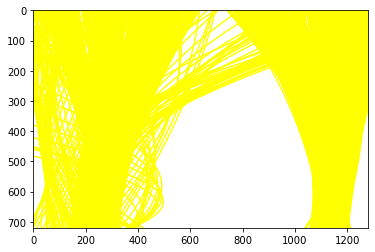

In [40]:
white_output = 'result1.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
videoattr = VideoAttributes()

leftLane = Line()
rightLane = Line()

clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_img) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)